In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [2]:
from data.dataset.codet_m4_cleaned import CoDeTM4Cleaned

In [3]:
train, val, test  = CoDeTM4Cleaned('../../data/codet_cleaned_20250812_201438/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)

2025-09-03 22:25:54,973 - INFO - Initialized CoDeTM4Cleaned with cleaned data from: ../../data/codet_cleaned_20250812_201438/


2025-09-03 22:25:55,434 - INFO - Loaded train split: 405069 samples


2025-09-03 22:25:55,512 - INFO - Loaded val split: 47035 samples


2025-09-03 22:25:55,584 - INFO - Loaded test split: 47046 samples


In [4]:
from datasets import concatenate_datasets

In [5]:
codet = concatenate_datasets([train, val, test])

In [6]:
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER, JAVA_PARSER, CPP_PARSER = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)

In [7]:
import matplotlib.pyplot as plt

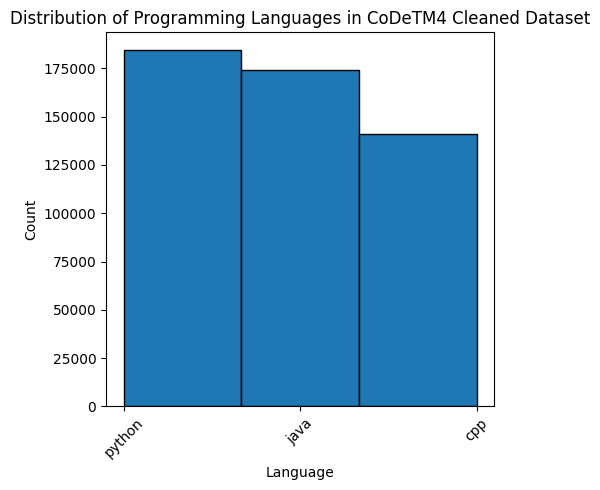

Python count: 184419
Java count: 173917
C++ count: 140814


In [8]:
language_counts = codet['language']
plt.figure(figsize=(5, 5))
plt.hist(language_counts, bins=len(set(language_counts)), edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in CoDeTM4 Cleaned Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

python_count = language_counts.count("python")
java_count = language_counts.count("java")
cpp_count = language_counts.count("cpp")

print(f'Python count: {python_count}')
print(f'Java count: {java_count}')
print(f'C++ count: {cpp_count}')

In [9]:
def get_parser(language):
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")

In [10]:
def create_tree(sample, code_key='cleaned_code'):
    language = sample['language']
    parser = get_parser(language)
    tree = parser.parse(bytes(sample[code_key], 'utf-8'))
    return tree

In [11]:
from tree_sitter import TreeCursor

def walk_tree(cursor: TreeCursor, depth=0):
    indent = '  ' * depth
    print(f"{indent}{cursor.node.type}")

    if cursor.goto_first_child():
        walk_tree(cursor, depth+1)
    
        while cursor.goto_next_sibling():
            walk_tree(cursor, depth+1)

        cursor.goto_parent()

In [12]:
from typing import Set

def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
    if types is None:
        types = set()
    
    types.add(cursor.node.type)

    if cursor.goto_first_child():
        get_node_types_from_tree(cursor, types)
    
        while cursor.goto_next_sibling():
            get_node_types_from_tree(cursor, types)

        cursor.goto_parent()

    return types

In [13]:
def extract_types(sample):
    # Import everything needed inside the function
    import tree_sitter_python as tspython
    import tree_sitter_cpp as tscpp
    import tree_sitter_java as tsjava
    from tree_sitter import Parser, Language, TreeCursor
    from typing import Set
    
    # Create parsers locally
    TS_PYTHON = Language(tspython.language())
    TS_JAVA = Language(tsjava.language())
    TS_CPP = Language(tscpp.language())
    
    PYTHON_PARSER = Parser(language=TS_PYTHON)
    JAVA_PARSER = Parser(language=TS_JAVA)
    CPP_PARSER = Parser(language=TS_CPP)
    
    def get_parser(language):
        match language:
            case 'python':
                return PYTHON_PARSER
            case 'java':
                return JAVA_PARSER
            case 'cpp':
                return CPP_PARSER
        raise ValueError(f"Unsupported language: {language}")
    
    def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
        if types is None:
            types = set()
        
        types.add(cursor.node.type)

        if cursor.goto_first_child():
            get_node_types_from_tree(cursor, types)
        
            while cursor.goto_next_sibling():
                get_node_types_from_tree(cursor, types)

            cursor.goto_parent()

        return types
    
    parser = get_parser(sample['language'])
    tree = parser.parse(sample['cleaned_code'].encode('utf-8'))
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types)}

result = codet.map(extract_types, batched=False, num_proc=8)

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)

print(f"Collected {len(all_types)} unique node types")

# # Below code doesn't work on windows due to different multiprocessing logic udner the hood
# def extract_types(sample):
#     parser = get_parser(sample['language'])
#     tree = parser.parse(sample['cleaned_code'].encode('utf-8'))
#     cursor = tree.walk()
#     types = get_node_types_from_tree(cursor)
#     return {"types": list(types)}

# result = codet.map(extract_types, batched=False, num_proc=8)

# all_types = set()
# for tlist in result['types']:
#     all_types.update(tlist)

# print(f"Collected {len(all_types)} unique node types")

Map (num_proc=8):   0%|          | 0/499150 [00:00<?, ? examples/s]

Collected 563 unique node types


In [14]:
all_types = sorted(list(all_types))

In [15]:
type_to_ind = {t: i for i, t in enumerate(all_types)}

In [16]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from tree_sitter import Node

In [17]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from torch import tensor, long as tlong
from tree_sitter import TreeCursor

def tree_to_graph(cursor: TreeCursor, id_map: Dict = None, next_id: int = 0, edges: List[Tuple[int, int]] = None) -> Tuple[List[Tuple[int, int]], Dict, int]:
    if edges is None:
        edges = []
    if id_map is None:
        id_map = {}

    # Assign ID to current node
    if cursor.node not in id_map:
        id_map[cursor.node] = next_id
        next_id += 1
    current_id = id_map[cursor.node]

    if cursor.goto_first_child():
        # Process first child
        if cursor.node not in id_map:
            id_map[cursor.node] = next_id
            next_id += 1
        child_id = id_map[cursor.node]
        edges.append((current_id, child_id))
        edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        # Process siblings
        while cursor.goto_next_sibling():
            if cursor.node not in id_map:
                id_map[cursor.node] = next_id
                next_id += 1
            child_id = id_map[cursor.node]
            edges.append((current_id, child_id))
            edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        cursor.goto_parent()

    return edges, id_map, next_id

In [18]:
from tqdm import tqdm

In [19]:
def create_graph(sample):
    tree = create_tree(sample)
    edges, id_map, _ = tree_to_graph(tree.walk())
    edge_index = tensor(edges, dtype=tlong).t().contiguous()
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = tensor(x, dtype=tlong)
    y = tensor([sample['target_binary']], dtype=tlong)

    graph_features = tensor(list(sample['features'].values()))
    
    metadata = {
        'language': sample['language'],
        'target': sample['target'],
        'target_binary': sample['target_binary'],
        'code': sample['code'],
        'cleaned_code': sample['cleaned_code']
    }
    
    data = Data(
        x=x, 
        y=y, 
        edge_index=edge_index, 
        graph_features=graph_features,
        metadata=metadata
    )    
    return data


In [20]:
codet

Dataset({
    features: ['code', 'language', 'model', 'split', 'target', 'source', 'features', 'cleaned_code', '__index_level_0__', 'target_binary'],
    num_rows: 499150
})

In [21]:
def create_graphs(dataset, desc_keyword):
    graphs = []

    for i, sample in enumerate(tqdm(dataset, desc=f'Creating {desc_keyword} graphs')):
        data = create_graph(sample)
        graphs.append(data)

    return graphs
    

In [22]:
from torch_geometric.data import Data
from torch import save
import gc

train_graphs = create_graphs(train, 'train')
save(train_graphs, '../../data/codet_graphs/train_graphs_cleaned.pt')
del train, train_graphs
gc.collect()
val_graphs = create_graphs(val, 'val')
save(val_graphs, '../../data/codet_graphs/val_graphs_cleaned.pt')
del val, val_graphs
gc.collect()
test_graphs = create_graphs(test, 'test')
save(test_graphs, '../../data/codet_graphs/test_graphs_cleaned.pt')
del test, test_graphs
gc.collect()
save(type_to_ind, '../../data/codet_graphs/type_to_ind_cleaned.pt')

Creating train graphs:   0%|                                                                | 0/405069 [00:00<?, ?it/s]

Creating train graphs:   0%|                                                    | 209/405069 [00:00<03:15, 2069.32it/s]

Creating train graphs:   0%|                                                    | 439/405069 [00:00<03:03, 2204.45it/s]

Creating train graphs:   0%|                                                    | 660/405069 [00:00<03:10, 2120.06it/s]

Creating train graphs:   0%|                                                    | 886/405069 [00:00<03:06, 2165.56it/s]

Creating train graphs:   0%|▏                                                  | 1121/405069 [00:00<03:01, 2230.81it/s]

Creating train graphs:   0%|▏                                                  | 1345/405069 [00:00<03:04, 2182.61it/s]

Creating train graphs:   0%|▏                                                  | 1564/405069 [00:00<03:04, 2184.96it/s]

Creating train graphs:   0%|▏                                                  | 1784/405069 [00:00<03:04, 2189.67it/s]

Creating train graphs:   0%|▎                                                  | 2012/405069 [00:00<03:02, 2210.74it/s]

Creating train graphs:   1%|▎                                                  | 2234/405069 [00:01<03:04, 2186.85it/s]

Creating train graphs:   1%|▎                                                  | 2453/405069 [00:01<03:08, 2136.30it/s]

Creating train graphs:   1%|▎                                                  | 2667/405069 [00:01<03:08, 2131.08it/s]

Creating train graphs:   1%|▎                                                  | 2881/405069 [00:01<03:09, 2127.42it/s]

Creating train graphs:   1%|▍                                                  | 3114/405069 [00:01<03:04, 2181.10it/s]

Creating train graphs:   1%|▍                                                  | 3334/405069 [00:01<03:04, 2180.24it/s]

Creating train graphs:   1%|▍                                                  | 3559/405069 [00:01<03:02, 2194.46it/s]

Creating train graphs:   1%|▍                                                  | 3779/405069 [00:01<03:04, 2176.68it/s]

Creating train graphs:   1%|▌                                                  | 4024/405069 [00:01<02:58, 2251.03it/s]

Creating train graphs:   1%|▌                                                  | 4260/405069 [00:01<02:55, 2283.38it/s]

Creating train graphs:   1%|▌                                                  | 4489/405069 [00:02<03:01, 2212.86it/s]

Creating train graphs:   1%|▌                                                  | 4711/405069 [00:02<03:03, 2176.84it/s]

Creating train graphs:   1%|▌                                                  | 4930/405069 [00:02<03:07, 2137.19it/s]

Creating train graphs:   1%|▋                                                  | 5155/405069 [00:02<03:04, 2169.81it/s]

Creating train graphs:   1%|▋                                                  | 5385/405069 [00:02<03:03, 2176.07it/s]

Creating train graphs:   1%|▋                                                  | 5620/405069 [00:02<02:59, 2226.78it/s]

Creating train graphs:   1%|▋                                                  | 5845/405069 [00:02<02:59, 2227.06it/s]

Creating train graphs:   1%|▊                                                  | 6068/405069 [00:02<03:00, 2214.85it/s]

Creating train graphs:   2%|▊                                                  | 6301/405069 [00:02<02:57, 2242.24it/s]

Creating train graphs:   2%|▊                                                  | 6535/405069 [00:02<02:55, 2264.49it/s]

Creating train graphs:   2%|▊                                                  | 6762/405069 [00:03<03:57, 1674.83it/s]

Creating train graphs:   2%|▉                                                  | 6971/405069 [00:03<03:44, 1773.85it/s]

Creating train graphs:   2%|▉                                                  | 7187/405069 [00:03<03:33, 1867.25it/s]

Creating train graphs:   2%|▉                                                  | 7417/405069 [00:03<03:20, 1982.30it/s]

Creating train graphs:   2%|▉                                                  | 7643/405069 [00:03<03:13, 2053.09it/s]

Creating train graphs:   2%|▉                                                  | 7880/405069 [00:03<03:05, 2136.34it/s]

Creating train graphs:   2%|█                                                  | 8102/405069 [00:03<03:04, 2148.00it/s]

Creating train graphs:   2%|█                                                  | 8332/405069 [00:03<03:01, 2185.63it/s]

Creating train graphs:   2%|█                                                  | 8554/405069 [00:04<03:01, 2182.92it/s]

Creating train graphs:   2%|█                                                  | 8789/405069 [00:04<02:58, 2225.35it/s]

Creating train graphs:   2%|█▏                                                 | 9014/405069 [00:04<03:01, 2181.23it/s]

Creating train graphs:   2%|█▏                                                 | 9243/405069 [00:04<02:58, 2212.90it/s]

Creating train graphs:   2%|█▏                                                 | 9466/405069 [00:04<02:59, 2204.97it/s]

Creating train graphs:   2%|█▏                                                 | 9688/405069 [00:04<02:58, 2209.39it/s]

Creating train graphs:   2%|█▏                                                 | 9910/405069 [00:04<03:00, 2186.64it/s]

Creating train graphs:   3%|█▎                                                | 10130/405069 [00:04<03:04, 2140.11it/s]

Creating train graphs:   3%|█▎                                                | 10345/405069 [00:04<03:04, 2136.76it/s]

Creating train graphs:   3%|█▎                                                | 10559/405069 [00:04<03:07, 2106.76it/s]

Creating train graphs:   3%|█▎                                                | 10785/405069 [00:05<03:03, 2151.55it/s]

Creating train graphs:   3%|█▎                                                | 11006/405069 [00:05<03:02, 2162.40it/s]

Creating train graphs:   3%|█▍                                                | 11223/405069 [00:05<03:02, 2158.27it/s]

Creating train graphs:   3%|█▍                                                | 11442/405069 [00:05<03:02, 2161.27it/s]

Creating train graphs:   3%|█▍                                                | 11664/405069 [00:05<03:00, 2178.69it/s]

Creating train graphs:   3%|█▍                                                | 11882/405069 [00:05<03:01, 2166.19it/s]

Creating train graphs:   3%|█▍                                                | 12100/405069 [00:05<03:01, 2170.29it/s]

Creating train graphs:   3%|█▌                                                | 12331/405069 [00:05<02:58, 2205.35it/s]

Creating train graphs:   3%|█▌                                                | 12563/405069 [00:05<02:55, 2239.51it/s]

Creating train graphs:   3%|█▌                                                | 12791/405069 [00:05<02:54, 2244.90it/s]

Creating train graphs:   3%|█▌                                                | 13020/405069 [00:06<02:54, 2251.64it/s]

Creating train graphs:   3%|█▋                                                | 13255/405069 [00:06<02:52, 2274.19it/s]

Creating train graphs:   3%|█▋                                                | 13483/405069 [00:06<02:57, 2210.03it/s]

Creating train graphs:   3%|█▋                                                | 13705/405069 [00:06<02:59, 2174.77it/s]

Creating train graphs:   3%|█▋                                                | 13923/405069 [00:06<03:01, 2151.24it/s]

Creating train graphs:   3%|█▋                                                | 14139/405069 [00:06<03:04, 2122.87it/s]

Creating train graphs:   4%|█▊                                                | 14352/405069 [00:06<03:07, 2088.49it/s]

Creating train graphs:   4%|█▊                                                | 14574/405069 [00:06<03:03, 2126.63it/s]

Creating train graphs:   4%|█▊                                                | 14815/405069 [00:06<02:57, 2203.18it/s]

Creating train graphs:   4%|█▊                                                | 15040/405069 [00:06<02:55, 2216.97it/s]

Creating train graphs:   4%|█▉                                                | 15262/405069 [00:07<02:56, 2209.52it/s]

Creating train graphs:   4%|█▉                                                | 15484/405069 [00:07<03:06, 2085.79it/s]

Creating train graphs:   4%|█▉                                                | 15702/405069 [00:07<03:04, 2112.62it/s]

Creating train graphs:   4%|█▉                                                | 15925/405069 [00:07<03:01, 2146.55it/s]

Creating train graphs:   4%|█▉                                                | 16165/405069 [00:07<02:55, 2220.66it/s]

Creating train graphs:   4%|██                                                | 16388/405069 [00:07<02:54, 2223.36it/s]

Creating train graphs:   4%|██                                                | 16614/405069 [00:07<02:54, 2231.95it/s]

Creating train graphs:   4%|██                                                | 16840/405069 [00:07<02:53, 2240.23it/s]

Creating train graphs:   4%|██                                                | 17065/405069 [00:07<02:56, 2203.68it/s]

Creating train graphs:   4%|██▏                                               | 17303/405069 [00:08<02:52, 2249.05it/s]

Creating train graphs:   4%|██▏                                               | 17532/405069 [00:08<02:51, 2254.49it/s]

Creating train graphs:   4%|██▏                                               | 17765/405069 [00:08<02:50, 2276.87it/s]

Creating train graphs:   4%|██▏                                               | 17993/405069 [00:08<02:55, 2205.57it/s]

Creating train graphs:   5%|██▎                                               | 18229/405069 [00:08<02:51, 2250.54it/s]

Creating train graphs:   5%|██▎                                               | 18455/405069 [00:08<02:52, 2243.10it/s]

Creating train graphs:   5%|██▎                                               | 18680/405069 [00:08<02:59, 2150.05it/s]

Creating train graphs:   5%|██▎                                               | 18902/405069 [00:08<02:58, 2163.93it/s]

Creating train graphs:   5%|██▎                                               | 19120/405069 [00:08<02:59, 2156.07it/s]

Creating train graphs:   5%|██▍                                               | 19337/405069 [00:09<04:16, 1505.03it/s]

Creating train graphs:   5%|██▍                                               | 19554/405069 [00:09<03:53, 1652.93it/s]

Creating train graphs:   5%|██▍                                               | 19771/405069 [00:09<03:36, 1778.70it/s]

Creating train graphs:   5%|██▍                                               | 19984/405069 [00:09<03:26, 1864.48it/s]

Creating train graphs:   5%|██▍                                               | 20191/405069 [00:09<03:21, 1914.57it/s]

Creating train graphs:   5%|██▌                                               | 20400/405069 [00:09<03:15, 1963.13it/s]

Creating train graphs:   5%|██▌                                               | 20618/405069 [00:09<03:10, 2019.87it/s]

Creating train graphs:   5%|██▌                                               | 20859/405069 [00:09<03:00, 2126.82it/s]

Creating train graphs:   5%|██▌                                               | 21077/405069 [00:09<03:03, 2097.72it/s]

Creating train graphs:   5%|██▋                                               | 21306/405069 [00:09<02:58, 2147.11it/s]

Creating train graphs:   5%|██▋                                               | 21524/405069 [00:10<02:58, 2144.20it/s]

Creating train graphs:   5%|██▋                                               | 21756/405069 [00:10<02:55, 2189.29it/s]

Creating train graphs:   5%|██▋                                               | 21977/405069 [00:10<02:58, 2144.86it/s]

Creating train graphs:   5%|██▋                                               | 22215/405069 [00:10<02:52, 2213.34it/s]

Creating train graphs:   6%|██▊                                               | 22438/405069 [00:10<02:52, 2211.74it/s]

Creating train graphs:   6%|██▊                                               | 22680/405069 [00:10<02:48, 2266.50it/s]

Creating train graphs:   6%|██▊                                               | 22908/405069 [00:10<02:50, 2237.39it/s]

Creating train graphs:   6%|██▊                                               | 23133/405069 [00:10<02:51, 2221.51it/s]

Creating train graphs:   6%|██▉                                               | 23356/405069 [00:10<02:52, 2211.00it/s]

Creating train graphs:   6%|██▉                                               | 23578/405069 [00:11<02:53, 2200.68it/s]

Creating train graphs:   6%|██▉                                               | 23799/405069 [00:11<02:53, 2196.95it/s]

Creating train graphs:   6%|██▉                                               | 24029/405069 [00:11<02:51, 2220.87it/s]

Creating train graphs:   6%|██▉                                               | 24262/405069 [00:11<02:49, 2253.22it/s]

Creating train graphs:   6%|███                                               | 24488/405069 [00:11<02:52, 2209.22it/s]

Creating train graphs:   6%|███                                               | 24710/405069 [00:11<02:58, 2130.96it/s]

Creating train graphs:   6%|███                                               | 24936/405069 [00:11<02:55, 2161.90it/s]

Creating train graphs:   6%|███                                               | 25153/405069 [00:11<02:57, 2139.37it/s]

Creating train graphs:   6%|███▏                                              | 25368/405069 [00:11<02:58, 2130.05it/s]

Creating train graphs:   6%|███▏                                              | 25613/405069 [00:11<02:50, 2223.65it/s]

Creating train graphs:   6%|███▏                                              | 25853/405069 [00:12<02:47, 2268.95it/s]

Creating train graphs:   6%|███▏                                              | 26085/405069 [00:12<02:45, 2284.02it/s]

Creating train graphs:   6%|███▏                                              | 26327/405069 [00:12<02:43, 2310.68it/s]

Creating train graphs:   7%|███▎                                              | 26559/405069 [00:12<02:45, 2286.34it/s]

Creating train graphs:   7%|███▎                                              | 26788/405069 [00:12<02:50, 2221.83it/s]

Creating train graphs:   7%|███▎                                              | 27011/405069 [00:12<02:52, 2192.35it/s]

Creating train graphs:   7%|███▎                                              | 27252/405069 [00:12<02:47, 2249.02it/s]

Creating train graphs:   7%|███▍                                              | 27478/405069 [00:12<02:51, 2207.03it/s]

Creating train graphs:   7%|███▍                                              | 27706/405069 [00:12<02:49, 2221.76it/s]

Creating train graphs:   7%|███▍                                              | 27941/405069 [00:12<02:47, 2253.43it/s]

Creating train graphs:   7%|███▍                                              | 28167/405069 [00:13<02:48, 2241.46it/s]

Creating train graphs:   7%|███▌                                              | 28408/405069 [00:13<02:44, 2291.03it/s]

Creating train graphs:   7%|███▌                                              | 28638/405069 [00:13<02:48, 2227.79it/s]

Creating train graphs:   7%|███▌                                              | 28862/405069 [00:13<02:52, 2186.75it/s]

Creating train graphs:   7%|███▌                                              | 29082/405069 [00:13<02:55, 2147.05it/s]

Creating train graphs:   7%|███▌                                              | 29306/405069 [00:13<02:52, 2173.85it/s]

Creating train graphs:   7%|███▋                                              | 29533/405069 [00:13<02:51, 2195.52it/s]

Creating train graphs:   7%|███▋                                              | 29772/405069 [00:13<02:47, 2246.04it/s]

Creating train graphs:   7%|███▋                                              | 30012/405069 [00:13<02:44, 2284.72it/s]

Creating train graphs:   7%|███▋                                              | 30241/405069 [00:14<02:44, 2272.83it/s]

Creating train graphs:   8%|███▊                                              | 30472/405069 [00:14<02:44, 2277.09it/s]

Creating train graphs:   8%|███▊                                              | 30700/405069 [00:14<02:44, 2271.22it/s]

Creating train graphs:   8%|███▊                                              | 30930/405069 [00:14<02:44, 2273.02it/s]

Creating train graphs:   8%|███▊                                              | 31164/405069 [00:14<02:43, 2292.92it/s]

Creating train graphs:   8%|███▉                                              | 31394/405069 [00:14<02:45, 2261.34it/s]

Creating train graphs:   8%|███▉                                              | 31621/405069 [00:14<02:47, 2230.93it/s]

Creating train graphs:   8%|███▉                                              | 31845/405069 [00:14<02:48, 2220.55it/s]

Creating train graphs:   8%|███▉                                              | 32079/405069 [00:14<02:45, 2255.71it/s]

Creating train graphs:   8%|███▉                                              | 32319/405069 [00:14<02:42, 2291.64it/s]

Creating train graphs:   8%|████                                              | 32549/405069 [00:15<02:46, 2240.95it/s]

Creating train graphs:   8%|████                                              | 32785/405069 [00:15<02:44, 2269.73it/s]

Creating train graphs:   8%|████                                              | 33017/405069 [00:15<02:42, 2283.95it/s]

Creating train graphs:   8%|████                                              | 33252/405069 [00:15<02:41, 2303.49it/s]

Creating train graphs:   8%|████▏                                             | 33483/405069 [00:15<02:48, 2207.05it/s]

Creating train graphs:   8%|████▏                                             | 33705/405069 [00:15<02:50, 2179.30it/s]

Creating train graphs:   8%|████▏                                             | 33925/405069 [00:15<02:50, 2178.99it/s]

Creating train graphs:   8%|████▏                                             | 34144/405069 [00:15<02:51, 2163.26it/s]

Creating train graphs:   8%|████▏                                             | 34362/405069 [00:15<02:51, 2161.84it/s]

Creating train graphs:   9%|████▎                                             | 34579/405069 [00:15<02:51, 2157.88it/s]

Creating train graphs:   9%|████▎                                             | 34806/405069 [00:16<02:49, 2184.53it/s]

Creating train graphs:   9%|████▎                                             | 35025/405069 [00:16<02:49, 2180.03it/s]

Creating train graphs:   9%|████▎                                             | 35244/405069 [00:16<04:31, 1361.98it/s]

Creating train graphs:   9%|████▍                                             | 35487/405069 [00:16<03:53, 1582.60it/s]

Creating train graphs:   9%|████▍                                             | 35693/405069 [00:16<03:38, 1692.26it/s]

Creating train graphs:   9%|████▍                                             | 35891/405069 [00:16<03:30, 1750.37it/s]

Creating train graphs:   9%|████▍                                             | 36115/405069 [00:16<03:16, 1877.34it/s]

Creating train graphs:   9%|████▍                                             | 36336/405069 [00:16<03:07, 1967.23it/s]

Creating train graphs:   9%|████▌                                             | 36555/405069 [00:17<03:01, 2029.23it/s]

Creating train graphs:   9%|████▌                                             | 36780/405069 [00:17<02:56, 2092.00it/s]

Creating train graphs:   9%|████▌                                             | 37023/405069 [00:17<02:48, 2189.64it/s]

Creating train graphs:   9%|████▌                                             | 37248/405069 [00:17<02:47, 2200.76it/s]

Creating train graphs:   9%|████▋                                             | 37477/405069 [00:17<02:45, 2226.90it/s]

Creating train graphs:   9%|████▋                                             | 37703/405069 [00:17<02:46, 2204.49it/s]

Creating train graphs:   9%|████▋                                             | 37926/405069 [00:17<02:46, 2199.28it/s]

Creating train graphs:   9%|████▋                                             | 38154/405069 [00:17<02:45, 2216.53it/s]

Creating train graphs:   9%|████▋                                             | 38377/405069 [00:17<02:45, 2213.97it/s]

Creating train graphs:  10%|████▊                                             | 38602/405069 [00:17<02:44, 2224.64it/s]

Creating train graphs:  10%|████▊                                             | 38825/405069 [00:18<02:46, 2193.61it/s]

Creating train graphs:  10%|████▊                                             | 39045/405069 [00:18<02:48, 2169.77it/s]

Creating train graphs:  10%|████▊                                             | 39272/405069 [00:18<02:46, 2192.92it/s]

Creating train graphs:  10%|████▉                                             | 39505/405069 [00:18<02:44, 2226.82it/s]

Creating train graphs:  10%|████▉                                             | 39728/405069 [00:18<02:43, 2227.76it/s]

Creating train graphs:  10%|████▉                                             | 39952/405069 [00:18<02:43, 2231.39it/s]

Creating train graphs:  10%|████▉                                             | 40176/405069 [00:18<02:44, 2214.16it/s]

Creating train graphs:  10%|████▉                                             | 40398/405069 [00:18<02:47, 2177.13it/s]

Creating train graphs:  10%|█████                                             | 40617/405069 [00:18<02:47, 2174.52it/s]

Creating train graphs:  10%|█████                                             | 40835/405069 [00:19<02:48, 2157.04it/s]

Creating train graphs:  10%|█████                                             | 41065/405069 [00:19<02:46, 2186.29it/s]

Creating train graphs:  10%|█████                                             | 41284/405069 [00:19<02:49, 2149.33it/s]

Creating train graphs:  10%|█████                                             | 41513/405069 [00:19<02:45, 2190.53it/s]

Creating train graphs:  10%|█████▏                                            | 41758/405069 [00:19<02:40, 2267.04it/s]

Creating train graphs:  10%|█████▏                                            | 41985/405069 [00:19<02:44, 2209.01it/s]

Creating train graphs:  10%|█████▏                                            | 42207/405069 [00:19<02:45, 2186.67it/s]

Creating train graphs:  10%|█████▏                                            | 42426/405069 [00:19<02:47, 2168.62it/s]

Creating train graphs:  11%|█████▎                                            | 42647/405069 [00:19<02:46, 2180.72it/s]

Creating train graphs:  11%|█████▎                                            | 42866/405069 [00:19<02:47, 2164.35it/s]

Creating train graphs:  11%|█████▎                                            | 43083/405069 [00:20<02:48, 2147.05it/s]

Creating train graphs:  11%|█████▎                                            | 43306/405069 [00:20<02:46, 2171.46it/s]

Creating train graphs:  11%|█████▎                                            | 43524/405069 [00:20<02:47, 2161.19it/s]

Creating train graphs:  11%|█████▍                                            | 43771/405069 [00:20<02:40, 2245.94it/s]

Creating train graphs:  11%|█████▍                                            | 43999/405069 [00:20<02:40, 2256.03it/s]

Creating train graphs:  11%|█████▍                                            | 44244/405069 [00:20<02:36, 2306.89it/s]

Creating train graphs:  11%|█████▍                                            | 44475/405069 [00:20<02:43, 2209.17it/s]

Creating train graphs:  11%|█████▌                                            | 44697/405069 [00:20<02:45, 2174.56it/s]

Creating train graphs:  11%|█████▌                                            | 44931/405069 [00:20<02:42, 2222.35it/s]

Creating train graphs:  11%|█████▌                                            | 45157/405069 [00:20<02:41, 2226.85it/s]

Creating train graphs:  11%|█████▌                                            | 45381/405069 [00:21<02:44, 2192.06it/s]

Creating train graphs:  11%|█████▋                                            | 45616/405069 [00:21<02:40, 2238.15it/s]

Creating train graphs:  11%|█████▋                                            | 45849/405069 [00:21<02:39, 2258.57it/s]

Creating train graphs:  11%|█████▋                                            | 46076/405069 [00:21<02:41, 2229.03it/s]

Creating train graphs:  11%|█████▋                                            | 46300/405069 [00:21<02:40, 2232.24it/s]

Creating train graphs:  11%|█████▋                                            | 46524/405069 [00:21<02:48, 2133.62it/s]

Creating train graphs:  12%|█████▊                                            | 46747/405069 [00:21<02:46, 2155.14it/s]

Creating train graphs:  12%|█████▊                                            | 46980/405069 [00:21<02:42, 2205.92it/s]

Creating train graphs:  12%|█████▊                                            | 47211/405069 [00:21<02:40, 2236.44it/s]

Creating train graphs:  12%|█████▊                                            | 47436/405069 [00:21<02:41, 2220.78it/s]

Creating train graphs:  12%|█████▉                                            | 47673/405069 [00:22<02:37, 2264.77it/s]

Creating train graphs:  12%|█████▉                                            | 47906/405069 [00:22<02:36, 2277.35it/s]

Creating train graphs:  12%|█████▉                                            | 48134/405069 [00:22<02:40, 2225.30it/s]

Creating train graphs:  12%|█████▉                                            | 48366/405069 [00:22<02:38, 2246.46it/s]

Creating train graphs:  12%|█████▉                                            | 48591/405069 [00:22<02:40, 2221.34it/s]

Creating train graphs:  12%|██████                                            | 48814/405069 [00:22<02:40, 2223.88it/s]

Creating train graphs:  12%|██████                                            | 49040/405069 [00:22<02:39, 2234.55it/s]

Creating train graphs:  12%|██████                                            | 49264/405069 [00:22<02:41, 2209.94it/s]

Creating train graphs:  12%|██████                                            | 49486/405069 [00:22<02:44, 2168.08it/s]

Creating train graphs:  12%|██████▏                                           | 49720/405069 [00:23<02:40, 2218.36it/s]

Creating train graphs:  12%|██████▏                                           | 49943/405069 [00:23<02:41, 2202.32it/s]

Creating train graphs:  12%|██████▏                                           | 50182/405069 [00:23<02:37, 2250.95it/s]

Creating train graphs:  12%|██████▏                                           | 50408/405069 [00:23<02:42, 2176.45it/s]

Creating train graphs:  12%|██████▏                                           | 50627/405069 [00:23<02:43, 2174.09it/s]

Creating train graphs:  13%|██████▎                                           | 50845/405069 [00:23<02:45, 2144.49it/s]

Creating train graphs:  13%|██████▎                                           | 51060/405069 [00:23<02:48, 2097.22it/s]

Creating train graphs:  13%|██████▎                                           | 51290/405069 [00:23<02:44, 2155.86it/s]

Creating train graphs:  13%|██████▎                                           | 51507/405069 [00:23<02:43, 2159.98it/s]

Creating train graphs:  13%|██████▍                                           | 51728/405069 [00:23<02:42, 2168.33it/s]

Creating train graphs:  13%|██████▍                                           | 51946/405069 [00:24<02:43, 2165.38it/s]

Creating train graphs:  13%|██████▍                                           | 52191/405069 [00:24<02:36, 2249.67it/s]

Creating train graphs:  13%|██████▍                                           | 52417/405069 [00:24<02:42, 2175.15it/s]

Creating train graphs:  13%|██████▍                                           | 52656/405069 [00:24<02:37, 2237.62it/s]

Creating train graphs:  13%|██████▌                                           | 52881/405069 [00:24<02:40, 2189.85it/s]

Creating train graphs:  13%|██████▌                                           | 53101/405069 [00:24<02:43, 2149.11it/s]

Creating train graphs:  13%|██████▌                                           | 53341/405069 [00:24<02:38, 2221.51it/s]

Creating train graphs:  13%|██████▌                                           | 53570/405069 [00:24<02:36, 2240.41it/s]

Creating train graphs:  13%|██████▋                                           | 53808/405069 [00:24<02:34, 2276.11it/s]

Creating train graphs:  13%|██████▋                                           | 54042/405069 [00:24<02:32, 2294.99it/s]

Creating train graphs:  13%|██████▋                                           | 54275/405069 [00:25<02:33, 2291.78it/s]

Creating train graphs:  13%|██████▋                                           | 54505/405069 [00:25<02:34, 2273.97it/s]

Creating train graphs:  14%|██████▊                                           | 54733/405069 [00:25<02:35, 2249.16it/s]

Creating train graphs:  14%|██████▊                                           | 54959/405069 [00:25<02:38, 2213.24it/s]

Creating train graphs:  14%|██████▊                                           | 55181/405069 [00:25<04:45, 1223.98it/s]

Creating train graphs:  14%|██████▊                                           | 55391/405069 [00:25<04:11, 1388.32it/s]

Creating train graphs:  14%|██████▊                                           | 55612/405069 [00:25<03:44, 1558.69it/s]

Creating train graphs:  14%|██████▉                                           | 55819/405069 [00:26<03:28, 1673.20it/s]

Creating train graphs:  14%|██████▉                                           | 56036/405069 [00:26<03:14, 1796.47it/s]

Creating train graphs:  14%|██████▉                                           | 56275/405069 [00:26<02:59, 1946.70it/s]

Creating train graphs:  14%|██████▉                                           | 56512/405069 [00:26<02:49, 2061.67it/s]

Creating train graphs:  14%|███████                                           | 56734/405069 [00:26<02:45, 2105.93it/s]

Creating train graphs:  14%|███████                                           | 56967/405069 [00:26<02:40, 2163.70it/s]

Creating train graphs:  14%|███████                                           | 57191/405069 [00:26<02:40, 2173.19it/s]

Creating train graphs:  14%|███████                                           | 57414/405069 [00:26<02:40, 2164.52it/s]

Creating train graphs:  14%|███████                                           | 57635/405069 [00:26<02:42, 2140.36it/s]

Creating train graphs:  14%|███████▏                                          | 57856/405069 [00:26<02:41, 2154.32it/s]

Creating train graphs:  14%|███████▏                                          | 58093/405069 [00:27<02:36, 2210.95it/s]

Creating train graphs:  14%|███████▏                                          | 58316/405069 [00:27<02:41, 2147.09it/s]

Creating train graphs:  14%|███████▏                                          | 58538/405069 [00:27<02:39, 2168.18it/s]

Creating train graphs:  15%|███████▎                                          | 58764/405069 [00:27<02:38, 2188.63it/s]

Creating train graphs:  15%|███████▎                                          | 58984/405069 [00:27<02:37, 2191.97it/s]

Creating train graphs:  15%|███████▎                                          | 59204/405069 [00:27<02:40, 2149.83it/s]

Creating train graphs:  15%|███████▎                                          | 59420/405069 [00:27<02:42, 2121.74it/s]

Creating train graphs:  15%|███████▎                                          | 59637/405069 [00:27<02:42, 2123.44it/s]

Creating train graphs:  15%|███████▍                                          | 59856/405069 [00:27<02:41, 2142.95it/s]

Creating train graphs:  15%|███████▍                                          | 60082/405069 [00:28<02:38, 2171.08it/s]

Creating train graphs:  15%|███████▍                                          | 60313/405069 [00:28<02:36, 2205.67it/s]

Creating train graphs:  15%|███████▍                                          | 60544/405069 [00:28<02:34, 2229.99it/s]

Creating train graphs:  15%|███████▌                                          | 60768/405069 [00:28<02:36, 2206.75it/s]

Creating train graphs:  15%|███████▌                                          | 61004/405069 [00:28<02:32, 2252.02it/s]

Creating train graphs:  15%|███████▌                                          | 61235/405069 [00:28<02:31, 2262.52it/s]

Creating train graphs:  15%|███████▌                                          | 61462/405069 [00:28<02:33, 2231.59it/s]

Creating train graphs:  15%|███████▌                                          | 61686/405069 [00:28<02:35, 2214.48it/s]

Creating train graphs:  15%|███████▋                                          | 61913/405069 [00:28<02:34, 2224.28it/s]

Creating train graphs:  15%|███████▋                                          | 62140/405069 [00:28<02:33, 2237.79it/s]

Creating train graphs:  15%|███████▋                                          | 62370/405069 [00:29<02:31, 2256.26it/s]

Creating train graphs:  15%|███████▋                                          | 62605/405069 [00:29<02:30, 2277.40it/s]

Creating train graphs:  16%|███████▊                                          | 62833/405069 [00:29<02:33, 2225.15it/s]

Creating train graphs:  16%|███████▊                                          | 63056/405069 [00:29<02:36, 2188.03it/s]

Creating train graphs:  16%|███████▊                                          | 63282/405069 [00:29<02:34, 2209.04it/s]

Creating train graphs:  16%|███████▊                                          | 63510/405069 [00:29<02:33, 2229.92it/s]

Creating train graphs:  16%|███████▊                                          | 63734/405069 [00:29<02:34, 2213.25it/s]

Creating train graphs:  16%|███████▉                                          | 63956/405069 [00:29<02:34, 2208.72it/s]

Creating train graphs:  16%|███████▉                                          | 64177/405069 [00:29<02:37, 2170.54it/s]

Creating train graphs:  16%|███████▉                                          | 64398/405069 [00:29<02:36, 2175.73it/s]

Creating train graphs:  16%|███████▉                                          | 64616/405069 [00:30<02:37, 2164.23it/s]

Creating train graphs:  16%|████████                                          | 64836/405069 [00:30<02:36, 2168.39it/s]

Creating train graphs:  16%|████████                                          | 65053/405069 [00:30<02:37, 2156.10it/s]

Creating train graphs:  16%|████████                                          | 65280/405069 [00:30<02:35, 2189.81it/s]

Creating train graphs:  16%|████████                                          | 65500/405069 [00:30<02:51, 1980.93it/s]

Creating train graphs:  16%|████████                                          | 65718/405069 [00:30<02:46, 2036.11it/s]

Creating train graphs:  16%|████████▏                                         | 65943/405069 [00:30<02:42, 2090.85it/s]

Creating train graphs:  16%|████████▏                                         | 66159/405069 [00:30<02:40, 2110.75it/s]

Creating train graphs:  16%|████████▏                                         | 66401/405069 [00:30<02:34, 2194.46it/s]

Creating train graphs:  16%|████████▏                                         | 66624/405069 [00:31<02:33, 2198.43it/s]

Creating train graphs:  17%|████████▎                                         | 66845/405069 [00:31<02:34, 2182.55it/s]

Creating train graphs:  17%|████████▎                                         | 67078/405069 [00:31<02:32, 2219.42it/s]

Creating train graphs:  17%|████████▎                                         | 67314/405069 [00:31<02:29, 2254.30it/s]

Creating train graphs:  17%|████████▎                                         | 67548/405069 [00:31<02:28, 2272.95it/s]

Creating train graphs:  17%|████████▎                                         | 67776/405069 [00:31<02:30, 2248.36it/s]

Creating train graphs:  17%|████████▍                                         | 68002/405069 [00:31<02:34, 2174.75it/s]

Creating train graphs:  17%|████████▍                                         | 68221/405069 [00:31<02:35, 2166.62it/s]

Creating train graphs:  17%|████████▍                                         | 68448/405069 [00:31<02:33, 2190.36it/s]

Creating train graphs:  17%|████████▍                                         | 68668/405069 [00:31<02:36, 2142.91it/s]

Creating train graphs:  17%|████████▌                                         | 68885/405069 [00:32<02:36, 2150.78it/s]

Creating train graphs:  17%|████████▌                                         | 69120/405069 [00:32<02:32, 2202.74it/s]

Creating train graphs:  17%|████████▌                                         | 69344/405069 [00:32<02:32, 2207.22it/s]

Creating train graphs:  17%|████████▌                                         | 69565/405069 [00:32<02:33, 2188.63it/s]

Creating train graphs:  17%|████████▌                                         | 69798/405069 [00:32<02:30, 2230.34it/s]

Creating train graphs:  17%|████████▋                                         | 70023/405069 [00:32<02:29, 2236.17it/s]

Creating train graphs:  17%|████████▋                                         | 70247/405069 [00:32<02:30, 2217.52it/s]

Creating train graphs:  17%|████████▋                                         | 70474/405069 [00:32<02:29, 2233.07it/s]

Creating train graphs:  17%|████████▋                                         | 70698/405069 [00:32<02:31, 2202.37it/s]

Creating train graphs:  18%|████████▊                                         | 70919/405069 [00:32<02:32, 2191.69it/s]

Creating train graphs:  18%|████████▊                                         | 71146/405069 [00:33<02:31, 2208.30it/s]

Creating train graphs:  18%|████████▊                                         | 71367/405069 [00:33<02:33, 2176.57it/s]

Creating train graphs:  18%|████████▊                                         | 71585/405069 [00:33<02:34, 2158.53it/s]

Creating train graphs:  18%|████████▊                                         | 71809/405069 [00:33<02:33, 2176.09it/s]

Creating train graphs:  18%|████████▉                                         | 72027/405069 [00:33<02:34, 2158.13it/s]

Creating train graphs:  18%|████████▉                                         | 72245/405069 [00:33<02:33, 2164.58it/s]

Creating train graphs:  18%|████████▉                                         | 72480/405069 [00:33<02:30, 2212.97it/s]

Creating train graphs:  18%|████████▉                                         | 72709/405069 [00:33<02:29, 2222.64it/s]

Creating train graphs:  18%|█████████                                         | 72932/405069 [00:33<02:30, 2211.70it/s]

Creating train graphs:  18%|█████████                                         | 73155/405069 [00:33<02:29, 2217.12it/s]

Creating train graphs:  18%|█████████                                         | 73377/405069 [00:34<02:33, 2153.92it/s]

Creating train graphs:  18%|█████████                                         | 73593/405069 [00:34<02:38, 2088.59it/s]

Creating train graphs:  18%|█████████                                         | 73816/405069 [00:34<02:36, 2123.19it/s]

Creating train graphs:  18%|█████████▏                                        | 74039/405069 [00:34<02:34, 2148.00it/s]

Creating train graphs:  18%|█████████▏                                        | 74255/405069 [00:34<02:34, 2138.98it/s]

Creating train graphs:  18%|█████████▏                                        | 74474/405069 [00:34<02:33, 2147.67it/s]

Creating train graphs:  18%|█████████▏                                        | 74707/405069 [00:34<02:30, 2201.46it/s]

Creating train graphs:  19%|█████████▎                                        | 74939/405069 [00:34<02:27, 2236.60it/s]

Creating train graphs:  19%|█████████▎                                        | 75163/405069 [00:34<02:33, 2154.29it/s]

Creating train graphs:  19%|█████████▎                                        | 75380/405069 [00:35<02:37, 2092.02it/s]

Creating train graphs:  19%|█████████▎                                        | 75590/405069 [00:35<02:39, 2070.57it/s]

Creating train graphs:  19%|█████████▎                                        | 75815/405069 [00:35<02:35, 2116.19it/s]

Creating train graphs:  19%|█████████▍                                        | 76050/405069 [00:35<02:30, 2184.25it/s]

Creating train graphs:  19%|█████████▍                                        | 76275/405069 [00:35<02:29, 2197.11it/s]

Creating train graphs:  19%|█████████▍                                        | 76496/405069 [00:35<02:32, 2156.39it/s]

Creating train graphs:  19%|█████████▍                                        | 76733/405069 [00:35<02:27, 2218.80it/s]

Creating train graphs:  19%|█████████▍                                        | 76963/405069 [00:35<02:26, 2242.72it/s]

Creating train graphs:  19%|█████████▌                                        | 77188/405069 [00:35<02:27, 2218.59it/s]

Creating train graphs:  19%|█████████▌                                        | 77411/405069 [00:35<02:29, 2189.68it/s]

Creating train graphs:  19%|█████████▌                                        | 77631/405069 [00:36<02:31, 2154.78it/s]

Creating train graphs:  19%|█████████▌                                        | 77855/405069 [00:36<02:30, 2173.30it/s]

Creating train graphs:  19%|█████████▋                                        | 78073/405069 [00:36<02:33, 2125.36it/s]

Creating train graphs:  19%|█████████▋                                        | 78307/405069 [00:36<02:29, 2187.73it/s]

Creating train graphs:  19%|█████████▋                                        | 78527/405069 [00:36<02:29, 2178.56it/s]

Creating train graphs:  19%|█████████▋                                        | 78746/405069 [00:36<02:32, 2137.91it/s]

Creating train graphs:  19%|█████████▋                                        | 78961/405069 [00:36<02:32, 2135.21it/s]

Creating train graphs:  20%|█████████▊                                        | 79184/405069 [00:36<02:30, 2163.03it/s]

Creating train graphs:  20%|█████████▊                                        | 79413/405069 [00:36<02:27, 2200.53it/s]

Creating train graphs:  20%|█████████▊                                        | 79635/405069 [00:36<02:27, 2199.79it/s]

Creating train graphs:  20%|█████████▊                                        | 79856/405069 [00:37<05:02, 1076.73it/s]

Creating train graphs:  20%|█████████▉                                        | 80065/405069 [00:37<04:19, 1250.83it/s]

Creating train graphs:  20%|█████████▉                                        | 80284/405069 [00:37<03:46, 1435.92it/s]

Creating train graphs:  20%|█████████▉                                        | 80515/405069 [00:37<03:19, 1624.39it/s]

Creating train graphs:  20%|█████████▉                                        | 80743/405069 [00:37<03:02, 1776.50it/s]

Creating train graphs:  20%|█████████▉                                        | 80972/405069 [00:37<02:50, 1901.92it/s]

Creating train graphs:  20%|██████████                                        | 81192/405069 [00:38<02:43, 1975.82it/s]

Creating train graphs:  20%|██████████                                        | 81424/405069 [00:38<02:36, 2064.62it/s]

Creating train graphs:  20%|██████████                                        | 81650/405069 [00:38<02:32, 2119.54it/s]

Creating train graphs:  20%|██████████                                        | 81885/405069 [00:38<02:28, 2179.33it/s]

Creating train graphs:  20%|██████████▏                                       | 82111/405069 [00:38<02:30, 2146.71it/s]

Creating train graphs:  20%|██████████▏                                       | 82335/405069 [00:38<02:28, 2167.30it/s]

Creating train graphs:  20%|██████████▏                                       | 82556/405069 [00:38<02:29, 2160.87it/s]

Creating train graphs:  20%|██████████▏                                       | 82791/405069 [00:38<02:25, 2209.56it/s]

Creating train graphs:  20%|██████████▏                                       | 83014/405069 [00:38<02:25, 2215.54it/s]

Creating train graphs:  21%|██████████▎                                       | 83252/405069 [00:38<02:22, 2257.47it/s]

Creating train graphs:  21%|██████████▎                                       | 83479/405069 [00:39<02:23, 2241.27it/s]

Creating train graphs:  21%|██████████▎                                       | 83704/405069 [00:39<02:27, 2185.73it/s]

Creating train graphs:  21%|██████████▎                                       | 83929/405069 [00:39<02:26, 2198.05it/s]

Creating train graphs:  21%|██████████▍                                       | 84163/405069 [00:39<02:23, 2233.13it/s]

Creating train graphs:  21%|██████████▍                                       | 84387/405069 [00:39<02:31, 2110.77it/s]

Creating train graphs:  21%|██████████▍                                       | 84606/405069 [00:39<02:30, 2127.26it/s]

Creating train graphs:  21%|██████████▍                                       | 84849/405069 [00:39<02:25, 2208.18it/s]

Creating train graphs:  21%|██████████▌                                       | 85071/405069 [00:39<02:25, 2192.47it/s]

Creating train graphs:  21%|██████████▌                                       | 85304/405069 [00:39<02:23, 2232.62it/s]

Creating train graphs:  21%|██████████▌                                       | 85531/405069 [00:39<02:22, 2237.05it/s]

Creating train graphs:  21%|██████████▌                                       | 85776/405069 [00:40<02:18, 2299.94it/s]

Creating train graphs:  21%|██████████▌                                       | 86007/405069 [00:40<02:23, 2223.74it/s]

Creating train graphs:  21%|██████████▋                                       | 86231/405069 [00:40<02:28, 2153.41it/s]

Creating train graphs:  21%|██████████▋                                       | 86473/405069 [00:40<02:23, 2223.35it/s]

Creating train graphs:  21%|██████████▋                                       | 86697/405069 [00:40<02:26, 2171.56it/s]

Creating train graphs:  21%|██████████▋                                       | 86915/405069 [00:40<02:48, 1886.65it/s]

Creating train graphs:  22%|██████████▊                                       | 87111/405069 [00:40<02:46, 1905.92it/s]

Creating train graphs:  22%|██████████▊                                       | 87351/405069 [00:40<02:36, 2035.16it/s]

Creating train graphs:  22%|██████████▊                                       | 87566/405069 [00:40<02:34, 2061.56it/s]

Creating train graphs:  22%|██████████▊                                       | 87800/405069 [00:41<02:28, 2140.94it/s]

Creating train graphs:  22%|██████████▊                                       | 88021/405069 [00:41<02:26, 2160.92it/s]

Creating train graphs:  22%|██████████▉                                       | 88240/405069 [00:41<02:27, 2150.56it/s]

Creating train graphs:  22%|██████████▉                                       | 88469/405069 [00:41<02:24, 2185.00it/s]

Creating train graphs:  22%|██████████▉                                       | 88710/405069 [00:41<02:20, 2251.24it/s]

Creating train graphs:  22%|██████████▉                                       | 88936/405069 [00:41<02:21, 2227.46it/s]

Creating train graphs:  22%|███████████                                       | 89164/405069 [00:41<02:20, 2242.94it/s]

Creating train graphs:  22%|███████████                                       | 89389/405069 [00:41<02:21, 2231.80it/s]

Creating train graphs:  22%|███████████                                       | 89614/405069 [00:41<02:21, 2230.59it/s]

Creating train graphs:  22%|███████████                                       | 89843/405069 [00:41<02:20, 2241.57it/s]

Creating train graphs:  22%|███████████                                       | 90076/405069 [00:42<02:18, 2267.84it/s]

Creating train graphs:  22%|███████████▏                                      | 90309/405069 [00:42<02:18, 2279.57it/s]

Creating train graphs:  22%|███████████▏                                      | 90538/405069 [00:42<02:19, 2255.79it/s]

Creating train graphs:  22%|███████████▏                                      | 90775/405069 [00:42<02:17, 2288.87it/s]

Creating train graphs:  22%|███████████▏                                      | 91006/405069 [00:42<02:16, 2295.14it/s]

Creating train graphs:  23%|███████████▎                                      | 91242/405069 [00:42<02:15, 2307.60it/s]

Creating train graphs:  23%|███████████▎                                      | 91473/405069 [00:42<02:20, 2228.62it/s]

Creating train graphs:  23%|███████████▎                                      | 91707/405069 [00:42<02:18, 2254.50it/s]

Creating train graphs:  23%|███████████▎                                      | 91933/405069 [00:42<02:21, 2210.73it/s]

Creating train graphs:  23%|███████████▍                                      | 92155/405069 [00:43<02:23, 2181.68it/s]

Creating train graphs:  23%|███████████▍                                      | 92412/405069 [00:43<02:16, 2287.91it/s]

Creating train graphs:  23%|███████████▍                                      | 92642/405069 [00:43<02:17, 2271.50it/s]

Creating train graphs:  23%|███████████▍                                      | 92870/405069 [00:43<02:18, 2260.73it/s]

Creating train graphs:  23%|███████████▍                                      | 93100/405069 [00:43<02:17, 2272.27it/s]

Creating train graphs:  23%|███████████▌                                      | 93328/405069 [00:43<02:19, 2234.91it/s]

Creating train graphs:  23%|███████████▌                                      | 93553/405069 [00:43<02:19, 2232.78it/s]

Creating train graphs:  23%|███████████▌                                      | 93777/405069 [00:43<02:20, 2208.87it/s]

Creating train graphs:  23%|███████████▌                                      | 93999/405069 [00:43<02:24, 2155.15it/s]

Creating train graphs:  23%|███████████▋                                      | 94226/405069 [00:43<02:22, 2182.15it/s]

Creating train graphs:  23%|███████████▋                                      | 94445/405069 [00:44<02:25, 2140.61it/s]

Creating train graphs:  23%|███████████▋                                      | 94660/405069 [00:44<02:25, 2130.96it/s]

Creating train graphs:  23%|███████████▋                                      | 94887/405069 [00:44<02:23, 2165.25it/s]

Creating train graphs:  23%|███████████▋                                      | 95112/405069 [00:44<02:21, 2190.15it/s]

Creating train graphs:  24%|███████████▊                                      | 95335/405069 [00:44<02:21, 2195.45it/s]

Creating train graphs:  24%|███████████▊                                      | 95565/405069 [00:44<02:19, 2219.85it/s]

Creating train graphs:  24%|███████████▊                                      | 95795/405069 [00:44<02:17, 2243.58it/s]

Creating train graphs:  24%|███████████▊                                      | 96020/405069 [00:44<02:20, 2193.25it/s]

Creating train graphs:  24%|███████████▉                                      | 96240/405069 [00:44<02:22, 2163.48it/s]

Creating train graphs:  24%|███████████▉                                      | 96467/405069 [00:44<02:21, 2188.23it/s]

Creating train graphs:  24%|███████████▉                                      | 96691/405069 [00:45<02:19, 2203.45it/s]

Creating train graphs:  24%|███████████▉                                      | 96921/405069 [00:45<02:18, 2225.43it/s]

Creating train graphs:  24%|███████████▉                                      | 97144/405069 [00:45<02:19, 2207.15it/s]

Creating train graphs:  24%|████████████                                      | 97365/405069 [00:45<02:20, 2188.59it/s]

Creating train graphs:  24%|████████████                                      | 97586/405069 [00:45<02:20, 2194.87it/s]

Creating train graphs:  24%|████████████                                      | 97806/405069 [00:45<02:24, 2127.04it/s]

Creating train graphs:  24%|████████████                                      | 98020/405069 [00:45<02:25, 2112.37it/s]

Creating train graphs:  24%|████████████▏                                     | 98264/405069 [00:45<02:18, 2207.97it/s]

Creating train graphs:  24%|████████████▏                                     | 98486/405069 [00:45<02:21, 2166.88it/s]

Creating train graphs:  24%|████████████▏                                     | 98704/405069 [00:45<02:22, 2151.88it/s]

Creating train graphs:  24%|████████████▏                                     | 98927/405069 [00:46<02:20, 2174.71it/s]

Creating train graphs:  24%|████████████▏                                     | 99155/405069 [00:46<02:19, 2199.25it/s]

Creating train graphs:  25%|████████████▎                                     | 99376/405069 [00:46<02:18, 2202.43it/s]

Creating train graphs:  25%|████████████▎                                     | 99599/405069 [00:46<02:18, 2204.07it/s]

Creating train graphs:  25%|████████████▎                                     | 99820/405069 [00:46<02:18, 2199.30it/s]

Creating train graphs:  25%|████████████                                     | 100051/405069 [00:46<02:16, 2232.22it/s]

Creating train graphs:  25%|████████████▏                                    | 100275/405069 [00:46<02:18, 2201.72it/s]

Creating train graphs:  25%|████████████▏                                    | 100497/405069 [00:46<02:17, 2207.12it/s]

Creating train graphs:  25%|████████████▏                                    | 100718/405069 [00:46<02:26, 2075.39it/s]

Creating train graphs:  25%|████████████▏                                    | 100928/405069 [00:47<02:30, 2024.69it/s]

Creating train graphs:  25%|████████████▏                                    | 101132/405069 [00:47<02:37, 1930.47it/s]

Creating train graphs:  25%|████████████▎                                    | 101327/405069 [00:47<02:40, 1888.61it/s]

Creating train graphs:  25%|████████████▎                                    | 101517/405069 [00:47<02:42, 1865.72it/s]

Creating train graphs:  25%|████████████▎                                    | 101705/405069 [00:47<02:46, 1823.41it/s]

Creating train graphs:  25%|████████████▎                                    | 101888/405069 [00:47<03:00, 1678.34it/s]

Creating train graphs:  25%|████████████▎                                    | 102058/405069 [00:47<03:09, 1601.85it/s]

Creating train graphs:  25%|████████████▎                                    | 102220/405069 [00:47<03:13, 1568.78it/s]

Creating train graphs:  25%|████████████▍                                    | 102378/405069 [00:47<03:16, 1542.39it/s]

Creating train graphs:  25%|████████████▍                                    | 102536/405069 [00:48<03:14, 1552.79it/s]

Creating train graphs:  25%|████████████▍                                    | 102692/405069 [00:48<03:15, 1550.44it/s]

Creating train graphs:  25%|████████████▍                                    | 102926/405069 [00:48<02:50, 1772.31it/s]

Creating train graphs:  25%|████████████▍                                    | 103155/405069 [00:48<02:37, 1922.71it/s]

Creating train graphs:  26%|████████████▌                                    | 103399/405069 [00:48<02:25, 2068.36it/s]

Creating train graphs:  26%|████████████▌                                    | 103628/405069 [00:48<02:21, 2133.64it/s]

Creating train graphs:  26%|████████████▌                                    | 103872/405069 [00:48<02:15, 2217.86it/s]

Creating train graphs:  26%|████████████▌                                    | 104112/405069 [00:48<02:12, 2265.19it/s]

Creating train graphs:  26%|████████████▌                                    | 104339/405069 [00:48<02:18, 2163.76it/s]

Creating train graphs:  26%|████████████▋                                    | 104557/405069 [00:48<02:27, 2033.58it/s]

Creating train graphs:  26%|████████████▋                                    | 104763/405069 [00:49<02:29, 2004.56it/s]

Creating train graphs:  26%|████████████▋                                    | 104965/405069 [00:49<02:32, 1964.72it/s]

Creating train graphs:  26%|████████████▋                                    | 105163/405069 [00:49<02:36, 1920.29it/s]

Creating train graphs:  26%|████████████▋                                    | 105356/405069 [00:49<02:43, 1835.05it/s]

Creating train graphs:  26%|████████████▊                                    | 105541/405069 [00:49<02:44, 1818.99it/s]

Creating train graphs:  26%|████████████▊                                    | 105724/405069 [00:49<02:47, 1791.80it/s]

Creating train graphs:  26%|████████████▊                                    | 105904/405069 [00:49<02:49, 1764.10it/s]

Creating train graphs:  26%|████████████▊                                    | 106081/405069 [00:49<02:52, 1736.11it/s]

Creating train graphs:  26%|████████████▊                                    | 106259/405069 [00:49<02:51, 1743.67it/s]

Creating train graphs:  26%|████████████▉                                    | 106434/405069 [00:50<02:52, 1730.48it/s]

Creating train graphs:  26%|████████████▉                                    | 106608/405069 [00:50<02:53, 1718.26it/s]

Creating train graphs:  26%|████████████▉                                    | 106782/405069 [00:50<02:53, 1719.59it/s]

Creating train graphs:  26%|████████████▉                                    | 106954/405069 [00:50<02:54, 1709.67it/s]

Creating train graphs:  26%|████████████▉                                    | 107126/405069 [00:50<02:54, 1707.69it/s]

Creating train graphs:  26%|████████████▉                                    | 107297/405069 [00:50<02:56, 1683.51it/s]

Creating train graphs:  27%|████████████▉                                    | 107466/405069 [00:50<02:57, 1675.58it/s]

Creating train graphs:  27%|█████████████                                    | 107642/405069 [00:50<02:54, 1700.42it/s]

Creating train graphs:  27%|█████████████                                    | 107827/405069 [00:50<02:50, 1739.55it/s]

Creating train graphs:  27%|█████████████                                    | 108003/405069 [00:50<02:50, 1745.61it/s]

Creating train graphs:  27%|█████████████                                    | 108178/405069 [00:51<02:51, 1726.37it/s]

Creating train graphs:  27%|█████████████                                    | 108351/405069 [00:51<02:52, 1717.28it/s]

Creating train graphs:  27%|█████████████▏                                   | 108533/405069 [00:51<02:50, 1742.51it/s]

Creating train graphs:  27%|█████████████▏                                   | 108711/405069 [00:51<02:49, 1748.45it/s]

Creating train graphs:  27%|█████████████▏                                   | 108886/405069 [00:51<02:49, 1743.73it/s]

Creating train graphs:  27%|█████████████▏                                   | 109061/405069 [00:51<02:51, 1730.17it/s]

Creating train graphs:  27%|█████████████▏                                   | 109245/405069 [00:51<02:48, 1757.49it/s]

Creating train graphs:  27%|█████████████▏                                   | 109422/405069 [00:51<02:48, 1755.99it/s]

Creating train graphs:  27%|█████████████▎                                   | 109611/405069 [00:51<02:45, 1790.48it/s]

Creating train graphs:  27%|█████████████▎                                   | 109791/405069 [00:51<02:46, 1777.46it/s]

Creating train graphs:  27%|█████████████▎                                   | 109969/405069 [00:52<02:46, 1767.73it/s]

Creating train graphs:  27%|█████████████▎                                   | 110146/405069 [00:52<02:51, 1722.50it/s]

Creating train graphs:  27%|█████████████▎                                   | 110321/405069 [00:52<02:50, 1730.51it/s]

Creating train graphs:  27%|█████████████▎                                   | 110508/405069 [00:52<02:46, 1766.37it/s]

Creating train graphs:  27%|█████████████▋                                    | 110685/405069 [00:52<06:28, 756.97it/s]

Creating train graphs:  27%|█████████████▋                                    | 110855/405069 [00:53<05:26, 899.92it/s]

Creating train graphs:  27%|█████████████▍                                   | 111033/405069 [00:53<04:38, 1055.72it/s]

Creating train graphs:  27%|█████████████▍                                   | 111205/405069 [00:53<04:06, 1190.91it/s]

Creating train graphs:  27%|█████████████▍                                   | 111380/405069 [00:53<03:43, 1313.89it/s]

Creating train graphs:  28%|█████████████▍                                   | 111544/405069 [00:53<04:08, 1180.79it/s]

Creating train graphs:  28%|█████████████▊                                    | 111687/405069 [00:53<05:02, 968.74it/s]

Creating train graphs:  28%|█████████████▊                                    | 111807/405069 [00:53<05:46, 845.86it/s]

Creating train graphs:  28%|█████████████▊                                    | 111909/405069 [00:54<06:27, 757.52it/s]

Creating train graphs:  28%|█████████████▊                                    | 111997/405069 [00:54<06:59, 698.90it/s]

Creating train graphs:  28%|█████████████▊                                    | 112075/405069 [00:54<07:24, 658.89it/s]

Creating train graphs:  28%|█████████████▊                                    | 112146/405069 [00:54<07:41, 634.08it/s]

Creating train graphs:  28%|█████████████▊                                    | 112213/405069 [00:54<08:13, 593.91it/s]

Creating train graphs:  28%|█████████████▊                                    | 112275/405069 [00:54<08:19, 586.61it/s]

Creating train graphs:  28%|█████████████▊                                    | 112335/405069 [00:54<08:37, 565.53it/s]

Creating train graphs:  28%|█████████████▊                                    | 112393/405069 [00:55<09:07, 534.86it/s]

Creating train graphs:  28%|█████████████▉                                    | 112450/405069 [00:55<09:02, 539.57it/s]

Creating train graphs:  28%|█████████████▉                                    | 112508/405069 [00:55<08:53, 548.67it/s]

Creating train graphs:  28%|█████████████▉                                    | 112566/405069 [00:55<08:46, 555.65it/s]

Creating train graphs:  28%|█████████████▉                                    | 112638/405069 [00:55<08:06, 601.39it/s]

Creating train graphs:  28%|█████████████▉                                    | 112699/405069 [00:55<08:20, 583.91it/s]

Creating train graphs:  28%|█████████████▉                                    | 112758/405069 [00:55<08:29, 574.28it/s]

Creating train graphs:  28%|█████████████▉                                    | 112816/405069 [00:55<08:38, 563.14it/s]

Creating train graphs:  28%|█████████████▉                                    | 112873/405069 [00:55<09:04, 536.20it/s]

Creating train graphs:  28%|█████████████▉                                    | 112927/405069 [00:56<09:14, 527.01it/s]

Creating train graphs:  28%|█████████████▉                                    | 112980/405069 [00:56<10:26, 466.45it/s]

Creating train graphs:  28%|█████████████▉                                    | 113031/405069 [00:56<10:17, 472.88it/s]

Creating train graphs:  28%|█████████████▉                                    | 113082/405069 [00:56<10:12, 476.47it/s]

Creating train graphs:  28%|█████████████▉                                    | 113147/405069 [00:56<09:18, 522.83it/s]

Creating train graphs:  28%|█████████████▉                                    | 113212/405069 [00:56<08:48, 552.44it/s]

Creating train graphs:  28%|█████████████▉                                    | 113270/405069 [00:56<08:43, 557.11it/s]

Creating train graphs:  28%|█████████████▉                                    | 113328/405069 [00:56<08:46, 554.13it/s]

Creating train graphs:  28%|█████████████▉                                    | 113384/405069 [00:56<08:49, 551.06it/s]

Creating train graphs:  28%|██████████████                                    | 113441/405069 [00:56<08:43, 556.55it/s]

Creating train graphs:  28%|██████████████                                    | 113497/405069 [00:57<09:07, 532.61it/s]

Creating train graphs:  28%|██████████████                                    | 113551/405069 [00:57<09:25, 515.59it/s]

Creating train graphs:  28%|██████████████                                    | 113610/405069 [00:57<09:03, 536.59it/s]

Creating train graphs:  28%|██████████████                                    | 113673/405069 [00:57<08:37, 563.43it/s]

Creating train graphs:  28%|██████████████                                    | 113730/405069 [00:57<08:44, 555.64it/s]

Creating train graphs:  28%|██████████████                                    | 113786/405069 [00:57<09:14, 524.93it/s]

Creating train graphs:  28%|██████████████                                    | 113839/405069 [00:57<10:10, 476.80it/s]

Creating train graphs:  28%|██████████████                                    | 113898/405069 [00:57<09:34, 506.98it/s]

Creating train graphs:  28%|██████████████                                    | 113950/405069 [00:57<09:34, 506.38it/s]

Creating train graphs:  28%|██████████████                                    | 114003/405069 [00:58<09:27, 513.02it/s]

Creating train graphs:  28%|██████████████                                    | 114055/405069 [00:58<09:36, 504.89it/s]

Creating train graphs:  28%|██████████████                                    | 114118/405069 [00:58<09:08, 530.09it/s]

Creating train graphs:  28%|██████████████                                    | 114181/405069 [00:58<08:42, 557.09it/s]

Creating train graphs:  28%|██████████████                                    | 114242/405069 [00:58<08:29, 570.75it/s]

Creating train graphs:  28%|██████████████                                    | 114300/405069 [00:58<08:44, 554.04it/s]

Creating train graphs:  28%|██████████████                                    | 114362/405069 [00:58<08:28, 571.35it/s]

Creating train graphs:  28%|██████████████                                    | 114426/405069 [00:58<08:12, 589.57it/s]

Creating train graphs:  28%|██████████████▏                                   | 114486/405069 [00:58<08:14, 587.47it/s]

Creating train graphs:  28%|██████████████▏                                   | 114547/405069 [00:59<08:10, 592.33it/s]

Creating train graphs:  28%|██████████████▏                                   | 114607/405069 [00:59<08:14, 587.67it/s]

Creating train graphs:  28%|██████████████▏                                   | 114666/405069 [00:59<08:35, 563.53it/s]

Creating train graphs:  28%|██████████████▏                                   | 114727/405069 [00:59<08:24, 575.20it/s]

Creating train graphs:  28%|██████████████▏                                   | 114785/405069 [00:59<08:23, 576.59it/s]

Creating train graphs:  28%|██████████████▏                                   | 114843/405069 [00:59<08:44, 553.28it/s]

Creating train graphs:  28%|██████████████▏                                   | 114901/405069 [00:59<08:40, 557.74it/s]

Creating train graphs:  28%|██████████████▏                                   | 114957/405069 [00:59<09:45, 495.40it/s]

Creating train graphs:  28%|██████████████▏                                   | 115011/405069 [00:59<09:31, 507.36it/s]

Creating train graphs:  28%|██████████████▏                                   | 115066/405069 [00:59<09:18, 519.16it/s]

Creating train graphs:  28%|██████████████▏                                   | 115119/405069 [01:00<09:24, 513.50it/s]

Creating train graphs:  28%|██████████████▏                                   | 115171/405069 [01:00<10:41, 452.25it/s]

Creating train graphs:  28%|██████████████▏                                   | 115220/405069 [01:00<10:28, 460.97it/s]

Creating train graphs:  28%|██████████████▏                                   | 115296/405069 [01:00<08:55, 541.02it/s]

Creating train graphs:  28%|██████████████▏                                   | 115354/405069 [01:00<08:46, 550.39it/s]

Creating train graphs:  28%|██████████████▏                                   | 115421/405069 [01:00<08:15, 584.47it/s]

Creating train graphs:  29%|██████████████▎                                   | 115481/405069 [01:00<09:15, 521.12it/s]

Creating train graphs:  29%|██████████████▎                                   | 115545/405069 [01:00<08:43, 552.95it/s]

Creating train graphs:  29%|██████████████▎                                   | 115608/405069 [01:00<08:25, 572.68it/s]

Creating train graphs:  29%|██████████████▎                                   | 115669/405069 [01:01<08:20, 578.33it/s]

Creating train graphs:  29%|██████████████▎                                   | 115728/405069 [01:01<09:37, 501.38it/s]

Creating train graphs:  29%|██████████████▎                                   | 115795/405069 [01:01<08:56, 539.67it/s]

Creating train graphs:  29%|██████████████▎                                   | 115859/405069 [01:01<08:30, 566.67it/s]

Creating train graphs:  29%|██████████████▎                                   | 115919/405069 [01:01<08:23, 574.28it/s]

Creating train graphs:  29%|██████████████▎                                   | 115983/405069 [01:01<08:08, 591.23it/s]

Creating train graphs:  29%|██████████████▎                                   | 116044/405069 [01:01<08:31, 564.92it/s]

Creating train graphs:  29%|██████████████▎                                   | 116102/405069 [01:01<08:54, 540.39it/s]

Creating train graphs:  29%|██████████████▎                                   | 116157/405069 [01:02<09:05, 529.90it/s]

Creating train graphs:  29%|██████████████▎                                   | 116211/405069 [01:02<09:06, 528.30it/s]

Creating train graphs:  29%|██████████████▎                                   | 116274/405069 [01:02<08:39, 555.43it/s]

Creating train graphs:  29%|██████████████▎                                   | 116332/405069 [01:02<08:33, 562.47it/s]

Creating train graphs:  29%|██████████████▎                                   | 116406/405069 [01:02<07:51, 612.27it/s]

Creating train graphs:  29%|██████████████▍                                   | 116468/405069 [01:02<07:59, 602.20it/s]

Creating train graphs:  29%|██████████████▍                                   | 116529/405069 [01:02<08:00, 600.97it/s]

Creating train graphs:  29%|██████████████▍                                   | 116590/405069 [01:02<08:16, 581.52it/s]

Creating train graphs:  29%|██████████████▍                                   | 116649/405069 [01:02<08:20, 575.70it/s]

Creating train graphs:  29%|██████████████▍                                   | 116708/405069 [01:02<08:18, 578.15it/s]

Creating train graphs:  29%|██████████████▍                                   | 116766/405069 [01:03<08:50, 543.90it/s]

Creating train graphs:  29%|██████████████▍                                   | 116827/405069 [01:03<08:36, 557.76it/s]

Creating train graphs:  29%|██████████████▍                                   | 116906/405069 [01:03<07:45, 618.56it/s]

Creating train graphs:  29%|██████████████▍                                   | 116969/405069 [01:03<08:04, 594.52it/s]

Creating train graphs:  29%|██████████████▍                                   | 117029/405069 [01:03<08:04, 594.39it/s]

Creating train graphs:  29%|██████████████▍                                   | 117089/405069 [01:03<08:29, 565.24it/s]

Creating train graphs:  29%|██████████████▍                                   | 117151/405069 [01:03<08:16, 579.76it/s]

Creating train graphs:  29%|██████████████▍                                   | 117210/405069 [01:03<09:28, 506.18it/s]

Creating train graphs:  29%|██████████████▍                                   | 117264/405069 [01:03<09:21, 512.34it/s]

Creating train graphs:  29%|██████████████▍                                   | 117318/405069 [01:04<09:15, 518.43it/s]

Creating train graphs:  29%|██████████████▍                                   | 117379/405069 [01:04<08:50, 542.42it/s]

Creating train graphs:  29%|██████████████▍                                   | 117435/405069 [01:04<09:10, 522.20it/s]

Creating train graphs:  29%|██████████████▌                                   | 117491/405069 [01:04<09:02, 529.79it/s]

Creating train graphs:  29%|██████████████▌                                   | 117545/405069 [01:04<09:12, 520.86it/s]

Creating train graphs:  29%|██████████████▌                                   | 117598/405069 [01:04<10:02, 477.37it/s]

Creating train graphs:  29%|██████████████▌                                   | 117659/405069 [01:04<09:23, 510.43it/s]

Creating train graphs:  29%|██████████████▌                                   | 117713/405069 [01:04<09:17, 515.77it/s]

Creating train graphs:  29%|██████████████▌                                   | 117770/405069 [01:04<09:02, 529.60it/s]

Creating train graphs:  29%|██████████████▌                                   | 117835/405069 [01:05<08:33, 559.34it/s]

Creating train graphs:  29%|██████████████▌                                   | 117892/405069 [01:05<09:00, 531.69it/s]

Creating train graphs:  29%|██████████████▌                                   | 117946/405069 [01:05<09:23, 509.69it/s]

Creating train graphs:  29%|██████████████▌                                   | 117998/405069 [01:05<09:30, 502.80it/s]

Creating train graphs:  29%|██████████████▌                                   | 118056/405069 [01:05<09:14, 517.15it/s]

Creating train graphs:  29%|██████████████▌                                   | 118120/405069 [01:05<08:54, 536.70it/s]

Creating train graphs:  29%|██████████████▌                                   | 118174/405069 [01:05<09:25, 507.58it/s]

Creating train graphs:  29%|██████████████▌                                   | 118226/405069 [01:05<09:35, 498.64it/s]

Creating train graphs:  29%|██████████████▌                                   | 118277/405069 [01:05<10:11, 469.24it/s]

Creating train graphs:  29%|██████████████▌                                   | 118337/405069 [01:06<09:32, 500.54it/s]

Creating train graphs:  29%|██████████████▌                                   | 118388/405069 [01:06<09:55, 481.81it/s]

Creating train graphs:  29%|██████████████▌                                   | 118453/405069 [01:06<09:02, 528.03it/s]

Creating train graphs:  29%|██████████████▋                                   | 118507/405069 [01:06<09:08, 522.56it/s]

Creating train graphs:  29%|██████████████▋                                   | 118560/405069 [01:06<09:10, 520.25it/s]

Creating train graphs:  29%|██████████████▋                                   | 118613/405069 [01:06<09:39, 494.68it/s]

Creating train graphs:  29%|██████████████▋                                   | 118674/405069 [01:06<09:08, 522.50it/s]

Creating train graphs:  29%|██████████████▋                                   | 118727/405069 [01:06<09:15, 515.85it/s]

Creating train graphs:  29%|██████████████▋                                   | 118779/405069 [01:06<09:26, 505.52it/s]

Creating train graphs:  29%|██████████████▋                                   | 118831/405069 [01:07<09:21, 509.64it/s]

Creating train graphs:  29%|██████████████▋                                   | 118883/405069 [01:07<09:24, 506.78it/s]

Creating train graphs:  29%|██████████████▋                                   | 118946/405069 [01:07<08:52, 537.82it/s]

Creating train graphs:  29%|██████████████▋                                   | 119020/405069 [01:07<08:09, 584.75it/s]

Creating train graphs:  29%|██████████████▋                                   | 119079/405069 [01:07<08:27, 563.43it/s]

Creating train graphs:  29%|██████████████▋                                   | 119141/405069 [01:07<08:17, 574.62it/s]

Creating train graphs:  29%|██████████████▋                                   | 119204/405069 [01:07<08:06, 587.15it/s]

Creating train graphs:  29%|██████████████▋                                   | 119263/405069 [01:07<08:22, 568.22it/s]

Creating train graphs:  29%|██████████████▋                                   | 119320/405069 [01:07<09:05, 523.83it/s]

Creating train graphs:  29%|██████████████▋                                   | 119390/405069 [01:07<08:19, 571.96it/s]

Creating train graphs:  29%|██████████████▋                                   | 119449/405069 [01:08<08:35, 553.71it/s]

Creating train graphs:  30%|██████████████▊                                   | 119506/405069 [01:08<09:11, 517.94it/s]

Creating train graphs:  30%|██████████████▊                                   | 119559/405069 [01:08<09:22, 507.52it/s]

Creating train graphs:  30%|██████████████▊                                   | 119629/405069 [01:08<08:29, 559.96it/s]

Creating train graphs:  30%|██████████████▊                                   | 119686/405069 [01:08<08:29, 559.64it/s]

Creating train graphs:  30%|██████████████▊                                   | 119754/405069 [01:08<08:00, 593.90it/s]

Creating train graphs:  30%|██████████████▊                                   | 119817/405069 [01:08<08:28, 560.58it/s]

Creating train graphs:  30%|██████████████▊                                   | 119874/405069 [01:08<08:48, 539.29it/s]

Creating train graphs:  30%|██████████████▊                                   | 119929/405069 [01:08<08:47, 540.75it/s]

Creating train graphs:  30%|██████████████▊                                   | 119985/405069 [01:09<08:47, 540.09it/s]

Creating train graphs:  30%|██████████████▊                                   | 120048/405069 [01:09<08:25, 564.05it/s]

Creating train graphs:  30%|██████████████▊                                   | 120107/405069 [01:09<08:20, 569.89it/s]

Creating train graphs:  30%|██████████████▊                                   | 120169/405069 [01:09<08:07, 584.48it/s]

Creating train graphs:  30%|██████████████▊                                   | 120231/405069 [01:09<08:01, 591.44it/s]

Creating train graphs:  30%|██████████████▊                                   | 120302/405069 [01:09<07:35, 624.50it/s]

Creating train graphs:  30%|██████████████▊                                   | 120366/405069 [01:09<07:35, 625.39it/s]

Creating train graphs:  30%|██████████████▊                                   | 120429/405069 [01:09<07:50, 605.28it/s]

Creating train graphs:  30%|██████████████▊                                   | 120490/405069 [01:09<08:23, 565.69it/s]

Creating train graphs:  30%|██████████████▉                                   | 120548/405069 [01:10<08:33, 554.24it/s]

Creating train graphs:  30%|██████████████▉                                   | 120604/405069 [01:10<09:07, 519.60it/s]

Creating train graphs:  30%|██████████████▉                                   | 120663/405069 [01:10<09:02, 524.48it/s]

Creating train graphs:  30%|██████████████▉                                   | 120716/405069 [01:10<09:45, 486.03it/s]

Creating train graphs:  30%|██████████████▉                                   | 120776/405069 [01:10<09:10, 516.31it/s]

Creating train graphs:  30%|██████████████▉                                   | 120830/405069 [01:10<09:05, 521.39it/s]

Creating train graphs:  30%|██████████████▉                                   | 120893/405069 [01:10<08:36, 550.42it/s]

Creating train graphs:  30%|██████████████▉                                   | 120949/405069 [01:10<09:05, 520.39it/s]

Creating train graphs:  30%|██████████████▉                                   | 121006/405069 [01:10<08:51, 534.17it/s]

Creating train graphs:  30%|██████████████▉                                   | 121061/405069 [01:11<09:15, 511.08it/s]

Creating train graphs:  30%|██████████████▉                                   | 121129/405069 [01:11<08:30, 556.50it/s]

Creating train graphs:  30%|██████████████▉                                   | 121188/405069 [01:11<08:47, 538.50it/s]

Creating train graphs:  30%|██████████████▉                                   | 121248/405069 [01:11<08:59, 526.32it/s]

Creating train graphs:  30%|██████████████▉                                   | 121312/405069 [01:11<08:29, 557.42it/s]

Creating train graphs:  30%|██████████████▉                                   | 121379/405069 [01:11<08:11, 577.69it/s]

Creating train graphs:  30%|██████████████▉                                   | 121438/405069 [01:11<08:31, 554.54it/s]

Creating train graphs:  30%|██████████████▉                                   | 121494/405069 [01:11<08:31, 554.52it/s]

Creating train graphs:  30%|███████████████                                   | 121550/405069 [01:11<08:37, 548.29it/s]

Creating train graphs:  30%|███████████████                                   | 121608/405069 [01:12<08:30, 555.76it/s]

Creating train graphs:  30%|███████████████                                   | 121664/405069 [01:12<08:40, 544.40it/s]

Creating train graphs:  30%|███████████████                                   | 121723/405069 [01:12<08:35, 550.08it/s]

Creating train graphs:  30%|███████████████                                   | 121779/405069 [01:12<09:18, 507.56it/s]

Creating train graphs:  30%|███████████████                                   | 121831/405069 [01:12<09:21, 504.06it/s]

Creating train graphs:  30%|███████████████                                   | 121882/405069 [01:12<09:26, 500.13it/s]

Creating train graphs:  30%|███████████████                                   | 121933/405069 [01:12<09:43, 485.10it/s]

Creating train graphs:  30%|███████████████                                   | 121990/405069 [01:12<09:17, 507.47it/s]

Creating train graphs:  30%|███████████████                                   | 122050/405069 [01:12<08:50, 533.88it/s]

Creating train graphs:  30%|███████████████                                   | 122113/405069 [01:12<08:25, 560.09it/s]

Creating train graphs:  30%|███████████████                                   | 122170/405069 [01:13<08:26, 558.10it/s]

Creating train graphs:  30%|███████████████                                   | 122229/405069 [01:13<08:19, 565.78it/s]

Creating train graphs:  30%|███████████████                                   | 122286/405069 [01:13<08:30, 553.98it/s]

Creating train graphs:  30%|███████████████                                   | 122351/405069 [01:13<08:05, 581.93it/s]

Creating train graphs:  30%|███████████████                                   | 122410/405069 [01:13<08:15, 570.89it/s]

Creating train graphs:  30%|███████████████                                   | 122472/405069 [01:13<08:04, 583.47it/s]

Creating train graphs:  30%|███████████████                                   | 122531/405069 [01:13<09:16, 508.02it/s]

Creating train graphs:  30%|███████████████▏                                  | 122599/405069 [01:13<08:31, 552.36it/s]

Creating train graphs:  30%|███████████████▏                                  | 122657/405069 [01:13<08:25, 558.43it/s]

Creating train graphs:  30%|███████████████▏                                  | 122716/405069 [01:14<08:17, 567.32it/s]

Creating train graphs:  30%|███████████████▏                                  | 122777/405069 [01:14<08:11, 574.61it/s]

Creating train graphs:  30%|███████████████▏                                  | 122836/405069 [01:14<08:07, 579.04it/s]

Creating train graphs:  30%|███████████████▏                                  | 122902/405069 [01:14<08:00, 587.25it/s]

Creating train graphs:  30%|███████████████▏                                  | 122962/405069 [01:14<08:11, 574.33it/s]

Creating train graphs:  30%|███████████████▏                                  | 123022/405069 [01:14<08:07, 578.37it/s]

Creating train graphs:  30%|███████████████▏                                  | 123081/405069 [01:14<08:17, 566.98it/s]

Creating train graphs:  30%|███████████████▏                                  | 123152/405069 [01:14<07:44, 606.29it/s]

Creating train graphs:  30%|███████████████▏                                  | 123213/405069 [01:14<08:10, 574.05it/s]

Creating train graphs:  30%|███████████████▏                                  | 123271/405069 [01:15<08:28, 553.89it/s]

Creating train graphs:  30%|███████████████▏                                  | 123327/405069 [01:15<08:55, 526.23it/s]

Creating train graphs:  30%|███████████████▏                                  | 123381/405069 [01:15<09:00, 521.43it/s]

Creating train graphs:  30%|███████████████▏                                  | 123448/405069 [01:15<08:20, 562.74it/s]

Creating train graphs:  30%|███████████████▏                                  | 123507/405069 [01:15<08:16, 567.27it/s]

Creating train graphs:  31%|███████████████▎                                  | 123565/405069 [01:15<08:24, 558.09it/s]

Creating train graphs:  31%|███████████████▎                                  | 123622/405069 [01:15<08:41, 539.84it/s]

Creating train graphs:  31%|███████████████▎                                  | 123677/405069 [01:15<09:16, 505.58it/s]

Creating train graphs:  31%|███████████████▎                                  | 123729/405069 [01:15<09:28, 494.66it/s]

Creating train graphs:  31%|███████████████▎                                  | 123803/405069 [01:16<08:20, 562.07it/s]

Creating train graphs:  31%|███████████████▎                                  | 123866/405069 [01:16<08:05, 579.58it/s]

Creating train graphs:  31%|███████████████▎                                  | 123925/405069 [01:16<08:20, 561.65it/s]

Creating train graphs:  31%|███████████████▎                                  | 123982/405069 [01:16<08:43, 536.68it/s]

Creating train graphs:  31%|███████████████▎                                  | 124037/405069 [01:16<08:55, 524.36it/s]

Creating train graphs:  31%|███████████████▎                                  | 124111/405069 [01:16<08:02, 582.69it/s]

Creating train graphs:  31%|███████████████▎                                  | 124180/405069 [01:16<07:39, 611.40it/s]

Creating train graphs:  31%|███████████████▎                                  | 124242/405069 [01:16<07:49, 598.37it/s]

Creating train graphs:  31%|███████████████▎                                  | 124303/405069 [01:16<07:53, 593.21it/s]

Creating train graphs:  31%|███████████████▎                                  | 124363/405069 [01:16<08:06, 576.94it/s]

Creating train graphs:  31%|███████████████▎                                  | 124421/405069 [01:17<08:26, 554.15it/s]

Creating train graphs:  31%|███████████████▎                                  | 124477/405069 [01:17<09:07, 512.65it/s]

Creating train graphs:  31%|███████████████▎                                  | 124529/405069 [01:17<09:18, 502.43it/s]

Creating train graphs:  31%|███████████████▍                                  | 124580/405069 [01:17<09:29, 492.38it/s]

Creating train graphs:  31%|███████████████▍                                  | 124630/405069 [01:17<09:56, 469.84it/s]

Creating train graphs:  31%|███████████████▍                                  | 124694/405069 [01:17<09:03, 516.22it/s]

Creating train graphs:  31%|███████████████▍                                  | 124749/405069 [01:17<08:54, 524.22it/s]

Creating train graphs:  31%|███████████████▍                                  | 124802/405069 [01:17<09:00, 518.47it/s]

Creating train graphs:  31%|███████████████▍                                  | 124855/405069 [01:17<09:01, 517.33it/s]

Creating train graphs:  31%|███████████████▍                                  | 124909/405069 [01:18<08:54, 523.87it/s]

Creating train graphs:  31%|███████████████▍                                  | 124970/405069 [01:18<08:49, 528.95it/s]

Creating train graphs:  31%|███████████████▍                                  | 125024/405069 [01:18<08:53, 524.59it/s]

Creating train graphs:  31%|███████████████▍                                  | 125083/405069 [01:18<08:38, 540.30it/s]

Creating train graphs:  31%|███████████████▍                                  | 125145/405069 [01:18<08:18, 561.79it/s]

Creating train graphs:  31%|███████████████▍                                  | 125202/405069 [01:18<08:34, 543.53it/s]

Creating train graphs:  31%|███████████████▍                                  | 125260/405069 [01:18<08:25, 553.99it/s]

Creating train graphs:  31%|███████████████▍                                  | 125316/405069 [01:18<08:29, 549.35it/s]

Creating train graphs:  31%|███████████████▍                                  | 125372/405069 [01:18<08:33, 544.53it/s]

Creating train graphs:  31%|███████████████▍                                  | 125441/405069 [01:19<07:57, 585.11it/s]

Creating train graphs:  31%|███████████████▍                                  | 125503/405069 [01:19<07:50, 593.59it/s]

Creating train graphs:  31%|███████████████▍                                  | 125567/405069 [01:19<07:40, 607.25it/s]

Creating train graphs:  31%|███████████████▌                                  | 125631/405069 [01:19<07:34, 615.12it/s]

Creating train graphs:  31%|███████████████▌                                  | 125693/405069 [01:19<08:18, 560.09it/s]

Creating train graphs:  31%|███████████████▌                                  | 125751/405069 [01:19<08:48, 528.88it/s]

Creating train graphs:  31%|███████████████▌                                  | 125811/405069 [01:19<08:32, 545.18it/s]

Creating train graphs:  31%|███████████████▌                                  | 125870/405069 [01:19<08:29, 548.49it/s]

Creating train graphs:  31%|███████████████▌                                  | 125934/405069 [01:19<08:06, 574.18it/s]

Creating train graphs:  31%|███████████████▌                                  | 125992/405069 [01:19<08:06, 574.20it/s]

Creating train graphs:  31%|███████████████▌                                  | 126050/405069 [01:20<08:29, 547.34it/s]

Creating train graphs:  31%|███████████████▌                                  | 126106/405069 [01:20<08:42, 534.33it/s]

Creating train graphs:  31%|███████████████▌                                  | 126161/405069 [01:20<08:39, 537.22it/s]

Creating train graphs:  31%|███████████████▌                                  | 126230/405069 [01:20<08:01, 579.26it/s]

Creating train graphs:  31%|███████████████▌                                  | 126291/405069 [01:20<07:55, 586.46it/s]

Creating train graphs:  31%|███████████████▌                                  | 126366/405069 [01:20<07:20, 632.36it/s]

Creating train graphs:  31%|███████████████▌                                  | 126432/405069 [01:20<07:16, 638.60it/s]

Creating train graphs:  31%|███████████████▌                                  | 126497/405069 [01:20<08:08, 569.71it/s]

Creating train graphs:  31%|███████████████▌                                  | 126560/405069 [01:20<07:56, 584.21it/s]

Creating train graphs:  31%|███████████████▋                                  | 126620/405069 [01:21<07:58, 582.44it/s]

Creating train graphs:  31%|███████████████▋                                  | 126680/405069 [01:21<07:56, 584.10it/s]

Creating train graphs:  31%|███████████████▋                                  | 126739/405069 [01:21<08:33, 542.25it/s]

Creating train graphs:  31%|███████████████▋                                  | 126800/405069 [01:21<08:17, 559.34it/s]

Creating train graphs:  31%|███████████████▋                                  | 126857/405069 [01:21<08:30, 545.45it/s]

Creating train graphs:  31%|███████████████▋                                  | 126913/405069 [01:21<08:29, 546.47it/s]

Creating train graphs:  31%|███████████████▋                                  | 126969/405069 [01:21<08:51, 523.47it/s]

Creating train graphs:  31%|███████████████▋                                  | 127030/405069 [01:21<08:31, 543.08it/s]

Creating train graphs:  31%|███████████████▋                                  | 127103/405069 [01:21<07:48, 592.69it/s]

Creating train graphs:  31%|███████████████▋                                  | 127163/405069 [01:22<08:03, 574.98it/s]

Creating train graphs:  31%|███████████████▋                                  | 127227/405069 [01:22<07:49, 591.76it/s]

Creating train graphs:  31%|███████████████▋                                  | 127287/405069 [01:22<07:48, 592.43it/s]

Creating train graphs:  31%|███████████████▋                                  | 127347/405069 [01:22<07:53, 586.11it/s]

Creating train graphs:  31%|███████████████▋                                  | 127406/405069 [01:22<08:42, 531.63it/s]

Creating train graphs:  31%|███████████████▋                                  | 127461/405069 [01:22<08:51, 522.38it/s]

Creating train graphs:  31%|███████████████▋                                  | 127536/405069 [01:22<07:55, 583.43it/s]

Creating train graphs:  31%|███████████████▋                                  | 127596/405069 [01:22<08:50, 523.24it/s]

Creating train graphs:  32%|███████████████▊                                  | 127651/405069 [01:22<08:50, 523.40it/s]

Creating train graphs:  32%|███████████████▊                                  | 127708/405069 [01:23<08:37, 536.03it/s]

Creating train graphs:  32%|███████████████▊                                  | 127768/405069 [01:23<08:22, 552.34it/s]

Creating train graphs:  32%|███████████████▊                                  | 127832/405069 [01:23<08:00, 577.28it/s]

Creating train graphs:  32%|███████████████▊                                  | 127891/405069 [01:23<08:20, 553.75it/s]

Creating train graphs:  32%|███████████████▊                                  | 127948/405069 [01:23<08:17, 556.77it/s]

Creating train graphs:  32%|███████████████▊                                  | 128008/405069 [01:23<08:06, 569.17it/s]

Creating train graphs:  32%|███████████████▊                                  | 128066/405069 [01:23<09:10, 503.53it/s]

Creating train graphs:  32%|███████████████▊                                  | 128126/405069 [01:23<08:43, 529.34it/s]

Creating train graphs:  32%|███████████████▊                                  | 128194/405069 [01:23<08:04, 571.01it/s]

Creating train graphs:  32%|███████████████▊                                  | 128255/405069 [01:24<07:55, 582.05it/s]

Creating train graphs:  32%|███████████████▊                                  | 128315/405069 [01:24<07:56, 580.53it/s]

Creating train graphs:  32%|███████████████▊                                  | 128383/405069 [01:24<07:41, 598.90it/s]

Creating train graphs:  32%|███████████████▊                                  | 128446/405069 [01:24<07:36, 606.13it/s]

Creating train graphs:  32%|███████████████▊                                  | 128519/405069 [01:24<07:11, 640.37it/s]

Creating train graphs:  32%|███████████████▊                                  | 128584/405069 [01:24<07:27, 617.82it/s]

Creating train graphs:  32%|███████████████▉                                  | 128647/405069 [01:24<08:04, 570.55it/s]

Creating train graphs:  32%|███████████████▉                                  | 128705/405069 [01:24<08:03, 571.57it/s]

Creating train graphs:  32%|███████████████▉                                  | 128764/405069 [01:24<08:00, 575.13it/s]

Creating train graphs:  32%|███████████████▉                                  | 128822/405069 [01:24<08:22, 549.84it/s]

Creating train graphs:  32%|███████████████▉                                  | 128878/405069 [01:25<08:25, 546.56it/s]

Creating train graphs:  32%|███████████████▉                                  | 128949/405069 [01:25<07:47, 591.21it/s]

Creating train graphs:  32%|███████████████▉                                  | 129009/405069 [01:25<08:33, 538.03it/s]

Creating train graphs:  32%|███████████████▉                                  | 129074/405069 [01:25<08:09, 563.82it/s]

Creating train graphs:  32%|███████████████▉                                  | 129132/405069 [01:25<08:31, 539.83it/s]

Creating train graphs:  32%|███████████████▉                                  | 129194/405069 [01:25<08:11, 561.77it/s]

Creating train graphs:  32%|███████████████▉                                  | 129251/405069 [01:25<08:28, 542.73it/s]

Creating train graphs:  32%|███████████████▉                                  | 129306/405069 [01:25<08:45, 524.30it/s]

Creating train graphs:  32%|███████████████▉                                  | 129360/405069 [01:25<08:45, 524.29it/s]

Creating train graphs:  32%|███████████████▉                                  | 129413/405069 [01:26<08:47, 522.95it/s]

Creating train graphs:  32%|███████████████▉                                  | 129466/405069 [01:26<08:47, 521.98it/s]

Creating train graphs:  32%|███████████████▉                                  | 129522/405069 [01:26<08:37, 532.96it/s]

Creating train graphs:  32%|███████████████▉                                  | 129596/405069 [01:26<07:48, 588.28it/s]

Creating train graphs:  32%|████████████████                                  | 129655/405069 [01:26<07:53, 581.97it/s]

Creating train graphs:  32%|████████████████                                  | 129714/405069 [01:26<08:17, 553.57it/s]

Creating train graphs:  32%|████████████████                                  | 129771/405069 [01:26<08:17, 553.52it/s]

Creating train graphs:  32%|████████████████                                  | 129827/405069 [01:26<08:41, 528.14it/s]

Creating train graphs:  32%|████████████████                                  | 129881/405069 [01:26<09:25, 486.48it/s]

Creating train graphs:  32%|████████████████                                  | 129947/405069 [01:27<08:37, 531.58it/s]

Creating train graphs:  32%|████████████████                                  | 130006/405069 [01:27<08:23, 546.22it/s]

Creating train graphs:  32%|████████████████                                  | 130065/405069 [01:27<08:15, 555.45it/s]

Creating train graphs:  32%|████████████████                                  | 130122/405069 [01:27<08:16, 553.28it/s]

Creating train graphs:  32%|████████████████                                  | 130178/405069 [01:27<08:45, 523.55it/s]

Creating train graphs:  32%|████████████████                                  | 130232/405069 [01:27<08:44, 523.76it/s]

Creating train graphs:  32%|████████████████                                  | 130286/405069 [01:27<08:40, 528.36it/s]

Creating train graphs:  32%|████████████████                                  | 130340/405069 [01:27<08:42, 525.66it/s]

Creating train graphs:  32%|████████████████                                  | 130396/405069 [01:27<08:37, 530.99it/s]

Creating train graphs:  32%|████████████████                                  | 130451/405069 [01:28<08:34, 533.41it/s]

Creating train graphs:  32%|████████████████                                  | 130505/405069 [01:28<09:29, 481.83it/s]

Creating train graphs:  32%|████████████████                                  | 130558/405069 [01:28<09:19, 490.96it/s]

Creating train graphs:  32%|████████████████                                  | 130611/405069 [01:28<09:14, 494.95it/s]

Creating train graphs:  32%|████████████████▏                                 | 130667/405069 [01:28<08:56, 511.86it/s]

Creating train graphs:  32%|████████████████▏                                 | 130719/405069 [01:28<09:06, 502.24it/s]

Creating train graphs:  32%|████████████████▏                                 | 130770/405069 [01:28<09:03, 504.46it/s]

Creating train graphs:  32%|████████████████▏                                 | 130821/405069 [01:28<09:05, 503.15it/s]

Creating train graphs:  32%|████████████████▏                                 | 130878/405069 [01:28<08:47, 519.61it/s]

Creating train graphs:  32%|████████████████▏                                 | 130935/405069 [01:28<08:36, 531.26it/s]

Creating train graphs:  32%|████████████████▏                                 | 130998/405069 [01:29<08:09, 560.27it/s]

Creating train graphs:  32%|████████████████▏                                 | 131055/405069 [01:29<08:10, 558.20it/s]

Creating train graphs:  32%|████████████████▏                                 | 131112/405069 [01:29<08:09, 560.03it/s]

Creating train graphs:  32%|████████████████▏                                 | 131171/405069 [01:29<08:02, 567.22it/s]

Creating train graphs:  32%|████████████████▏                                 | 131243/405069 [01:29<07:28, 610.71it/s]

Creating train graphs:  32%|████████████████▏                                 | 131307/405069 [01:29<07:21, 619.40it/s]

Creating train graphs:  32%|████████████████▏                                 | 131369/405069 [01:29<07:40, 594.78it/s]

Creating train graphs:  32%|████████████████▏                                 | 131429/405069 [01:29<07:41, 592.86it/s]

Creating train graphs:  32%|████████████████▏                                 | 131489/405069 [01:29<07:57, 573.20it/s]

Creating train graphs:  32%|████████████████▏                                 | 131547/405069 [01:30<08:10, 557.58it/s]

Creating train graphs:  32%|████████████████▏                                 | 131603/405069 [01:30<08:50, 515.08it/s]

Creating train graphs:  33%|████████████████▎                                 | 131656/405069 [01:30<09:28, 481.14it/s]

Creating train graphs:  33%|████████████████▎                                 | 131719/405069 [01:30<08:49, 516.49it/s]

Creating train graphs:  33%|████████████████▎                                 | 131772/405069 [01:30<08:51, 514.56it/s]

Creating train graphs:  33%|████████████████▎                                 | 131843/405069 [01:30<08:06, 561.16it/s]

Creating train graphs:  33%|████████████████▎                                 | 131900/405069 [01:30<08:27, 537.89it/s]

Creating train graphs:  33%|████████████████▎                                 | 131955/405069 [01:30<08:35, 529.49it/s]

Creating train graphs:  33%|████████████████▎                                 | 132009/405069 [01:30<08:34, 530.95it/s]

Creating train graphs:  33%|████████████████▎                                 | 132067/405069 [01:31<08:21, 544.90it/s]

Creating train graphs:  33%|████████████████▎                                 | 132122/405069 [01:31<09:15, 491.00it/s]

Creating train graphs:  33%|████████████████▎                                 | 132173/405069 [01:31<10:18, 441.20it/s]

Creating train graphs:  33%|████████████████▎                                 | 132250/405069 [01:31<08:40, 524.00it/s]

Creating train graphs:  33%|████████████████▎                                 | 132319/405069 [01:31<08:02, 565.34it/s]

Creating train graphs:  33%|████████████████▎                                 | 132390/405069 [01:31<07:33, 601.84it/s]

Creating train graphs:  33%|████████████████▎                                 | 132452/405069 [01:31<07:48, 582.39it/s]

Creating train graphs:  33%|████████████████▎                                 | 132512/405069 [01:31<08:25, 539.29it/s]

Creating train graphs:  33%|████████████████▎                                 | 132568/405069 [01:31<08:24, 540.49it/s]

Creating train graphs:  33%|████████████████▎                                 | 132626/405069 [01:32<08:14, 551.34it/s]

Creating train graphs:  33%|████████████████▍                                 | 132682/405069 [01:32<08:24, 540.08it/s]

Creating train graphs:  33%|████████████████▍                                 | 132737/405069 [01:32<08:45, 518.05it/s]

Creating train graphs:  33%|████████████████▍                                 | 132790/405069 [01:32<09:34, 473.99it/s]

Creating train graphs:  33%|████████████████▍                                 | 132839/405069 [01:32<09:39, 469.52it/s]

Creating train graphs:  33%|████████████████▍                                 | 132900/405069 [01:32<08:57, 506.22it/s]

Creating train graphs:  33%|████████████████▍                                 | 132970/405069 [01:32<08:09, 555.55it/s]

Creating train graphs:  33%|████████████████▍                                 | 133027/405069 [01:32<08:15, 548.76it/s]

Creating train graphs:  33%|████████████████▍                                 | 133083/405069 [01:32<09:14, 490.67it/s]

Creating train graphs:  33%|████████████████▍                                 | 133140/405069 [01:33<08:52, 510.33it/s]

Creating train graphs:  33%|████████████████▍                                 | 133201/405069 [01:33<08:28, 534.72it/s]

Creating train graphs:  33%|████████████████▍                                 | 133256/405069 [01:33<08:37, 525.74it/s]

Creating train graphs:  33%|████████████████▍                                 | 133310/405069 [01:33<09:01, 501.57it/s]

Creating train graphs:  33%|████████████████▍                                 | 133361/405069 [01:33<09:06, 497.05it/s]

Creating train graphs:  33%|████████████████▍                                 | 133412/405069 [01:33<09:04, 499.28it/s]

Creating train graphs:  33%|████████████████▍                                 | 133463/405069 [01:33<09:42, 466.46it/s]

Creating train graphs:  33%|████████████████▍                                 | 133514/405069 [01:33<09:27, 478.40it/s]

Creating train graphs:  33%|████████████████▍                                 | 133582/405069 [01:33<08:34, 527.72it/s]

Creating train graphs:  33%|████████████████▍                                 | 133658/405069 [01:34<07:41, 588.65it/s]

Creating train graphs:  33%|████████████████▌                                 | 133718/405069 [01:34<07:45, 583.54it/s]

Creating train graphs:  33%|████████████████▌                                 | 133777/405069 [01:34<08:28, 533.23it/s]

Creating train graphs:  33%|████████████████▌                                 | 133835/405069 [01:34<08:18, 544.49it/s]

Creating train graphs:  33%|████████████████▌                                 | 133891/405069 [01:34<08:40, 521.13it/s]

Creating train graphs:  33%|████████████████▌                                 | 133964/405069 [01:34<07:52, 573.78it/s]

Creating train graphs:  33%|████████████████▌                                 | 134029/405069 [01:34<07:40, 588.71it/s]

Creating train graphs:  33%|████████████████▌                                 | 134089/405069 [01:34<07:50, 575.59it/s]

Creating train graphs:  33%|████████████████▌                                 | 134152/405069 [01:34<07:47, 579.51it/s]

Creating train graphs:  33%|████████████████▌                                 | 134211/405069 [01:35<08:05, 558.44it/s]

Creating train graphs:  33%|████████████████▌                                 | 134268/405069 [01:35<08:45, 515.51it/s]

Creating train graphs:  33%|████████████████▌                                 | 134322/405069 [01:35<08:38, 522.08it/s]

Creating train graphs:  33%|████████████████▌                                 | 134375/405069 [01:35<08:44, 515.70it/s]

Creating train graphs:  33%|████████████████▌                                 | 134427/405069 [01:35<08:46, 514.02it/s]

Creating train graphs:  33%|████████████████▌                                 | 134489/405069 [01:35<08:25, 535.06it/s]

Creating train graphs:  33%|████████████████▌                                 | 134543/405069 [01:35<08:38, 521.57it/s]

Creating train graphs:  33%|████████████████▌                                 | 134596/405069 [01:35<09:17, 485.36it/s]

Creating train graphs:  33%|████████████████▌                                 | 134650/405069 [01:35<09:16, 485.69it/s]

Creating train graphs:  33%|████████████████▋                                 | 134709/405069 [01:36<08:47, 512.94it/s]

Creating train graphs:  33%|████████████████▋                                 | 134777/405069 [01:36<08:06, 555.26it/s]

Creating train graphs:  33%|████████████████▋                                 | 134837/405069 [01:36<07:55, 568.01it/s]

Creating train graphs:  33%|████████████████▋                                 | 134895/405069 [01:36<07:59, 563.33it/s]

Creating train graphs:  33%|████████████████▋                                 | 134964/405069 [01:36<07:34, 594.83it/s]

Creating train graphs:  33%|████████████████▋                                 | 135024/405069 [01:36<07:34, 594.61it/s]

Creating train graphs:  33%|████████████████▋                                 | 135084/405069 [01:36<07:36, 590.99it/s]

Creating train graphs:  33%|████████████████▋                                 | 135144/405069 [01:36<07:38, 588.46it/s]

Creating train graphs:  33%|████████████████▋                                 | 135203/405069 [01:36<07:43, 582.08it/s]

Creating train graphs:  33%|████████████████▋                                 | 135262/405069 [01:36<07:57, 564.55it/s]

Creating train graphs:  33%|████████████████▋                                 | 135319/405069 [01:37<09:00, 498.66it/s]

Creating train graphs:  33%|████████████████▋                                 | 135371/405069 [01:37<09:13, 487.48it/s]

Creating train graphs:  33%|████████████████▋                                 | 135437/405069 [01:37<08:26, 532.38it/s]

Creating train graphs:  33%|████████████████▋                                 | 135492/405069 [01:37<08:24, 534.30it/s]

Creating train graphs:  33%|████████████████▋                                 | 135547/405069 [01:37<08:44, 514.07it/s]

Creating train graphs:  33%|████████████████▋                                 | 135600/405069 [01:37<08:54, 504.48it/s]

Creating train graphs:  33%|████████████████▋                                 | 135653/405069 [01:37<08:55, 503.18it/s]

Creating train graphs:  34%|████████████████▊                                 | 135704/405069 [01:37<08:56, 502.27it/s]

Creating train graphs:  34%|████████████████▊                                 | 135755/405069 [01:37<09:09, 490.47it/s]

Creating train graphs:  34%|████████████████▊                                 | 135805/405069 [01:38<09:30, 471.75it/s]

Creating train graphs:  34%|████████████████▊                                 | 135865/405069 [01:38<08:54, 503.38it/s]

Creating train graphs:  34%|████████████████▊                                 | 135923/405069 [01:38<08:32, 525.11it/s]

Creating train graphs:  34%|████████████████▊                                 | 135978/405069 [01:38<08:31, 526.22it/s]

Creating train graphs:  34%|████████████████▊                                 | 136038/405069 [01:38<08:12, 545.99it/s]

Creating train graphs:  34%|████████████████▊                                 | 136093/405069 [01:38<08:13, 545.57it/s]

Creating train graphs:  34%|████████████████▊                                 | 136150/405069 [01:38<08:10, 547.92it/s]

Creating train graphs:  34%|████████████████▊                                 | 136207/405069 [01:38<08:06, 552.78it/s]

Creating train graphs:  34%|████████████████▊                                 | 136263/405069 [01:38<08:21, 535.94it/s]

Creating train graphs:  34%|████████████████▊                                 | 136323/405069 [01:39<08:04, 554.47it/s]

Creating train graphs:  34%|████████████████▊                                 | 136382/405069 [01:39<07:57, 563.21it/s]

Creating train graphs:  34%|████████████████▊                                 | 136439/405069 [01:39<08:10, 547.50it/s]

Creating train graphs:  34%|████████████████▊                                 | 136494/405069 [01:39<08:19, 537.34it/s]

Creating train graphs:  34%|████████████████▊                                 | 136554/405069 [01:39<08:06, 552.22it/s]

Creating train graphs:  34%|████████████████▊                                 | 136611/405069 [01:39<08:03, 555.77it/s]

Creating train graphs:  34%|████████████████▊                                 | 136667/405069 [01:39<08:10, 547.40it/s]

Creating train graphs:  34%|████████████████▉                                 | 136729/405069 [01:39<07:53, 566.89it/s]

Creating train graphs:  34%|████████████████▉                                 | 136792/405069 [01:39<07:39, 583.68it/s]

Creating train graphs:  34%|████████████████▉                                 | 136851/405069 [01:39<07:39, 583.82it/s]

Creating train graphs:  34%|████████████████▉                                 | 136910/405069 [01:40<09:04, 492.48it/s]

Creating train graphs:  34%|████████████████▉                                 | 136968/405069 [01:40<08:42, 513.56it/s]

Creating train graphs:  34%|████████████████▉                                 | 137025/405069 [01:40<08:32, 523.20it/s]

Creating train graphs:  34%|████████████████▉                                 | 137081/405069 [01:40<08:25, 530.47it/s]

Creating train graphs:  34%|████████████████▉                                 | 137136/405069 [01:40<08:42, 512.79it/s]

Creating train graphs:  34%|████████████████▉                                 | 137189/405069 [01:40<08:43, 511.88it/s]

Creating train graphs:  34%|████████████████▉                                 | 137258/405069 [01:40<08:01, 555.92it/s]

Creating train graphs:  34%|████████████████▉                                 | 137328/405069 [01:40<07:29, 595.32it/s]

Creating train graphs:  34%|████████████████▉                                 | 137390/405069 [01:40<07:26, 598.99it/s]

Creating train graphs:  34%|████████████████▉                                 | 137454/405069 [01:41<07:20, 607.39it/s]

Creating train graphs:  34%|████████████████▉                                 | 137517/405069 [01:41<07:17, 612.21it/s]

Creating train graphs:  34%|████████████████▉                                 | 137579/405069 [01:41<07:22, 603.85it/s]

Creating train graphs:  34%|████████████████▉                                 | 137640/405069 [01:41<07:40, 580.22it/s]

Creating train graphs:  34%|████████████████▉                                 | 137703/405069 [01:41<07:33, 589.39it/s]

Creating train graphs:  34%|█████████████████                                 | 137763/405069 [01:41<07:31, 592.44it/s]

Creating train graphs:  34%|█████████████████                                 | 137824/405069 [01:41<07:32, 590.71it/s]

Creating train graphs:  34%|█████████████████                                 | 137884/405069 [01:41<07:51, 566.96it/s]

Creating train graphs:  34%|█████████████████                                 | 137943/405069 [01:41<07:47, 571.89it/s]

Creating train graphs:  34%|█████████████████                                 | 138001/405069 [01:42<08:01, 555.02it/s]

Creating train graphs:  34%|█████████████████                                 | 138071/405069 [01:42<07:29, 594.62it/s]

Creating train graphs:  34%|█████████████████                                 | 138147/405069 [01:42<06:56, 640.52it/s]

Creating train graphs:  34%|█████████████████                                 | 138212/405069 [01:42<07:34, 586.85it/s]

Creating train graphs:  34%|█████████████████                                 | 138273/405069 [01:42<07:29, 593.22it/s]

Creating train graphs:  34%|█████████████████                                 | 138334/405069 [01:42<07:55, 561.51it/s]

Creating train graphs:  34%|█████████████████                                 | 138396/405069 [01:42<07:42, 576.34it/s]

Creating train graphs:  34%|█████████████████                                 | 138456/405069 [01:42<08:06, 547.56it/s]

Creating train graphs:  34%|█████████████████                                 | 138513/405069 [01:42<08:01, 553.71it/s]

Creating train graphs:  34%|█████████████████                                 | 138569/405069 [01:43<08:51, 501.83it/s]

Creating train graphs:  34%|█████████████████                                 | 138624/405069 [01:43<08:39, 513.29it/s]

Creating train graphs:  34%|█████████████████                                 | 138686/405069 [01:43<08:33, 518.40it/s]

Creating train graphs:  34%|█████████████████▏                                | 138744/405069 [01:43<08:17, 535.22it/s]

Creating train graphs:  34%|█████████████████▏                                | 138799/405069 [01:43<08:51, 501.38it/s]

Creating train graphs:  34%|█████████████████▏                                | 138853/405069 [01:43<08:41, 510.48it/s]

Creating train graphs:  34%|█████████████████▏                                | 138917/405069 [01:43<08:06, 546.60it/s]

Creating train graphs:  34%|█████████████████▏                                | 138973/405069 [01:43<08:14, 538.15it/s]

Creating train graphs:  34%|█████████████████▏                                | 139028/405069 [01:43<08:47, 504.21it/s]

Creating train graphs:  34%|█████████████████▏                                | 139085/405069 [01:44<08:32, 519.42it/s]

Creating train graphs:  34%|█████████████████▏                                | 139150/405069 [01:44<07:58, 556.07it/s]

Creating train graphs:  34%|█████████████████▏                                | 139207/405069 [01:44<08:43, 507.74it/s]

Creating train graphs:  34%|█████████████████▏                                | 139270/405069 [01:44<08:15, 536.45it/s]

Creating train graphs:  34%|█████████████████▏                                | 139335/405069 [01:44<07:49, 566.34it/s]

Creating train graphs:  34%|█████████████████▏                                | 139399/405069 [01:44<07:32, 587.19it/s]

Creating train graphs:  34%|█████████████████▏                                | 139459/405069 [01:44<07:51, 563.71it/s]

Creating train graphs:  34%|█████████████████▏                                | 139522/405069 [01:44<07:37, 580.74it/s]

Creating train graphs:  34%|█████████████████▏                                | 139581/405069 [01:44<07:54, 559.06it/s]

Creating train graphs:  34%|█████████████████▏                                | 139638/405069 [01:45<08:24, 526.53it/s]

Creating train graphs:  34%|█████████████████▏                                | 139692/405069 [01:45<08:30, 520.24it/s]

Creating train graphs:  34%|█████████████████▏                                | 139746/405069 [01:45<08:27, 522.81it/s]

Creating train graphs:  35%|█████████████████▎                                | 139803/405069 [01:45<08:14, 536.13it/s]

Creating train graphs:  35%|█████████████████▎                                | 139857/405069 [01:45<09:00, 490.66it/s]

Creating train graphs:  35%|█████████████████▎                                | 139913/405069 [01:45<08:44, 505.43it/s]

Creating train graphs:  35%|█████████████████▎                                | 139974/405069 [01:45<08:20, 530.13it/s]

Creating train graphs:  35%|█████████████████▎                                | 140036/405069 [01:45<07:57, 555.57it/s]

Creating train graphs:  35%|█████████████████▎                                | 140093/405069 [01:45<07:59, 552.50it/s]

Creating train graphs:  35%|█████████████████▎                                | 140159/405069 [01:45<07:35, 581.87it/s]

Creating train graphs:  35%|█████████████████▎                                | 140224/405069 [01:46<07:22, 598.24it/s]

Creating train graphs:  35%|█████████████████▎                                | 140285/405069 [01:46<07:23, 596.44it/s]

Creating train graphs:  35%|█████████████████▎                                | 140345/405069 [01:46<08:02, 549.20it/s]

Creating train graphs:  35%|█████████████████▎                                | 140401/405069 [01:46<08:09, 540.19it/s]

Creating train graphs:  35%|█████████████████▎                                | 140456/405069 [01:46<08:46, 502.19it/s]

Creating train graphs:  35%|█████████████████▎                                | 140513/405069 [01:46<08:29, 519.09it/s]

Creating train graphs:  35%|█████████████████▎                                | 140580/405069 [01:46<07:52, 559.45it/s]

Creating train graphs:  35%|█████████████████▎                                | 140637/405069 [01:46<07:58, 553.03it/s]

Creating train graphs:  35%|█████████████████▎                                | 140705/405069 [01:46<07:31, 585.86it/s]

Creating train graphs:  35%|█████████████████▍                                | 140766/405069 [01:47<07:34, 581.09it/s]

Creating train graphs:  35%|█████████████████▍                                | 140825/405069 [01:47<07:40, 573.76it/s]

Creating train graphs:  35%|█████████████████▍                                | 140888/405069 [01:47<07:31, 584.89it/s]

Creating train graphs:  35%|█████████████████▍                                | 140947/405069 [01:47<07:31, 584.67it/s]

Creating train graphs:  35%|█████████████████▍                                | 141006/405069 [01:47<07:37, 577.79it/s]

Creating train graphs:  35%|█████████████████▍                                | 141064/405069 [01:47<07:41, 571.78it/s]

Creating train graphs:  35%|█████████████████▍                                | 141131/405069 [01:47<07:26, 591.78it/s]

Creating train graphs:  35%|█████████████████▍                                | 141200/405069 [01:47<07:06, 618.56it/s]

Creating train graphs:  35%|█████████████████▍                                | 141264/405069 [01:47<07:03, 623.02it/s]

Creating train graphs:  35%|█████████████████▍                                | 141327/405069 [01:48<07:44, 568.19it/s]

Creating train graphs:  35%|█████████████████▍                                | 141385/405069 [01:48<08:09, 538.67it/s]

Creating train graphs:  35%|█████████████████▍                                | 141440/405069 [01:48<08:13, 534.49it/s]

Creating train graphs:  35%|█████████████████▍                                | 141501/405069 [01:48<07:55, 553.85it/s]

Creating train graphs:  35%|█████████████████▍                                | 141557/405069 [01:48<07:54, 555.59it/s]

Creating train graphs:  35%|█████████████████▍                                | 141613/405069 [01:48<08:50, 496.82it/s]

Creating train graphs:  35%|█████████████████▍                                | 141664/405069 [01:48<08:57, 489.85it/s]

Creating train graphs:  35%|█████████████████▍                                | 141714/405069 [01:48<09:06, 482.09it/s]

Creating train graphs:  35%|█████████████████▌                                | 141776/405069 [01:48<08:26, 520.16it/s]

Creating train graphs:  35%|█████████████████▌                                | 141830/405069 [01:49<08:20, 525.76it/s]

Creating train graphs:  35%|█████████████████▌                                | 141884/405069 [01:49<08:29, 516.46it/s]

Creating train graphs:  35%|█████████████████▌                                | 141937/405069 [01:49<09:35, 457.50it/s]

Creating train graphs:  35%|█████████████████▌                                | 142010/405069 [01:49<08:16, 529.52it/s]

Creating train graphs:  35%|█████████████████▌                                | 142065/405069 [01:49<08:30, 514.95it/s]

Creating train graphs:  35%|█████████████████▌                                | 142122/405069 [01:49<08:17, 528.12it/s]

Creating train graphs:  35%|█████████████████▌                                | 142176/405069 [01:49<09:03, 483.96it/s]

Creating train graphs:  35%|█████████████████▌                                | 142226/405069 [01:49<09:32, 458.82it/s]

Creating train graphs:  35%|█████████████████▌                                | 142298/405069 [01:49<08:17, 527.78it/s]

Creating train graphs:  35%|█████████████████▌                                | 142353/405069 [01:50<09:01, 484.74it/s]

Creating train graphs:  35%|█████████████████▌                                | 142409/405069 [01:50<08:42, 503.15it/s]

Creating train graphs:  35%|█████████████████▌                                | 142468/405069 [01:50<08:19, 525.34it/s]

Creating train graphs:  35%|█████████████████▌                                | 142522/405069 [01:50<08:43, 501.43it/s]

Creating train graphs:  35%|█████████████████▌                                | 142586/405069 [01:50<08:07, 537.95it/s]

Creating train graphs:  35%|█████████████████▌                                | 142641/405069 [01:50<08:06, 539.82it/s]

Creating train graphs:  35%|█████████████████▌                                | 142704/405069 [01:50<07:45, 563.98it/s]

Creating train graphs:  35%|█████████████████▌                                | 142772/405069 [01:50<07:20, 595.83it/s]

Creating train graphs:  35%|█████████████████▋                                | 142833/405069 [01:50<07:43, 565.32it/s]

Creating train graphs:  35%|█████████████████▋                                | 142895/405069 [01:51<07:33, 578.52it/s]

Creating train graphs:  35%|█████████████████▋                                | 142954/405069 [01:51<07:46, 561.68it/s]

Creating train graphs:  35%|█████████████████▋                                | 143025/405069 [01:51<07:16, 600.28it/s]

Creating train graphs:  35%|█████████████████▋                                | 143089/405069 [01:51<07:09, 609.85it/s]

Creating train graphs:  35%|█████████████████▋                                | 143151/405069 [01:51<07:21, 593.70it/s]

Creating train graphs:  35%|█████████████████▋                                | 143211/405069 [01:51<07:32, 578.75it/s]

Creating train graphs:  35%|█████████████████▋                                | 143270/405069 [01:51<07:37, 572.35it/s]

Creating train graphs:  35%|█████████████████▋                                | 143329/405069 [01:51<07:35, 574.11it/s]

Creating train graphs:  35%|█████████████████▋                                | 143392/405069 [01:51<07:24, 588.55it/s]

Creating train graphs:  35%|█████████████████▋                                | 143455/405069 [01:51<07:18, 597.14it/s]

Creating train graphs:  35%|█████████████████▋                                | 143515/405069 [01:52<07:19, 594.50it/s]

Creating train graphs:  35%|█████████████████▋                                | 143575/405069 [01:52<07:28, 582.44it/s]

Creating train graphs:  35%|█████████████████▋                                | 143637/405069 [01:52<07:20, 593.35it/s]

Creating train graphs:  35%|█████████████████▋                                | 143697/405069 [01:52<07:25, 586.70it/s]

Creating train graphs:  35%|█████████████████▋                                | 143759/405069 [01:52<07:19, 594.70it/s]

Creating train graphs:  36%|█████████████████▊                                | 143819/405069 [01:52<07:36, 572.77it/s]

Creating train graphs:  36%|█████████████████▊                                | 143877/405069 [01:52<08:43, 498.77it/s]

Creating train graphs:  36%|█████████████████▊                                | 143941/405069 [01:52<08:09, 533.08it/s]

Creating train graphs:  36%|█████████████████▊                                | 143999/405069 [01:52<08:00, 542.88it/s]

Creating train graphs:  36%|█████████████████▊                                | 144056/405069 [01:53<07:58, 545.88it/s]

Creating train graphs:  36%|█████████████████▊                                | 144112/405069 [01:53<08:17, 524.63it/s]

Creating train graphs:  36%|█████████████████▊                                | 144166/405069 [01:53<08:29, 511.81it/s]

Creating train graphs:  36%|█████████████████▊                                | 144218/405069 [01:53<08:49, 492.21it/s]

Creating train graphs:  36%|█████████████████▊                                | 144268/405069 [01:53<08:53, 488.96it/s]

Creating train graphs:  36%|█████████████████▊                                | 144339/405069 [01:53<07:54, 549.33it/s]

Creating train graphs:  36%|█████████████████▊                                | 144398/405069 [01:53<07:51, 553.06it/s]

Creating train graphs:  36%|█████████████████▊                                | 144455/405069 [01:53<07:48, 556.32it/s]

Creating train graphs:  36%|█████████████████▊                                | 144511/405069 [01:53<08:10, 531.20it/s]

Creating train graphs:  36%|█████████████████▊                                | 144565/405069 [01:54<08:08, 533.67it/s]

Creating train graphs:  36%|█████████████████▊                                | 144627/405069 [01:54<07:47, 556.95it/s]

Creating train graphs:  36%|█████████████████▊                                | 144689/405069 [01:54<07:32, 575.26it/s]

Creating train graphs:  36%|█████████████████▊                                | 144747/405069 [01:54<07:44, 560.23it/s]

Creating train graphs:  36%|█████████████████▊                                | 144804/405069 [01:54<07:42, 563.06it/s]

Creating train graphs:  36%|█████████████████▉                                | 144861/405069 [01:54<07:59, 542.93it/s]

Creating train graphs:  36%|█████████████████▉                                | 144916/405069 [01:54<09:07, 475.42it/s]

Creating train graphs:  36%|█████████████████▉                                | 144966/405069 [01:54<09:15, 468.34it/s]

Creating train graphs:  36%|█████████████████▉                                | 145019/405069 [01:54<08:57, 483.54it/s]

Creating train graphs:  36%|█████████████████▉                                | 145069/405069 [01:55<08:58, 482.75it/s]

Creating train graphs:  36%|█████████████████▉                                | 145129/405069 [01:55<08:28, 511.35it/s]

Creating train graphs:  36%|█████████████████▉                                | 145196/405069 [01:55<07:50, 551.76it/s]

Creating train graphs:  36%|█████████████████▉                                | 145252/405069 [01:55<07:55, 546.28it/s]

Creating train graphs:  36%|█████████████████▉                                | 145307/405069 [01:55<07:58, 542.61it/s]

Creating train graphs:  36%|█████████████████▉                                | 145375/405069 [01:55<07:27, 580.77it/s]

Creating train graphs:  36%|█████████████████▉                                | 145434/405069 [01:55<07:41, 562.12it/s]

Creating train graphs:  36%|█████████████████▉                                | 145491/405069 [01:55<07:49, 553.29it/s]

Creating train graphs:  36%|█████████████████▉                                | 145547/405069 [01:55<08:04, 535.27it/s]

Creating train graphs:  36%|█████████████████▉                                | 145601/405069 [01:56<09:09, 472.44it/s]

Creating train graphs:  36%|█████████████████▉                                | 145658/405069 [01:56<08:40, 498.05it/s]

Creating train graphs:  36%|█████████████████▉                                | 145729/405069 [01:56<07:47, 554.34it/s]

Creating train graphs:  36%|█████████████████▉                                | 145786/405069 [01:56<08:10, 529.11it/s]

Creating train graphs:  36%|██████████████████                                | 145859/405069 [01:56<07:24, 582.68it/s]

Creating train graphs:  36%|██████████████████                                | 145919/405069 [01:56<07:48, 553.30it/s]

Creating train graphs:  36%|██████████████████                                | 145976/405069 [01:56<08:16, 521.40it/s]

Creating train graphs:  36%|██████████████████                                | 146033/405069 [01:56<08:05, 533.00it/s]

Creating train graphs:  36%|██████████████████                                | 146089/405069 [01:56<08:00, 538.98it/s]

Creating train graphs:  36%|██████████████████                                | 146150/405069 [01:57<07:47, 554.34it/s]

Creating train graphs:  36%|██████████████████                                | 146213/405069 [01:57<07:33, 571.07it/s]

Creating train graphs:  36%|██████████████████                                | 146271/405069 [01:57<20:26, 211.08it/s]

Creating train graphs:  36%|██████████████████                                | 146332/405069 [01:57<16:22, 263.22it/s]

Creating train graphs:  36%|██████████████████                                | 146381/405069 [01:58<14:30, 297.18it/s]

Creating train graphs:  36%|██████████████████                                | 146433/405069 [01:58<12:46, 337.39it/s]

Creating train graphs:  36%|██████████████████                                | 146488/405069 [01:58<11:17, 381.44it/s]

Creating train graphs:  36%|██████████████████                                | 146545/405069 [01:58<10:10, 423.53it/s]

Creating train graphs:  36%|██████████████████                                | 146605/405069 [01:58<09:16, 464.58it/s]

Creating train graphs:  36%|██████████████████                                | 146660/405069 [01:58<09:52, 435.93it/s]

Creating train graphs:  36%|██████████████████                                | 146717/405069 [01:58<09:11, 468.11it/s]

Creating train graphs:  36%|██████████████████                                | 146779/405069 [01:58<08:32, 503.90it/s]

Creating train graphs:  36%|██████████████████                                | 146834/405069 [01:58<08:44, 492.40it/s]

Creating train graphs:  36%|██████████████████▏                               | 146889/405069 [01:58<08:30, 505.31it/s]

Creating train graphs:  36%|██████████████████▏                               | 146953/405069 [01:59<07:58, 539.61it/s]

Creating train graphs:  36%|██████████████████▏                               | 147009/405069 [01:59<08:09, 527.50it/s]

Creating train graphs:  36%|██████████████████▏                               | 147084/405069 [01:59<07:17, 589.93it/s]

Creating train graphs:  36%|██████████████████▏                               | 147148/405069 [01:59<07:06, 604.26it/s]

Creating train graphs:  36%|██████████████████▏                               | 147222/405069 [01:59<06:41, 641.78it/s]

Creating train graphs:  36%|██████████████████▏                               | 147287/405069 [01:59<07:11, 597.04it/s]

Creating train graphs:  36%|██████████████████▏                               | 147348/405069 [01:59<07:17, 589.15it/s]

Creating train graphs:  36%|██████████████████▏                               | 147408/405069 [01:59<07:34, 566.71it/s]

Creating train graphs:  36%|██████████████████▏                               | 147471/405069 [01:59<07:23, 581.05it/s]

Creating train graphs:  36%|██████████████████▏                               | 147530/405069 [02:00<07:56, 540.75it/s]

Creating train graphs:  36%|██████████████████▏                               | 147591/405069 [02:00<07:40, 559.62it/s]

Creating train graphs:  36%|██████████████████▏                               | 147648/405069 [02:00<08:00, 535.52it/s]

Creating train graphs:  36%|██████████████████▏                               | 147703/405069 [02:00<08:40, 494.49it/s]

Creating train graphs:  36%|██████████████████▏                               | 147754/405069 [02:00<08:51, 484.47it/s]

Creating train graphs:  36%|██████████████████▏                               | 147804/405069 [02:00<08:54, 480.88it/s]

Creating train graphs:  37%|██████████████████▎                               | 147859/405069 [02:00<08:37, 497.13it/s]

Creating train graphs:  37%|██████████████████▎                               | 147911/405069 [02:00<08:32, 502.14it/s]

Creating train graphs:  37%|██████████████████▎                               | 147973/405069 [02:00<07:59, 535.80it/s]

Creating train graphs:  37%|██████████████████▎                               | 148027/405069 [02:01<08:11, 523.37it/s]

Creating train graphs:  37%|██████████████████▎                               | 148080/405069 [02:01<08:35, 498.07it/s]

Creating train graphs:  37%|██████████████████▎                               | 148144/405069 [02:01<08:00, 534.85it/s]

Creating train graphs:  37%|██████████████████▎                               | 148210/405069 [02:01<07:34, 565.65it/s]

Creating train graphs:  37%|██████████████████▎                               | 148268/405069 [02:01<07:54, 541.75it/s]

Creating train graphs:  37%|██████████████████▎                               | 148330/405069 [02:01<07:36, 562.14it/s]

Creating train graphs:  37%|██████████████████▎                               | 148389/405069 [02:01<07:32, 566.86it/s]

Creating train graphs:  37%|██████████████████▎                               | 148447/405069 [02:01<07:37, 560.94it/s]

Creating train graphs:  37%|██████████████████▎                               | 148504/405069 [02:01<09:00, 474.57it/s]

Creating train graphs:  37%|██████████████████▎                               | 148554/405069 [02:02<09:05, 470.22it/s]

Creating train graphs:  37%|██████████████████▎                               | 148609/405069 [02:02<08:53, 481.14it/s]

Creating train graphs:  37%|██████████████████▎                               | 148678/405069 [02:02<07:58, 536.11it/s]

Creating train graphs:  37%|██████████████████▎                               | 148734/405069 [02:02<08:38, 494.64it/s]

Creating train graphs:  37%|██████████████████▎                               | 148789/405069 [02:02<08:27, 505.32it/s]

Creating train graphs:  37%|██████████████████▎                               | 148841/405069 [02:02<08:24, 507.95it/s]

Creating train graphs:  37%|██████████████████▍                               | 148893/405069 [02:02<08:26, 505.65it/s]

Creating train graphs:  37%|██████████████████▍                               | 148956/405069 [02:02<07:54, 539.41it/s]

Creating train graphs:  37%|██████████████████▍                               | 149015/405069 [02:02<07:42, 553.97it/s]

Creating train graphs:  37%|██████████████████▍                               | 149076/405069 [02:03<07:30, 568.64it/s]

Creating train graphs:  37%|██████████████████▍                               | 149134/405069 [02:03<07:56, 537.30it/s]

Creating train graphs:  37%|██████████████████▍                               | 149189/405069 [02:03<08:07, 524.59it/s]

Creating train graphs:  37%|██████████████████▍                               | 149251/405069 [02:03<07:43, 551.42it/s]

Creating train graphs:  37%|██████████████████▍                               | 149312/405069 [02:03<07:30, 568.21it/s]

Creating train graphs:  37%|██████████████████▍                               | 149370/405069 [02:03<07:46, 547.77it/s]

Creating train graphs:  37%|██████████████████▍                               | 149429/405069 [02:03<07:39, 556.62it/s]

Creating train graphs:  37%|██████████████████▍                               | 149485/405069 [02:03<07:50, 543.51it/s]

Creating train graphs:  37%|██████████████████▍                               | 149547/405069 [02:03<07:31, 565.40it/s]

Creating train graphs:  37%|██████████████████▍                               | 149605/405069 [02:03<07:29, 567.99it/s]

Creating train graphs:  37%|██████████████████▍                               | 149663/405069 [02:04<08:15, 515.70it/s]

Creating train graphs:  37%|██████████████████▍                               | 149716/405069 [02:04<08:20, 509.84it/s]

Creating train graphs:  37%|██████████████████▍                               | 149797/405069 [02:04<07:11, 591.44it/s]

Creating train graphs:  37%|██████████████████▍                               | 149858/405069 [02:04<07:34, 561.70it/s]

Creating train graphs:  37%|██████████████████▌                               | 149923/405069 [02:04<07:16, 584.44it/s]

Creating train graphs:  37%|██████████████████▌                               | 149983/405069 [02:04<07:43, 550.04it/s]

Creating train graphs:  37%|██████████████████▌                               | 150047/405069 [02:04<07:26, 571.52it/s]

Creating train graphs:  37%|██████████████████▌                               | 150105/405069 [02:04<07:44, 549.30it/s]

Creating train graphs:  37%|██████████████████▌                               | 150172/405069 [02:05<07:18, 581.09it/s]

Creating train graphs:  37%|██████████████████▌                               | 150231/405069 [02:05<07:45, 547.97it/s]

Creating train graphs:  37%|██████████████████▌                               | 150287/405069 [02:05<08:29, 500.37it/s]

Creating train graphs:  37%|██████████████████▌                               | 150355/405069 [02:05<07:46, 546.15it/s]

Creating train graphs:  37%|██████████████████▌                               | 150415/405069 [02:05<07:35, 559.30it/s]

Creating train graphs:  37%|██████████████████▌                               | 150473/405069 [02:05<08:00, 529.55it/s]

Creating train graphs:  37%|██████████████████▌                               | 150542/405069 [02:05<07:27, 568.61it/s]

Creating train graphs:  37%|██████████████████▌                               | 150600/405069 [02:05<07:25, 571.78it/s]

Creating train graphs:  37%|██████████████████▌                               | 150658/405069 [02:05<07:33, 561.34it/s]

Creating train graphs:  37%|██████████████████▌                               | 150715/405069 [02:06<07:34, 559.03it/s]

Creating train graphs:  37%|██████████████████▌                               | 150781/405069 [02:06<07:18, 579.71it/s]

Creating train graphs:  37%|██████████████████▌                               | 150847/405069 [02:06<07:01, 602.83it/s]

Creating train graphs:  37%|██████████████████▋                               | 150908/405069 [02:06<07:14, 584.48it/s]

Creating train graphs:  37%|██████████████████▋                               | 150967/405069 [02:06<07:40, 551.26it/s]

Creating train graphs:  37%|██████████████████▋                               | 151023/405069 [02:06<08:43, 484.88it/s]

Creating train graphs:  37%|██████████████████▋                               | 151094/405069 [02:06<07:48, 541.62it/s]

Creating train graphs:  37%|██████████████████▋                               | 151163/405069 [02:06<07:18, 578.42it/s]

Creating train graphs:  37%|██████████████████▋                               | 151223/405069 [02:06<07:58, 530.15it/s]

Creating train graphs:  37%|██████████████████▋                               | 151278/405069 [02:07<08:50, 478.57it/s]

Creating train graphs:  37%|██████████████████▋                               | 151328/405069 [02:07<08:45, 482.75it/s]

Creating train graphs:  37%|██████████████████▋                               | 151382/405069 [02:07<08:36, 491.39it/s]

Creating train graphs:  37%|██████████████████▋                               | 151437/405069 [02:07<08:22, 504.56it/s]

Creating train graphs:  37%|██████████████████▋                               | 151491/405069 [02:07<08:15, 512.26it/s]

Creating train graphs:  37%|██████████████████▋                               | 151560/405069 [02:07<07:35, 556.36it/s]

Creating train graphs:  37%|██████████████████▋                               | 151618/405069 [02:07<07:30, 563.12it/s]

Creating train graphs:  37%|██████████████████▋                               | 151681/405069 [02:07<07:20, 575.84it/s]

Creating train graphs:  37%|██████████████████▋                               | 151739/405069 [02:07<07:35, 556.04it/s]

Creating train graphs:  37%|██████████████████▋                               | 151795/405069 [02:08<07:38, 552.44it/s]

Creating train graphs:  37%|██████████████████▋                               | 151855/405069 [02:08<07:27, 566.14it/s]

Creating train graphs:  38%|██████████████████▊                               | 151922/405069 [02:08<07:08, 591.25it/s]

Creating train graphs:  38%|██████████████████▊                               | 151982/405069 [02:08<07:26, 567.28it/s]

Creating train graphs:  38%|██████████████████▊                               | 152053/405069 [02:08<06:59, 602.82it/s]

Creating train graphs:  38%|██████████████████▊                               | 152114/405069 [02:08<07:04, 596.31it/s]

Creating train graphs:  38%|██████████████████▊                               | 152175/405069 [02:08<07:04, 595.11it/s]

Creating train graphs:  38%|██████████████████▊                               | 152239/405069 [02:08<06:56, 606.37it/s]

Creating train graphs:  38%|██████████████████▊                               | 152300/405069 [02:08<07:53, 534.06it/s]

Creating train graphs:  38%|██████████████████▊                               | 152361/405069 [02:08<07:35, 554.45it/s]

Creating train graphs:  38%|██████████████████▊                               | 152422/405069 [02:09<07:24, 568.28it/s]

Creating train graphs:  38%|██████████████████▊                               | 152480/405069 [02:09<07:37, 552.50it/s]

Creating train graphs:  38%|██████████████████▊                               | 152539/405069 [02:09<07:30, 560.09it/s]

Creating train graphs:  38%|██████████████████▊                               | 152596/405069 [02:09<07:51, 535.41it/s]

Creating train graphs:  38%|██████████████████▊                               | 152663/405069 [02:09<07:26, 565.13it/s]

Creating train graphs:  38%|██████████████████▊                               | 152721/405069 [02:09<07:38, 550.66it/s]

Creating train graphs:  38%|██████████████████▊                               | 152783/405069 [02:09<07:27, 563.80it/s]

Creating train graphs:  38%|██████████████████▊                               | 152843/405069 [02:09<07:26, 564.46it/s]

Creating train graphs:  38%|██████████████████▉                               | 152914/405069 [02:09<06:57, 604.24it/s]

Creating train graphs:  38%|██████████████████▉                               | 152980/405069 [02:10<06:56, 604.63it/s]

Creating train graphs:  38%|██████████████████▉                               | 153041/405069 [02:10<07:04, 594.23it/s]

Creating train graphs:  38%|██████████████████▉                               | 153108/405069 [02:10<06:51, 612.44it/s]

Creating train graphs:  38%|██████████████████▉                               | 153171/405069 [02:10<06:50, 613.97it/s]

Creating train graphs:  38%|██████████████████▉                               | 153233/405069 [02:10<07:30, 558.77it/s]

Creating train graphs:  38%|██████████████████▉                               | 153290/405069 [02:10<07:56, 528.53it/s]

Creating train graphs:  38%|██████████████████▉                               | 153345/405069 [02:10<07:51, 533.57it/s]

Creating train graphs:  38%|██████████████████▉                               | 153410/405069 [02:10<07:27, 562.75it/s]

Creating train graphs:  38%|██████████████████▉                               | 153467/405069 [02:10<07:39, 547.76it/s]

Creating train graphs:  38%|██████████████████▉                               | 153523/405069 [02:11<08:36, 486.81it/s]

Creating train graphs:  38%|██████████████████▉                               | 153584/405069 [02:11<08:07, 516.39it/s]

Creating train graphs:  38%|██████████████████▉                               | 153644/405069 [02:11<07:48, 536.17it/s]

Creating train graphs:  38%|██████████████████▉                               | 153699/405069 [02:11<07:49, 535.54it/s]

Creating train graphs:  38%|██████████████████▉                               | 153754/405069 [02:11<07:45, 539.62it/s]

Creating train graphs:  38%|██████████████████▉                               | 153809/405069 [02:11<08:00, 523.04it/s]

Creating train graphs:  38%|██████████████████▉                               | 153877/405069 [02:11<07:25, 564.38it/s]

Creating train graphs:  38%|███████████████████                               | 153934/405069 [02:11<07:50, 533.79it/s]

Creating train graphs:  38%|███████████████████                               | 153993/405069 [02:11<07:36, 549.48it/s]

Creating train graphs:  38%|███████████████████                               | 154049/405069 [02:12<07:43, 541.67it/s]

Creating train graphs:  38%|███████████████████                               | 154104/405069 [02:12<08:01, 521.72it/s]

Creating train graphs:  38%|███████████████████                               | 154157/405069 [02:12<08:10, 511.12it/s]

Creating train graphs:  38%|███████████████████                               | 154209/405069 [02:12<08:11, 510.74it/s]

Creating train graphs:  38%|███████████████████                               | 154266/405069 [02:12<07:55, 527.67it/s]

Creating train graphs:  38%|███████████████████                               | 154319/405069 [02:12<08:15, 506.33it/s]

Creating train graphs:  38%|███████████████████                               | 154380/405069 [02:12<07:49, 534.26it/s]

Creating train graphs:  38%|███████████████████                               | 154443/405069 [02:12<07:28, 558.62it/s]

Creating train graphs:  38%|███████████████████                               | 154501/405069 [02:12<07:23, 564.83it/s]

Creating train graphs:  38%|███████████████████                               | 154568/405069 [02:12<07:01, 593.92it/s]

Creating train graphs:  38%|███████████████████                               | 154628/405069 [02:13<07:22, 565.72it/s]

Creating train graphs:  38%|███████████████████                               | 154685/405069 [02:13<07:49, 533.43it/s]

Creating train graphs:  38%|███████████████████                               | 154739/405069 [02:13<07:58, 523.63it/s]

Creating train graphs:  38%|███████████████████                               | 154808/405069 [02:13<07:18, 570.11it/s]

Creating train graphs:  38%|███████████████████                               | 154866/405069 [02:13<08:07, 512.94it/s]

Creating train graphs:  38%|███████████████████                               | 154924/405069 [02:13<07:51, 530.87it/s]

Creating train graphs:  38%|███████████████████▏                              | 154996/405069 [02:13<07:10, 581.52it/s]

Creating train graphs:  38%|███████████████████▏                              | 155059/405069 [02:13<07:02, 591.87it/s]

Creating train graphs:  38%|███████████████████▏                              | 155121/405069 [02:13<07:01, 593.14it/s]

Creating train graphs:  38%|███████████████████▏                              | 155181/405069 [02:14<07:19, 568.90it/s]

Creating train graphs:  38%|███████████████████▏                              | 155239/405069 [02:14<07:35, 548.80it/s]

Creating train graphs:  38%|███████████████████▏                              | 155298/405069 [02:14<07:25, 560.29it/s]

Creating train graphs:  38%|███████████████████▏                              | 155355/405069 [02:14<07:29, 555.15it/s]

Creating train graphs:  38%|███████████████████▏                              | 155414/405069 [02:14<07:23, 563.51it/s]

Creating train graphs:  38%|███████████████████▏                              | 155479/405069 [02:14<07:05, 586.88it/s]

Creating train graphs:  38%|███████████████████▏                              | 155538/405069 [02:14<07:24, 560.79it/s]

Creating train graphs:  38%|███████████████████▏                              | 155611/405069 [02:14<06:55, 600.43it/s]

Creating train graphs:  38%|███████████████████▏                              | 155672/405069 [02:14<07:44, 537.06it/s]

Creating train graphs:  38%|███████████████████▏                              | 155740/405069 [02:15<07:13, 575.21it/s]

Creating train graphs:  38%|███████████████████▏                              | 155799/405069 [02:15<07:22, 563.73it/s]

Creating train graphs:  38%|███████████████████▏                              | 155857/405069 [02:15<07:33, 549.94it/s]

Creating train graphs:  38%|███████████████████▏                              | 155913/405069 [02:15<07:34, 548.17it/s]

Creating train graphs:  39%|███████████████████▎                              | 155969/405069 [02:15<07:58, 520.68it/s]

Creating train graphs:  39%|███████████████████▎                              | 156040/405069 [02:15<07:17, 569.70it/s]

Creating train graphs:  39%|███████████████████▎                              | 156098/405069 [02:15<07:25, 558.46it/s]

Creating train graphs:  39%|███████████████████▎                              | 156155/405069 [02:15<07:43, 537.49it/s]

Creating train graphs:  39%|███████████████████▎                              | 156225/405069 [02:15<07:09, 579.44it/s]

Creating train graphs:  39%|███████████████████▎                              | 156284/405069 [02:16<07:08, 580.78it/s]

Creating train graphs:  39%|███████████████████▎                              | 156343/405069 [02:16<07:32, 550.23it/s]

Creating train graphs:  39%|███████████████████▎                              | 156399/405069 [02:16<07:57, 520.96it/s]

Creating train graphs:  39%|███████████████████▎                              | 156452/405069 [02:16<08:06, 511.52it/s]

Creating train graphs:  39%|███████████████████▎                              | 156504/405069 [02:16<08:15, 501.40it/s]

Creating train graphs:  39%|███████████████████▎                              | 156575/405069 [02:16<07:29, 553.21it/s]

Creating train graphs:  39%|███████████████████▎                              | 156635/405069 [02:16<07:22, 561.65it/s]

Creating train graphs:  39%|███████████████████▎                              | 156692/405069 [02:16<07:32, 548.39it/s]

Creating train graphs:  39%|███████████████████▎                              | 156748/405069 [02:16<07:46, 532.05it/s]

Creating train graphs:  39%|███████████████████▎                              | 156802/405069 [02:17<08:18, 497.89it/s]

Creating train graphs:  39%|███████████████████▎                              | 156868/405069 [02:17<07:39, 540.57it/s]

Creating train graphs:  39%|███████████████████▎                              | 156927/405069 [02:17<07:27, 554.38it/s]

Creating train graphs:  39%|███████████████████▍                              | 156992/405069 [02:17<07:07, 580.02it/s]

Creating train graphs:  39%|███████████████████▍                              | 157051/405069 [02:17<07:19, 564.94it/s]

Creating train graphs:  39%|███████████████████▍                              | 157108/405069 [02:17<07:34, 546.10it/s]

Creating train graphs:  39%|███████████████████▍                              | 157163/405069 [02:17<08:02, 513.82it/s]

Creating train graphs:  39%|███████████████████▍                              | 157215/405069 [02:17<08:24, 491.22it/s]

Creating train graphs:  39%|███████████████████▍                              | 157278/405069 [02:17<07:50, 526.14it/s]

Creating train graphs:  39%|███████████████████▍                              | 157332/405069 [02:18<07:59, 517.02it/s]

Creating train graphs:  39%|███████████████████▍                              | 157385/405069 [02:18<08:14, 501.02it/s]

Creating train graphs:  39%|███████████████████▍                              | 157445/405069 [02:18<07:48, 528.52it/s]

Creating train graphs:  39%|███████████████████▍                              | 157507/405069 [02:18<07:32, 546.75it/s]

Creating train graphs:  39%|███████████████████▍                              | 157563/405069 [02:18<07:35, 542.78it/s]

Creating train graphs:  39%|███████████████████▍                              | 157618/405069 [02:18<07:35, 543.29it/s]

Creating train graphs:  39%|███████████████████▍                              | 157674/405069 [02:18<07:35, 543.41it/s]

Creating train graphs:  39%|███████████████████▍                              | 157729/405069 [02:18<07:40, 537.50it/s]

Creating train graphs:  39%|███████████████████▍                              | 157783/405069 [02:18<07:50, 525.99it/s]

Creating train graphs:  39%|███████████████████▍                              | 157836/405069 [02:19<08:12, 502.48it/s]

Creating train graphs:  39%|███████████████████▍                              | 157896/405069 [02:19<07:48, 527.03it/s]

Creating train graphs:  39%|███████████████████▍                              | 157953/405069 [02:19<07:39, 537.79it/s]

Creating train graphs:  39%|███████████████████▌                              | 158008/405069 [02:19<07:48, 527.57it/s]

Creating train graphs:  39%|███████████████████▌                              | 158061/405069 [02:19<07:54, 520.79it/s]

Creating train graphs:  39%|███████████████████▌                              | 158121/405069 [02:19<07:35, 542.05it/s]

Creating train graphs:  39%|███████████████████▌                              | 158178/405069 [02:19<07:31, 547.00it/s]

Creating train graphs:  39%|███████████████████▌                              | 158241/405069 [02:19<07:17, 564.66it/s]

Creating train graphs:  39%|███████████████████▌                              | 158305/405069 [02:19<07:03, 583.27it/s]

Creating train graphs:  39%|███████████████████▌                              | 158364/405069 [02:19<07:06, 578.46it/s]

Creating train graphs:  39%|███████████████████▌                              | 158422/405069 [02:20<07:24, 554.55it/s]

Creating train graphs:  39%|███████████████████▌                              | 158478/405069 [02:20<08:20, 492.68it/s]

Creating train graphs:  39%|███████████████████▌                              | 158529/405069 [02:20<08:18, 494.65it/s]

Creating train graphs:  39%|███████████████████▌                              | 158594/405069 [02:20<07:43, 531.42it/s]

Creating train graphs:  39%|███████████████████▌                              | 158649/405069 [02:20<07:41, 533.63it/s]

Creating train graphs:  39%|███████████████████▌                              | 158703/405069 [02:20<08:18, 494.69it/s]

Creating train graphs:  39%|███████████████████▌                              | 158765/405069 [02:20<07:48, 525.99it/s]

Creating train graphs:  39%|███████████████████▌                              | 158827/405069 [02:20<07:29, 547.65it/s]

Creating train graphs:  39%|███████████████████▌                              | 158883/405069 [02:20<07:51, 521.58it/s]

Creating train graphs:  39%|███████████████████▌                              | 158936/405069 [02:21<07:52, 521.03it/s]

Creating train graphs:  39%|███████████████████▋                              | 159006/405069 [02:21<07:11, 569.97it/s]

Creating train graphs:  39%|███████████████████▋                              | 159064/405069 [02:21<07:11, 569.58it/s]

Creating train graphs:  39%|███████████████████▋                              | 159130/405069 [02:21<06:54, 594.04it/s]

Creating train graphs:  39%|███████████████████▋                              | 159190/405069 [02:21<07:07, 575.61it/s]

Creating train graphs:  39%|███████████████████▋                              | 159248/405069 [02:21<07:46, 526.92it/s]

Creating train graphs:  39%|███████████████████▋                              | 159302/405069 [02:21<08:16, 495.37it/s]

Creating train graphs:  39%|███████████████████▋                              | 159372/405069 [02:21<07:27, 548.48it/s]

Creating train graphs:  39%|███████████████████▋                              | 159429/405069 [02:21<08:08, 503.15it/s]

Creating train graphs:  39%|███████████████████▋                              | 159487/405069 [02:22<07:52, 519.27it/s]

Creating train graphs:  39%|███████████████████▋                              | 159544/405069 [02:22<07:41, 531.60it/s]

Creating train graphs:  39%|███████████████████▋                              | 159612/405069 [02:22<07:09, 571.41it/s]

Creating train graphs:  39%|███████████████████▋                              | 159671/405069 [02:22<07:56, 515.16it/s]

Creating train graphs:  39%|███████████████████▋                              | 159725/405069 [02:22<08:06, 504.32it/s]

Creating train graphs:  39%|███████████████████▋                              | 159780/405069 [02:22<07:58, 512.46it/s]

Creating train graphs:  39%|███████████████████▋                              | 159838/405069 [02:22<07:45, 526.74it/s]

Creating train graphs:  39%|███████████████████▋                              | 159892/405069 [02:22<08:22, 487.95it/s]

Creating train graphs:  39%|███████████████████▋                              | 159944/405069 [02:22<08:13, 496.60it/s]

Creating train graphs:  39%|███████████████████▋                              | 160001/405069 [02:23<08:12, 497.64it/s]

Creating train graphs:  40%|███████████████████▊                              | 160056/405069 [02:23<08:03, 506.52it/s]

Creating train graphs:  40%|███████████████████▊                              | 160108/405069 [02:23<08:06, 503.24it/s]

Creating train graphs:  40%|███████████████████▊                              | 160185/405069 [02:23<07:05, 575.63it/s]

Creating train graphs:  40%|███████████████████▊                              | 160244/405069 [02:23<07:04, 576.45it/s]

Creating train graphs:  40%|███████████████████▊                              | 160320/405069 [02:23<06:28, 629.63it/s]

Creating train graphs:  40%|███████████████████▊                              | 160385/405069 [02:23<06:26, 633.74it/s]

Creating train graphs:  40%|███████████████████▊                              | 160449/405069 [02:23<06:27, 631.86it/s]

Creating train graphs:  40%|███████████████████▊                              | 160513/405069 [02:23<06:41, 609.12it/s]

Creating train graphs:  40%|███████████████████▊                              | 160579/405069 [02:24<06:31, 623.77it/s]

Creating train graphs:  40%|███████████████████▊                              | 160642/405069 [02:24<06:44, 604.45it/s]

Creating train graphs:  40%|███████████████████▊                              | 160703/405069 [02:24<06:44, 604.31it/s]

Creating train graphs:  40%|███████████████████▊                              | 160764/405069 [02:24<06:51, 593.90it/s]

Creating train graphs:  40%|███████████████████▊                              | 160824/405069 [02:24<06:55, 587.18it/s]

Creating train graphs:  40%|███████████████████▊                              | 160883/405069 [02:24<07:20, 554.33it/s]

Creating train graphs:  40%|███████████████████▊                              | 160939/405069 [02:24<07:44, 525.02it/s]

Creating train graphs:  40%|███████████████████▊                              | 161002/405069 [02:24<07:21, 552.31it/s]

Creating train graphs:  40%|███████████████████▉                              | 161058/405069 [02:24<07:34, 536.38it/s]

Creating train graphs:  40%|███████████████████▉                              | 161118/405069 [02:25<07:28, 543.53it/s]

Creating train graphs:  40%|███████████████████▉                              | 161177/405069 [02:25<07:20, 553.50it/s]

Creating train graphs:  40%|███████████████████▉                              | 161235/405069 [02:25<07:23, 550.07it/s]

Creating train graphs:  40%|███████████████████▉                              | 161291/405069 [02:25<07:42, 527.29it/s]

Creating train graphs:  40%|███████████████████▉                              | 161344/405069 [02:25<08:04, 502.69it/s]

Creating train graphs:  40%|███████████████████▉                              | 161395/405069 [02:25<08:13, 493.81it/s]

Creating train graphs:  40%|███████████████████▉                              | 161448/405069 [02:25<08:04, 502.48it/s]

Creating train graphs:  40%|███████████████████▉                              | 161499/405069 [02:25<08:23, 484.00it/s]

Creating train graphs:  40%|███████████████████▉                              | 161554/405069 [02:25<08:04, 502.49it/s]

Creating train graphs:  40%|███████████████████▉                              | 161605/405069 [02:25<08:12, 494.74it/s]

Creating train graphs:  40%|███████████████████▉                              | 161664/405069 [02:26<07:47, 520.48it/s]

Creating train graphs:  40%|███████████████████▉                              | 161722/405069 [02:26<07:37, 531.55it/s]

Creating train graphs:  40%|███████████████████▉                              | 161776/405069 [02:26<08:37, 469.93it/s]

Creating train graphs:  40%|███████████████████▉                              | 161837/405069 [02:26<08:01, 504.66it/s]

Creating train graphs:  40%|███████████████████▉                              | 161909/405069 [02:26<07:12, 562.38it/s]

Creating train graphs:  40%|███████████████████▉                              | 161970/405069 [02:26<07:03, 574.18it/s]

Creating train graphs:  40%|████████████████████                              | 162029/405069 [02:26<07:22, 548.85it/s]

Creating train graphs:  40%|████████████████████                              | 162085/405069 [02:26<07:27, 542.86it/s]

Creating train graphs:  40%|████████████████████                              | 162153/405069 [02:26<06:57, 581.53it/s]

Creating train graphs:  40%|████████████████████                              | 162219/405069 [02:27<06:43, 602.33it/s]

Creating train graphs:  40%|████████████████████                              | 162280/405069 [02:27<06:48, 594.21it/s]

Creating train graphs:  40%|████████████████████                              | 162340/405069 [02:27<06:55, 584.05it/s]

Creating train graphs:  40%|████████████████████                              | 162407/405069 [02:27<06:40, 605.35it/s]

Creating train graphs:  40%|████████████████████                              | 162468/405069 [02:27<06:50, 591.24it/s]

Creating train graphs:  40%|████████████████████                              | 162529/405069 [02:27<06:52, 588.17it/s]

Creating train graphs:  40%|████████████████████                              | 162588/405069 [02:27<06:57, 580.32it/s]

Creating train graphs:  40%|████████████████████                              | 162651/405069 [02:27<06:48, 592.97it/s]

Creating train graphs:  40%|████████████████████                              | 162711/405069 [02:27<07:01, 574.90it/s]

Creating train graphs:  40%|████████████████████                              | 162771/405069 [02:28<06:58, 578.78it/s]

Creating train graphs:  40%|████████████████████                              | 162830/405069 [02:28<07:50, 514.93it/s]

Creating train graphs:  40%|████████████████████                              | 162883/405069 [02:28<07:57, 506.75it/s]

Creating train graphs:  40%|████████████████████                              | 162946/405069 [02:28<07:28, 540.28it/s]

Creating train graphs:  40%|████████████████████                              | 163001/405069 [02:28<07:37, 529.66it/s]

Creating train graphs:  40%|████████████████████▏                             | 163058/405069 [02:28<07:28, 539.46it/s]

Creating train graphs:  40%|████████████████████▏                             | 163113/405069 [02:28<07:52, 511.78it/s]

Creating train graphs:  40%|████████████████████▏                             | 163165/405069 [02:28<07:54, 509.82it/s]

Creating train graphs:  40%|████████████████████▏                             | 163230/405069 [02:28<07:20, 549.42it/s]

Creating train graphs:  40%|████████████████████▏                             | 163296/405069 [02:29<06:57, 579.55it/s]

Creating train graphs:  40%|████████████████████▏                             | 163355/405069 [02:29<07:52, 511.28it/s]

Creating train graphs:  40%|████████████████████▏                             | 163408/405069 [02:29<07:50, 513.53it/s]

Creating train graphs:  40%|████████████████████▏                             | 163465/405069 [02:29<07:37, 527.61it/s]

Creating train graphs:  40%|████████████████████▏                             | 163519/405069 [02:29<07:41, 523.73it/s]

Creating train graphs:  40%|████████████████████▏                             | 163573/405069 [02:29<07:38, 526.85it/s]

Creating train graphs:  40%|████████████████████▏                             | 163643/405069 [02:29<07:04, 568.54it/s]

Creating train graphs:  40%|████████████████████▏                             | 163701/405069 [02:29<07:41, 523.50it/s]

Creating train graphs:  40%|████████████████████▏                             | 163761/405069 [02:29<07:24, 542.97it/s]

Creating train graphs:  40%|████████████████████▏                             | 163821/405069 [02:30<07:16, 552.78it/s]

Creating train graphs:  40%|████████████████████▏                             | 163877/405069 [02:30<08:17, 484.64it/s]

Creating train graphs:  40%|████████████████████▏                             | 163937/405069 [02:30<07:48, 514.82it/s]

Creating train graphs:  40%|████████████████████▏                             | 163999/405069 [02:30<07:24, 541.96it/s]

Creating train graphs:  41%|████████████████████▎                             | 164055/405069 [02:30<07:41, 522.20it/s]

Creating train graphs:  41%|████████████████████▎                             | 164109/405069 [02:30<07:39, 524.22it/s]

Creating train graphs:  41%|████████████████████▎                             | 164166/405069 [02:30<07:28, 537.11it/s]

Creating train graphs:  41%|████████████████████▎                             | 164231/405069 [02:30<07:05, 566.25it/s]

Creating train graphs:  41%|████████████████████▎                             | 164291/405069 [02:30<06:58, 576.02it/s]

Creating train graphs:  41%|████████████████████▎                             | 164350/405069 [02:30<06:58, 575.06it/s]

Creating train graphs:  41%|████████████████████▎                             | 164414/405069 [02:31<06:48, 588.91it/s]

Creating train graphs:  41%|████████████████████▎                             | 164474/405069 [02:31<07:06, 564.05it/s]

Creating train graphs:  41%|████████████████████▎                             | 164531/405069 [02:31<07:54, 506.52it/s]

Creating train graphs:  41%|████████████████████▎                             | 164583/405069 [02:31<08:05, 495.55it/s]

Creating train graphs:  41%|████████████████████▎                             | 164638/405069 [02:31<07:52, 508.91it/s]

Creating train graphs:  41%|████████████████████▎                             | 164695/405069 [02:31<07:38, 524.44it/s]

Creating train graphs:  41%|████████████████████▎                             | 164749/405069 [02:31<07:48, 512.85it/s]

Creating train graphs:  41%|████████████████████▎                             | 164803/405069 [02:31<07:42, 519.04it/s]

Creating train graphs:  41%|████████████████████▎                             | 164864/405069 [02:31<07:21, 543.57it/s]

Creating train graphs:  41%|████████████████████▎                             | 164919/405069 [02:32<07:26, 537.64it/s]

Creating train graphs:  41%|████████████████████▎                             | 164973/405069 [02:32<07:26, 538.32it/s]

Creating train graphs:  41%|████████████████████▎                             | 165037/405069 [02:32<07:03, 566.45it/s]

Creating train graphs:  41%|████████████████████▍                             | 165101/405069 [02:32<06:50, 584.66it/s]

Creating train graphs:  41%|████████████████████▍                             | 165160/405069 [02:32<06:54, 579.40it/s]

Creating train graphs:  41%|████████████████████▍                             | 165219/405069 [02:32<07:07, 561.08it/s]

Creating train graphs:  41%|████████████████████▍                             | 165276/405069 [02:32<08:16, 482.98it/s]

Creating train graphs:  41%|████████████████████▍                             | 165331/405069 [02:32<08:02, 496.56it/s]

Creating train graphs:  41%|████████████████████▍                             | 165400/405069 [02:32<07:16, 548.75it/s]

Creating train graphs:  41%|████████████████████▍                             | 165459/405069 [02:33<07:18, 546.54it/s]

Creating train graphs:  41%|████████████████████▍                             | 165526/405069 [02:33<06:52, 581.03it/s]

Creating train graphs:  41%|████████████████████▍                             | 165587/405069 [02:33<06:51, 582.65it/s]

Creating train graphs:  41%|████████████████████▍                             | 165647/405069 [02:33<07:55, 503.72it/s]

Creating train graphs:  41%|████████████████████▍                             | 165712/405069 [02:33<07:22, 540.38it/s]

Creating train graphs:  41%|████████████████████▍                             | 165769/405069 [02:33<07:25, 536.78it/s]

Creating train graphs:  41%|████████████████████▍                             | 165825/405069 [02:33<07:30, 531.48it/s]

Creating train graphs:  41%|████████████████████▍                             | 165900/405069 [02:33<06:43, 592.06it/s]

Creating train graphs:  41%|████████████████████▍                             | 165961/405069 [02:33<06:55, 575.91it/s]

Creating train graphs:  41%|████████████████████▍                             | 166020/405069 [02:34<07:08, 557.92it/s]

Creating train graphs:  41%|████████████████████▌                             | 166082/405069 [02:34<06:58, 570.45it/s]

Creating train graphs:  41%|████████████████████▌                             | 166140/405069 [02:34<08:01, 495.95it/s]

Creating train graphs:  41%|████████████████████▌                             | 166199/405069 [02:34<07:40, 518.98it/s]

Creating train graphs:  41%|████████████████████▌                             | 166256/405069 [02:34<07:30, 529.88it/s]

Creating train graphs:  41%|████████████████████▌                             | 166316/405069 [02:34<07:15, 547.79it/s]

Creating train graphs:  41%|████████████████████▌                             | 166372/405069 [02:34<07:39, 518.94it/s]

Creating train graphs:  41%|████████████████████▌                             | 166428/405069 [02:34<07:31, 528.80it/s]

Creating train graphs:  41%|████████████████████▌                             | 166482/405069 [02:34<07:33, 526.02it/s]

Creating train graphs:  41%|████████████████████▌                             | 166537/405069 [02:35<07:27, 532.85it/s]

Creating train graphs:  41%|████████████████████▌                             | 166595/405069 [02:35<07:22, 538.70it/s]

Creating train graphs:  41%|████████████████████▌                             | 166650/405069 [02:35<07:23, 537.31it/s]

Creating train graphs:  41%|████████████████████▌                             | 166705/405069 [02:35<07:37, 521.29it/s]

Creating train graphs:  41%|████████████████████▌                             | 166764/405069 [02:35<07:21, 539.39it/s]

Creating train graphs:  41%|████████████████████▌                             | 166819/405069 [02:35<07:44, 512.79it/s]

Creating train graphs:  41%|████████████████████▌                             | 166881/405069 [02:35<07:19, 541.39it/s]

Creating train graphs:  41%|████████████████████▌                             | 166936/405069 [02:35<07:30, 528.74it/s]

Creating train graphs:  41%|████████████████████▌                             | 167005/405069 [02:35<06:55, 572.93it/s]

Creating train graphs:  41%|████████████████████▌                             | 167063/405069 [02:36<07:02, 563.60it/s]

Creating train graphs:  41%|████████████████████▋                             | 167120/405069 [02:36<07:29, 528.94it/s]

Creating train graphs:  41%|████████████████████▋                             | 167185/405069 [02:36<07:04, 560.99it/s]

Creating train graphs:  41%|████████████████████▋                             | 167242/405069 [02:36<07:06, 557.23it/s]

Creating train graphs:  41%|████████████████████▋                             | 167299/405069 [02:36<07:30, 527.69it/s]

Creating train graphs:  41%|████████████████████▋                             | 167362/405069 [02:36<07:07, 556.09it/s]

Creating train graphs:  41%|████████████████████▋                             | 167419/405069 [02:36<07:44, 512.06it/s]

Creating train graphs:  41%|████████████████████▋                             | 167477/405069 [02:36<07:32, 524.76it/s]

Creating train graphs:  41%|████████████████████▋                             | 167539/405069 [02:36<07:14, 546.57it/s]

Creating train graphs:  41%|████████████████████▋                             | 167595/405069 [02:37<07:21, 538.23it/s]

Creating train graphs:  41%|████████████████████▋                             | 167656/405069 [02:37<07:05, 558.49it/s]

Creating train graphs:  41%|████████████████████▋                             | 167713/405069 [02:37<07:13, 547.63it/s]

Creating train graphs:  41%|████████████████████▋                             | 167771/405069 [02:37<07:06, 556.88it/s]

Creating train graphs:  41%|████████████████████▋                             | 167827/405069 [02:37<07:39, 515.91it/s]

Creating train graphs:  41%|████████████████████▋                             | 167881/405069 [02:37<07:35, 521.14it/s]

Creating train graphs:  41%|████████████████████▋                             | 167937/405069 [02:37<07:26, 530.63it/s]

Creating train graphs:  41%|████████████████████▋                             | 167994/405069 [02:37<07:19, 538.84it/s]

Creating train graphs:  41%|████████████████████▋                             | 168049/405069 [02:37<08:09, 484.51it/s]

Creating train graphs:  42%|████████████████████▊                             | 168113/405069 [02:37<07:31, 525.09it/s]

Creating train graphs:  42%|████████████████████▊                             | 168167/405069 [02:38<08:03, 489.76it/s]

Creating train graphs:  42%|████████████████████▊                             | 168218/405069 [02:38<08:03, 489.94it/s]

Creating train graphs:  42%|████████████████████▊                             | 168268/405069 [02:38<08:32, 462.17it/s]

Creating train graphs:  42%|████████████████████▊                             | 168315/405069 [02:38<08:31, 463.04it/s]

Creating train graphs:  42%|████████████████████▊                             | 168366/405069 [02:38<08:17, 476.06it/s]

Creating train graphs:  42%|████████████████████▊                             | 168427/405069 [02:38<07:41, 512.62it/s]

Creating train graphs:  42%|████████████████████▊                             | 168491/405069 [02:38<07:11, 547.72it/s]

Creating train graphs:  42%|████████████████████▊                             | 168547/405069 [02:38<07:40, 513.92it/s]

Creating train graphs:  42%|████████████████████▊                             | 168600/405069 [02:38<07:50, 502.97it/s]

Creating train graphs:  42%|████████████████████▊                             | 168652/405069 [02:39<07:46, 506.30it/s]

Creating train graphs:  42%|████████████████████▊                             | 168708/405069 [02:39<07:35, 518.63it/s]

Creating train graphs:  42%|████████████████████▊                             | 168761/405069 [02:39<07:41, 511.59it/s]

Creating train graphs:  42%|████████████████████▊                             | 168813/405069 [02:39<07:46, 506.73it/s]

Creating train graphs:  42%|████████████████████▊                             | 168870/405069 [02:39<07:31, 523.45it/s]

Creating train graphs:  42%|████████████████████▊                             | 168923/405069 [02:39<07:34, 519.31it/s]

Creating train graphs:  42%|████████████████████▊                             | 168989/405069 [02:39<07:02, 558.65it/s]

Creating train graphs:  42%|████████████████████▊                             | 169046/405069 [02:39<07:07, 552.26it/s]

Creating train graphs:  42%|████████████████████▉                             | 169119/405069 [02:39<06:32, 600.59it/s]

Creating train graphs:  42%|████████████████████▉                             | 169186/405069 [02:40<06:19, 620.91it/s]

Creating train graphs:  42%|████████████████████▉                             | 169256/405069 [02:40<06:12, 633.04it/s]

Creating train graphs:  42%|████████████████████▉                             | 169320/405069 [02:40<06:39, 590.15it/s]

Creating train graphs:  42%|████████████████████▉                             | 169380/405069 [02:40<07:07, 551.25it/s]

Creating train graphs:  42%|████████████████████▉                             | 169436/405069 [02:40<07:25, 529.24it/s]

Creating train graphs:  42%|████████████████████▉                             | 169493/405069 [02:40<07:17, 538.79it/s]

Creating train graphs:  42%|████████████████████▉                             | 169563/405069 [02:40<06:44, 581.97it/s]

Creating train graphs:  42%|████████████████████▉                             | 169622/405069 [02:40<06:54, 568.14it/s]

Creating train graphs:  42%|████████████████████▉                             | 169680/405069 [02:40<07:09, 548.25it/s]

Creating train graphs:  42%|████████████████████▉                             | 169736/405069 [02:41<07:13, 542.44it/s]

Creating train graphs:  42%|████████████████████▉                             | 169797/405069 [02:41<07:01, 558.33it/s]

Creating train graphs:  42%|████████████████████▉                             | 169856/405069 [02:41<06:55, 565.77it/s]

Creating train graphs:  42%|████████████████████▉                             | 169916/405069 [02:41<06:56, 564.24it/s]

Creating train graphs:  42%|████████████████████▉                             | 169973/405069 [02:41<07:16, 537.98it/s]

Creating train graphs:  42%|████████████████████▉                             | 170028/405069 [02:41<07:19, 535.34it/s]

Creating train graphs:  42%|████████████████████▉                             | 170082/405069 [02:41<07:32, 518.95it/s]

Creating train graphs:  42%|█████████████████████                             | 170135/405069 [02:41<07:41, 509.14it/s]

Creating train graphs:  42%|█████████████████████                             | 170204/405069 [02:41<07:04, 553.92it/s]

Creating train graphs:  42%|█████████████████████                             | 170266/405069 [02:41<06:52, 569.50it/s]

Creating train graphs:  42%|█████████████████████                             | 170324/405069 [02:42<06:59, 559.63it/s]

Creating train graphs:  42%|█████████████████████                             | 170381/405069 [02:42<07:30, 520.77it/s]

Creating train graphs:  42%|█████████████████████                             | 170436/405069 [02:42<07:24, 527.36it/s]

Creating train graphs:  42%|█████████████████████                             | 170490/405069 [02:42<07:36, 513.56it/s]

Creating train graphs:  42%|█████████████████████                             | 170545/405069 [02:42<07:30, 520.85it/s]

Creating train graphs:  42%|█████████████████████                             | 170616/405069 [02:42<06:50, 571.44it/s]

Creating train graphs:  42%|█████████████████████                             | 170677/405069 [02:42<06:48, 574.27it/s]

Creating train graphs:  42%|█████████████████████                             | 170735/405069 [02:42<07:42, 507.16it/s]

Creating train graphs:  42%|█████████████████████                             | 170794/405069 [02:42<07:23, 527.81it/s]

Creating train graphs:  42%|█████████████████████                             | 170851/405069 [02:43<07:14, 539.42it/s]

Creating train graphs:  42%|█████████████████████                             | 170906/405069 [02:43<07:38, 510.71it/s]

Creating train graphs:  42%|█████████████████████                             | 170958/405069 [02:43<08:02, 485.24it/s]

Creating train graphs:  42%|█████████████████████                             | 171008/405069 [02:43<08:06, 481.41it/s]

Creating train graphs:  42%|█████████████████████                             | 171067/405069 [02:43<07:41, 507.16it/s]

Creating train graphs:  42%|█████████████████████                             | 171119/405069 [02:43<07:49, 498.17it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171182/405069 [02:43<07:23, 527.83it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171237/405069 [02:43<07:21, 529.62it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171300/405069 [02:43<07:02, 553.64it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171357/405069 [02:44<06:59, 556.76it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171418/405069 [02:44<06:48, 572.27it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171476/405069 [02:44<06:48, 571.19it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171534/405069 [02:44<07:40, 506.63it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171594/405069 [02:44<07:53, 493.18it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171668/405069 [02:44<06:59, 556.88it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171726/405069 [02:44<06:59, 555.61it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171783/405069 [02:44<07:01, 553.45it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171840/405069 [02:44<07:09, 542.81it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171901/405069 [02:45<06:56, 560.15it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171958/405069 [02:45<06:57, 558.17it/s]

Creating train graphs:  42%|█████████████████████▏                            | 172017/405069 [02:45<06:51, 565.73it/s]

Creating train graphs:  42%|█████████████████████▏                            | 172074/405069 [02:45<06:53, 563.69it/s]

Creating train graphs:  42%|█████████████████████▏                            | 172131/405069 [02:45<07:02, 551.02it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172187/405069 [02:45<07:03, 550.44it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172252/405069 [02:45<06:44, 576.08it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172312/405069 [02:45<06:40, 581.38it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172378/405069 [02:45<06:28, 599.22it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172438/405069 [02:45<06:28, 599.45it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172498/405069 [02:46<06:43, 575.77it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172556/405069 [02:46<06:53, 562.38it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172617/405069 [02:46<06:44, 574.38it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172675/405069 [02:46<06:51, 564.55it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172732/405069 [02:46<07:25, 520.99it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172785/405069 [02:46<07:28, 517.77it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172842/405069 [02:46<07:25, 520.73it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172900/405069 [02:46<07:13, 535.89it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172954/405069 [02:46<07:28, 517.81it/s]

Creating train graphs:  43%|█████████████████████▎                            | 173019/405069 [02:47<06:57, 555.16it/s]

Creating train graphs:  43%|█████████████████████▎                            | 173082/405069 [02:47<06:44, 573.40it/s]

Creating train graphs:  43%|█████████████████████▎                            | 173157/405069 [02:47<06:15, 617.45it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173220/405069 [02:47<06:19, 610.46it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173282/405069 [02:47<06:54, 559.70it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173339/405069 [02:47<07:26, 518.45it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173392/405069 [02:47<07:38, 505.42it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173445/405069 [02:47<07:34, 509.29it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173519/405069 [02:47<06:56, 556.12it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173575/405069 [02:48<07:48, 494.24it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173626/405069 [02:48<07:45, 497.04it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173677/405069 [02:48<07:51, 491.25it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173740/405069 [02:48<07:19, 526.48it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173797/405069 [02:48<07:10, 537.18it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173857/405069 [02:48<06:58, 551.98it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173913/405069 [02:48<06:58, 552.70it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173969/405069 [02:48<07:31, 511.60it/s]

Creating train graphs:  43%|█████████████████████▍                            | 174021/405069 [02:48<07:44, 497.37it/s]

Creating train graphs:  43%|█████████████████████▍                            | 174084/405069 [02:49<07:13, 532.66it/s]

Creating train graphs:  43%|█████████████████████▍                            | 174150/405069 [02:49<06:46, 568.71it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174208/405069 [02:49<06:54, 557.51it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174279/405069 [02:49<06:25, 599.44it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174340/405069 [02:49<06:28, 593.90it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174404/405069 [02:49<06:19, 607.25it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174466/405069 [02:49<06:17, 610.98it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174528/405069 [02:49<06:21, 604.73it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174589/405069 [02:49<06:54, 555.74it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174659/405069 [02:50<06:28, 592.49it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174720/405069 [02:50<06:40, 574.69it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174795/405069 [02:50<06:09, 622.85it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174859/405069 [02:50<06:14, 614.57it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174924/405069 [02:50<06:08, 624.67it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174987/405069 [02:50<06:34, 583.95it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175047/405069 [02:50<06:37, 578.72it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175106/405069 [02:50<06:38, 577.04it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175182/405069 [02:50<06:11, 618.56it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175245/405069 [02:51<06:27, 593.02it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175305/405069 [02:51<06:37, 578.75it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175364/405069 [02:51<06:53, 555.43it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175424/405069 [02:51<06:45, 566.17it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175481/405069 [02:51<06:50, 559.34it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175545/405069 [02:51<06:36, 579.01it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175604/405069 [02:51<07:07, 537.29it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175668/405069 [02:51<06:50, 559.38it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175725/405069 [02:51<07:08, 535.34it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175788/405069 [02:51<06:49, 559.88it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175845/405069 [02:52<07:15, 526.75it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175899/405069 [02:52<07:39, 498.94it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175956/405069 [02:52<07:27, 512.53it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176008/405069 [02:52<07:31, 506.88it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176060/405069 [02:52<07:36, 502.13it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176123/405069 [02:52<07:06, 536.66it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176178/405069 [02:52<07:09, 532.85it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176239/405069 [02:52<06:53, 553.44it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176295/405069 [02:52<06:55, 550.54it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176351/405069 [02:53<07:04, 539.16it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176409/405069 [02:53<06:56, 549.36it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176472/405069 [02:53<06:42, 567.89it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176529/405069 [02:53<07:24, 514.41it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176582/405069 [02:53<07:38, 498.20it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176633/405069 [02:53<07:48, 488.09it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176696/405069 [02:53<07:14, 525.72it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176752/405069 [02:53<07:07, 533.88it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176806/405069 [02:53<07:06, 535.63it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176860/405069 [02:54<07:09, 530.73it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176930/405069 [02:54<06:35, 576.61it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176988/405069 [02:54<06:48, 558.02it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177045/405069 [02:54<07:08, 532.39it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177099/405069 [02:54<07:39, 495.63it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177154/405069 [02:54<07:27, 508.97it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177206/405069 [02:54<07:58, 476.25it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177264/405069 [02:54<07:34, 501.55it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177315/405069 [02:54<07:31, 503.89it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177378/405069 [02:55<07:03, 538.15it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177451/405069 [02:55<06:29, 584.95it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177510/405069 [02:55<06:50, 554.42it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177566/405069 [02:55<07:06, 533.55it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177633/405069 [02:55<06:39, 569.85it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177694/405069 [02:55<06:31, 581.16it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177753/405069 [02:55<06:58, 543.71it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177817/405069 [02:55<07:14, 522.60it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177884/405069 [02:55<06:47, 557.39it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177941/405069 [02:56<07:09, 528.96it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177995/405069 [02:56<07:09, 529.09it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178049/405069 [02:56<07:56, 476.66it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178111/405069 [02:56<07:22, 512.83it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178164/405069 [02:56<07:41, 492.10it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178225/405069 [02:56<07:14, 522.47it/s]

Creating train graphs:  44%|██████████████████████                            | 178289/405069 [02:56<06:49, 553.54it/s]

Creating train graphs:  44%|██████████████████████                            | 178346/405069 [02:56<07:04, 534.00it/s]

Creating train graphs:  44%|██████████████████████                            | 178404/405069 [02:56<06:56, 543.80it/s]

Creating train graphs:  44%|██████████████████████                            | 178465/405069 [02:57<06:50, 551.62it/s]

Creating train graphs:  44%|██████████████████████                            | 178521/405069 [02:57<07:04, 534.26it/s]

Creating train graphs:  44%|██████████████████████                            | 178575/405069 [02:57<07:05, 532.87it/s]

Creating train graphs:  44%|██████████████████████                            | 178633/405069 [02:57<06:54, 546.34it/s]

Creating train graphs:  44%|██████████████████████                            | 178698/405069 [02:57<06:33, 574.72it/s]

Creating train graphs:  44%|██████████████████████                            | 178756/405069 [02:57<07:08, 528.39it/s]

Creating train graphs:  44%|██████████████████████                            | 178810/405069 [02:57<07:10, 525.79it/s]

Creating train graphs:  44%|██████████████████████                            | 178864/405069 [02:57<07:42, 488.57it/s]

Creating train graphs:  44%|██████████████████████                            | 178920/405069 [02:57<07:26, 506.51it/s]

Creating train graphs:  44%|██████████████████████                            | 178984/405069 [02:58<07:01, 536.17it/s]

Creating train graphs:  44%|██████████████████████                            | 179039/405069 [02:58<07:23, 509.92it/s]

Creating train graphs:  44%|██████████████████████                            | 179092/405069 [02:58<07:23, 509.84it/s]

Creating train graphs:  44%|██████████████████████                            | 179144/405069 [02:58<07:29, 502.83it/s]

Creating train graphs:  44%|██████████████████████                            | 179201/405069 [02:58<07:14, 520.29it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179254/405069 [02:58<07:52, 477.90it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179303/405069 [02:58<07:56, 473.46it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179351/405069 [02:58<07:57, 472.66it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179422/405069 [02:58<06:58, 539.62it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179477/405069 [02:59<07:12, 521.63it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179535/405069 [02:59<06:59, 538.14it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179590/405069 [02:59<07:23, 507.93it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179647/405069 [02:59<07:10, 523.75it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179700/405069 [02:59<07:10, 524.03it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179764/405069 [02:59<06:46, 554.24it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179828/405069 [02:59<06:28, 579.13it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179891/405069 [02:59<06:20, 592.31it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179951/405069 [02:59<06:43, 558.39it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180008/405069 [02:59<06:41, 560.09it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180066/405069 [03:00<06:42, 559.38it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180123/405069 [03:00<06:53, 543.61it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180178/405069 [03:00<06:53, 543.88it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180241/405069 [03:00<06:36, 567.12it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180303/405069 [03:00<06:28, 579.15it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180362/405069 [03:00<06:33, 570.63it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180420/405069 [03:00<06:59, 535.96it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180475/405069 [03:00<07:21, 508.60it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180533/405069 [03:00<07:07, 525.25it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180587/405069 [03:01<07:05, 527.90it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180646/405069 [03:01<06:54, 540.97it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180702/405069 [03:01<06:51, 544.88it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180763/405069 [03:01<06:39, 562.17it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180825/405069 [03:01<06:30, 574.06it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180883/405069 [03:01<06:33, 569.13it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180941/405069 [03:01<06:44, 554.46it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180997/405069 [03:01<06:48, 548.15it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181060/405069 [03:01<06:31, 571.79it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181118/405069 [03:01<06:40, 559.48it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181175/405069 [03:02<06:58, 534.70it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181229/405069 [03:02<06:57, 536.20it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181287/405069 [03:02<06:50, 545.64it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181342/405069 [03:02<06:59, 533.01it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181403/405069 [03:02<06:44, 553.54it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181470/405069 [03:02<06:21, 585.67it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181529/405069 [03:02<06:34, 567.02it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181586/405069 [03:02<06:49, 545.89it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181641/405069 [03:02<07:04, 526.19it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181694/405069 [03:03<07:26, 500.61it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181756/405069 [03:03<06:59, 532.02it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181818/405069 [03:03<06:42, 555.25it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181880/405069 [03:03<06:32, 568.90it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181938/405069 [03:03<06:35, 563.97it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181995/405069 [03:03<06:43, 552.91it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182051/405069 [03:03<06:43, 553.38it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182119/405069 [03:03<06:25, 578.40it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182185/405069 [03:03<06:19, 586.73it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182244/405069 [03:04<06:27, 574.48it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182302/405069 [03:04<07:15, 511.64it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182355/405069 [03:04<07:16, 509.74it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182414/405069 [03:04<06:58, 531.65it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182469/405069 [03:04<06:55, 535.30it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182524/405069 [03:04<06:59, 530.41it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182578/405069 [03:04<07:05, 522.68it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182631/405069 [03:04<07:08, 518.84it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182689/405069 [03:04<06:54, 536.44it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182743/405069 [03:05<07:14, 512.11it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182795/405069 [03:05<07:29, 494.68it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182845/405069 [03:05<07:40, 482.63it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182907/405069 [03:05<07:06, 521.17it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182960/405069 [03:05<07:08, 517.77it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183028/405069 [03:05<06:33, 564.46it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183085/405069 [03:05<06:48, 543.89it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183140/405069 [03:05<07:07, 518.95it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183194/405069 [03:05<07:05, 521.92it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183247/405069 [03:05<07:11, 513.99it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183302/405069 [03:06<07:05, 521.27it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183360/405069 [03:06<06:54, 535.11it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183423/405069 [03:06<06:35, 561.03it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183484/405069 [03:06<06:26, 573.68it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183542/405069 [03:06<06:43, 549.67it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183598/405069 [03:06<06:44, 547.92it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183653/405069 [03:06<07:24, 498.20it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183719/405069 [03:06<06:50, 539.34it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183783/405069 [03:06<06:32, 564.28it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183841/405069 [03:07<07:03, 522.74it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183900/405069 [03:07<06:51, 538.08it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183955/405069 [03:07<06:54, 533.97it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184027/405069 [03:07<06:19, 583.10it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184087/405069 [03:07<06:16, 586.25it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184147/405069 [03:07<06:14, 590.23it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184207/405069 [03:07<06:25, 572.98it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184265/405069 [03:07<06:28, 568.46it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184323/405069 [03:07<06:30, 565.26it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184392/405069 [03:08<06:10, 596.22it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184452/405069 [03:08<06:42, 547.90it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184508/405069 [03:08<06:46, 542.26it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184563/405069 [03:08<06:59, 525.34it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184618/405069 [03:08<06:54, 532.19it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184679/405069 [03:08<06:40, 550.38it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184740/405069 [03:08<06:29, 565.89it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184805/405069 [03:08<06:17, 583.54it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184864/405069 [03:08<06:19, 580.35it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184924/405069 [03:08<06:15, 586.09it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184983/405069 [03:09<06:18, 582.10it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185042/405069 [03:09<06:19, 579.31it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185100/405069 [03:09<06:20, 577.82it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185158/405069 [03:09<06:50, 535.76it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185215/405069 [03:09<06:49, 536.34it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185274/405069 [03:09<06:39, 549.96it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185330/405069 [03:09<06:51, 534.43it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185386/405069 [03:09<06:50, 535.61it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185440/405069 [03:09<07:09, 511.94it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185494/405069 [03:10<07:05, 515.48it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185559/405069 [03:10<06:38, 550.61it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185625/405069 [03:10<06:19, 578.76it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185684/405069 [03:10<06:22, 573.70it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185747/405069 [03:10<06:20, 576.65it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185805/405069 [03:10<06:49, 535.91it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185874/405069 [03:10<06:22, 573.75it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185945/405069 [03:10<05:57, 612.09it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186007/405069 [03:10<06:13, 585.80it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186068/405069 [03:11<06:10, 590.94it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186128/405069 [03:11<06:16, 581.89it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186187/405069 [03:11<06:55, 526.97it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186249/405069 [03:11<06:36, 552.01it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186321/405069 [03:11<06:07, 595.36it/s]

Creating train graphs:  46%|███████████████████████                           | 186382/405069 [03:11<06:09, 591.14it/s]

Creating train graphs:  46%|███████████████████████                           | 186442/405069 [03:11<06:21, 572.46it/s]

Creating train graphs:  46%|███████████████████████                           | 186500/405069 [03:11<06:27, 563.46it/s]

Creating train graphs:  46%|███████████████████████                           | 186559/405069 [03:11<06:24, 567.76it/s]

Creating train graphs:  46%|███████████████████████                           | 186617/405069 [03:12<06:39, 546.21it/s]

Creating train graphs:  46%|███████████████████████                           | 186674/405069 [03:12<06:34, 552.90it/s]

Creating train graphs:  46%|███████████████████████                           | 186743/405069 [03:12<06:10, 588.55it/s]

Creating train graphs:  46%|███████████████████████                           | 186820/405069 [03:12<05:44, 634.03it/s]

Creating train graphs:  46%|███████████████████████                           | 186886/405069 [03:12<05:42, 637.87it/s]

Creating train graphs:  46%|███████████████████████                           | 186954/405069 [03:12<05:36, 648.27it/s]

Creating train graphs:  46%|███████████████████████                           | 187019/405069 [03:12<06:13, 583.65it/s]

Creating train graphs:  46%|███████████████████████                           | 187079/405069 [03:12<06:23, 567.90it/s]

Creating train graphs:  46%|███████████████████████                           | 187137/405069 [03:12<06:40, 544.35it/s]

Creating train graphs:  46%|███████████████████████                           | 187193/405069 [03:12<06:38, 547.11it/s]

Creating train graphs:  46%|███████████████████████                           | 187249/405069 [03:13<06:39, 544.63it/s]

Creating train graphs:  46%|███████████████████████                           | 187304/405069 [03:13<06:48, 532.59it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187362/405069 [03:13<06:44, 538.38it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187417/405069 [03:13<06:47, 534.09it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187478/405069 [03:13<06:32, 554.23it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187534/405069 [03:13<06:36, 547.97it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187589/405069 [03:13<06:54, 524.25it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187649/405069 [03:13<06:38, 545.72it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187704/405069 [03:13<06:43, 539.19it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187759/405069 [03:14<07:16, 497.76it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187810/405069 [03:14<08:01, 451.53it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187878/405069 [03:14<07:04, 511.19it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187937/405069 [03:14<06:49, 529.73it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187995/405069 [03:14<06:42, 539.22it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188050/405069 [03:14<07:14, 499.84it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188118/405069 [03:14<06:35, 548.75it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188176/405069 [03:14<06:31, 554.38it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188238/405069 [03:14<06:18, 573.03it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188297/405069 [03:15<06:21, 568.08it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188355/405069 [03:15<06:22, 566.62it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188417/405069 [03:15<06:13, 580.42it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188483/405069 [03:15<06:07, 589.89it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188546/405069 [03:15<06:07, 589.55it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188606/405069 [03:15<06:27, 558.70it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188664/405069 [03:15<06:25, 561.52it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188721/405069 [03:15<06:25, 560.74it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188778/405069 [03:15<06:36, 546.11it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188849/405069 [03:16<06:09, 584.49it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188908/405069 [03:16<06:22, 565.03it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188965/405069 [03:16<06:24, 561.67it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189030/405069 [03:16<06:09, 585.27it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189089/405069 [03:16<06:16, 573.36it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189147/405069 [03:16<07:05, 508.00it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189200/405069 [03:16<07:18, 492.85it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189255/405069 [03:16<07:09, 502.76it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189307/405069 [03:16<07:05, 507.49it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189386/405069 [03:17<06:26, 558.71it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189443/405069 [03:17<06:28, 555.68it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189501/405069 [03:17<06:27, 556.26it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189573/405069 [03:17<05:58, 601.10it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189634/405069 [03:17<06:04, 591.73it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189694/405069 [03:17<06:18, 569.54it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189760/405069 [03:17<06:01, 595.10it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189820/405069 [03:17<06:09, 583.09it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189879/405069 [03:17<06:18, 568.78it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189942/405069 [03:17<06:06, 586.20it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190001/405069 [03:18<06:10, 580.59it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190060/405069 [03:18<19:03, 188.06it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190113/405069 [03:18<15:42, 228.07it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190173/405069 [03:19<12:44, 281.18it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190230/405069 [03:19<10:51, 329.81it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190292/405069 [03:19<09:15, 386.51it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190349/405069 [03:19<08:24, 425.63it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190409/405069 [03:19<07:40, 465.90it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190466/405069 [03:19<07:17, 490.97it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190523/405069 [03:19<08:03, 443.75it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190587/405069 [03:19<07:17, 489.79it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190642/405069 [03:19<07:07, 501.52it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190696/405069 [03:20<07:05, 503.74it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190750/405069 [03:20<07:14, 493.38it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190802/405069 [03:20<07:19, 487.33it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190855/405069 [03:20<07:12, 495.00it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190909/405069 [03:20<07:04, 504.80it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190970/405069 [03:20<06:41, 533.28it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191036/405069 [03:20<06:16, 568.25it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191094/405069 [03:20<06:39, 535.75it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191149/405069 [03:20<06:40, 533.76it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191226/405069 [03:21<06:01, 590.78it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191286/405069 [03:21<06:39, 535.39it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191341/405069 [03:21<06:41, 532.17it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191398/405069 [03:21<06:34, 541.08it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191464/405069 [03:21<06:13, 571.32it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191522/405069 [03:21<06:15, 568.92it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191586/405069 [03:21<06:03, 587.70it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191646/405069 [03:21<06:16, 566.55it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191715/405069 [03:21<05:55, 600.00it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191776/405069 [03:22<06:36, 537.71it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191832/405069 [03:22<06:33, 542.25it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191888/405069 [03:22<06:30, 545.65it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191944/405069 [03:22<06:32, 543.56it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192008/405069 [03:22<06:13, 571.10it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192070/405069 [03:22<06:04, 583.58it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192129/405069 [03:22<06:51, 517.43it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192183/405069 [03:22<06:53, 515.18it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192248/405069 [03:22<06:27, 549.21it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192312/405069 [03:23<06:18, 562.07it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192380/405069 [03:23<06:00, 590.31it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192442/405069 [03:23<05:57, 595.38it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192503/405069 [03:23<05:58, 592.76it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192563/405069 [03:23<06:05, 581.40it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192624/405069 [03:23<06:02, 586.25it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192683/405069 [03:23<06:20, 558.19it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192740/405069 [03:23<06:25, 550.63it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192811/405069 [03:23<05:56, 595.83it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192872/405069 [03:23<06:06, 578.24it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192931/405069 [03:24<06:07, 576.67it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192990/405069 [03:24<06:06, 578.83it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193049/405069 [03:24<06:17, 560.91it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193120/405069 [03:24<05:53, 600.04it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193181/405069 [03:24<06:10, 571.59it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193239/405069 [03:24<06:22, 553.73it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193299/405069 [03:24<06:15, 563.50it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193356/405069 [03:24<06:21, 554.33it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193412/405069 [03:24<06:22, 552.79it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193468/405069 [03:25<06:47, 519.01it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193525/405069 [03:25<06:38, 530.23it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193579/405069 [03:25<06:40, 528.51it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193637/405069 [03:25<06:30, 541.69it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193692/405069 [03:25<06:50, 514.31it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193751/405069 [03:25<06:35, 534.09it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193810/405069 [03:25<06:25, 548.51it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193866/405069 [03:25<06:27, 545.52it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193922/405069 [03:25<06:25, 548.13it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193977/405069 [03:26<07:23, 476.25it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194043/405069 [03:26<06:42, 523.76it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194100/405069 [03:26<06:36, 532.08it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194155/405069 [03:26<06:54, 508.57it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194208/405069 [03:26<06:54, 508.86it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194265/405069 [03:26<06:44, 521.59it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194326/405069 [03:26<06:32, 537.53it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194381/405069 [03:26<06:42, 523.19it/s]

Creating train graphs:  48%|████████████████████████                          | 194439/405069 [03:26<06:36, 531.73it/s]

Creating train graphs:  48%|████████████████████████                          | 194493/405069 [03:26<06:37, 529.56it/s]

Creating train graphs:  48%|████████████████████████                          | 194547/405069 [03:27<07:03, 496.86it/s]

Creating train graphs:  48%|████████████████████████                          | 194607/405069 [03:27<06:47, 516.84it/s]

Creating train graphs:  48%|████████████████████████                          | 194666/405069 [03:27<06:31, 537.33it/s]

Creating train graphs:  48%|████████████████████████                          | 194721/405069 [03:27<07:11, 487.96it/s]

Creating train graphs:  48%|████████████████████████                          | 194771/405069 [03:27<07:10, 488.57it/s]

Creating train graphs:  48%|████████████████████████                          | 194827/405069 [03:27<06:54, 506.93it/s]

Creating train graphs:  48%|████████████████████████                          | 194896/405069 [03:27<06:17, 557.11it/s]

Creating train graphs:  48%|████████████████████████                          | 194953/405069 [03:27<06:17, 556.02it/s]

Creating train graphs:  48%|████████████████████████                          | 195013/405069 [03:27<06:09, 568.73it/s]

Creating train graphs:  48%|████████████████████████                          | 195071/405069 [03:28<06:28, 540.44it/s]

Creating train graphs:  48%|████████████████████████                          | 195126/405069 [03:28<06:52, 508.61it/s]

Creating train graphs:  48%|████████████████████████                          | 195178/405069 [03:28<07:23, 472.80it/s]

Creating train graphs:  48%|████████████████████████                          | 195229/405069 [03:28<07:17, 480.14it/s]

Creating train graphs:  48%|████████████████████████                          | 195281/405069 [03:28<07:10, 487.07it/s]

Creating train graphs:  48%|████████████████████████                          | 195342/405069 [03:28<06:42, 521.47it/s]

Creating train graphs:  48%|████████████████████████                          | 195411/405069 [03:28<06:10, 566.37it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195470/405069 [03:28<06:05, 573.19it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195528/405069 [03:28<06:13, 560.45it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195585/405069 [03:29<06:19, 552.05it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195650/405069 [03:29<06:02, 576.94it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195708/405069 [03:29<06:16, 556.81it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195764/405069 [03:29<06:23, 545.26it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195828/405069 [03:29<06:11, 562.65it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195887/405069 [03:29<06:06, 570.47it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195945/405069 [03:29<06:19, 550.87it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196001/405069 [03:29<06:28, 538.14it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196056/405069 [03:29<06:28, 538.45it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196122/405069 [03:30<06:14, 557.34it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196192/405069 [03:30<05:49, 598.00it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196253/405069 [03:30<05:49, 598.01it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196313/405069 [03:30<06:00, 578.38it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196374/405069 [03:30<06:00, 579.14it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196433/405069 [03:30<06:11, 561.27it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196490/405069 [03:30<06:43, 516.82it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196566/405069 [03:30<06:01, 576.46it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196625/405069 [03:30<06:15, 555.59it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196682/405069 [03:31<06:31, 531.80it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196736/405069 [03:31<06:40, 519.90it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196793/405069 [03:31<06:31, 532.18it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196847/405069 [03:31<06:42, 516.95it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196899/405069 [03:31<07:09, 485.24it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196958/405069 [03:31<06:45, 513.77it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197029/405069 [03:31<06:07, 565.57it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197092/405069 [03:31<05:56, 583.91it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197210/405069 [03:31<04:35, 754.06it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197319/405069 [03:31<04:04, 849.57it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197436/405069 [03:32<03:40, 940.87it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197535/405069 [03:32<03:37, 955.35it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197638/405069 [03:32<03:32, 974.59it/s]

Creating train graphs:  49%|███████████████████████▉                         | 197755/405069 [03:32<03:21, 1029.53it/s]

Creating train graphs:  49%|███████████████████████▉                         | 197868/405069 [03:32<03:16, 1056.25it/s]

Creating train graphs:  49%|███████████████████████▉                         | 197979/405069 [03:32<03:13, 1072.23it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198094/405069 [03:32<03:09, 1092.17it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198204/405069 [03:32<03:09, 1094.50it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198314/405069 [03:32<03:09, 1089.63it/s]

Creating train graphs:  49%|████████████████████████                         | 198424/405069 [03:32<03:10, 1086.25it/s]

Creating train graphs:  49%|████████████████████████                         | 198534/405069 [03:33<03:09, 1090.34it/s]

Creating train graphs:  49%|████████████████████████                         | 198644/405069 [03:33<03:09, 1089.97it/s]

Creating train graphs:  49%|████████████████████████                         | 198754/405069 [03:33<03:09, 1086.48it/s]

Creating train graphs:  49%|████████████████████████                         | 198867/405069 [03:33<03:07, 1099.42it/s]

Creating train graphs:  49%|████████████████████████                         | 198984/405069 [03:33<03:05, 1113.83it/s]

Creating train graphs:  49%|████████████████████████                         | 199101/405069 [03:33<03:02, 1130.53it/s]

Creating train graphs:  49%|████████████████████████                         | 199218/405069 [03:33<03:00, 1138.91it/s]

Creating train graphs:  49%|████████████████████████                         | 199332/405069 [03:33<03:02, 1125.81it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199448/405069 [03:33<03:01, 1132.58it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199562/405069 [03:34<03:01, 1131.42it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199684/405069 [03:34<02:57, 1154.31it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199802/405069 [03:34<02:56, 1161.95it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199919/405069 [03:34<03:08, 1089.63it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200037/405069 [03:34<03:04, 1109.07it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200152/405069 [03:34<03:02, 1120.86it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200265/405069 [03:34<03:04, 1107.38it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200377/405069 [03:34<03:07, 1088.86it/s]

Creating train graphs:  49%|████████████████████████▎                        | 200492/405069 [03:34<03:05, 1103.37it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200603/405069 [03:34<03:07, 1092.55it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200719/405069 [03:35<03:04, 1109.00it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200831/405069 [03:35<03:04, 1108.97it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200945/405069 [03:35<03:03, 1114.84it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201060/405069 [03:35<03:01, 1125.24it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201176/405069 [03:35<03:00, 1128.86it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201289/405069 [03:35<03:03, 1112.69it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201401/405069 [03:35<03:05, 1098.66it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201511/405069 [03:35<03:11, 1064.71it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201626/405069 [03:35<03:07, 1086.20it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201739/405069 [03:35<03:05, 1098.96it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201850/405069 [03:36<03:07, 1086.24it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201967/405069 [03:36<03:02, 1110.76it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202089/405069 [03:36<02:58, 1139.61it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202206/405069 [03:36<02:56, 1148.59it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202322/405069 [03:36<02:56, 1148.57it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202437/405069 [03:36<02:59, 1128.86it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202551/405069 [03:36<02:59, 1125.51it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202666/405069 [03:36<02:59, 1129.40it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202785/405069 [03:36<02:56, 1143.94it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202900/405069 [03:36<02:56, 1142.35it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203015/405069 [03:37<02:57, 1137.87it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203130/405069 [03:37<02:56, 1141.46it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203245/405069 [03:37<03:02, 1104.56it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203356/405069 [03:37<03:02, 1106.14it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203467/405069 [03:37<03:04, 1091.25it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203577/405069 [03:37<03:04, 1090.62it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203692/405069 [03:37<03:02, 1104.84it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203803/405069 [03:37<03:02, 1103.10it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203914/405069 [03:37<03:07, 1073.37it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204026/405069 [03:38<03:04, 1086.95it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204135/405069 [03:38<03:06, 1078.34it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204253/405069 [03:38<03:01, 1108.20it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204373/405069 [03:38<02:57, 1132.00it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204488/405069 [03:38<02:56, 1137.33it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204602/405069 [03:38<02:59, 1118.17it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204718/405069 [03:38<02:57, 1130.49it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204832/405069 [03:38<02:58, 1120.04it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204945/405069 [03:38<02:59, 1116.39it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205057/405069 [03:38<03:01, 1104.42it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205168/405069 [03:39<03:06, 1074.46it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205279/405069 [03:39<03:04, 1084.76it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205396/405069 [03:39<03:00, 1106.48it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205507/405069 [03:39<03:03, 1085.16it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205616/405069 [03:39<03:04, 1080.27it/s]

Creating train graphs:  51%|████████████████████████▉                        | 205736/405069 [03:39<02:58, 1115.35it/s]

Creating train graphs:  51%|████████████████████████▉                        | 205848/405069 [03:39<02:59, 1110.17it/s]

Creating train graphs:  51%|████████████████████████▉                        | 205965/405069 [03:39<02:56, 1127.84it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206085/405069 [03:39<02:53, 1149.24it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206201/405069 [03:39<02:55, 1135.55it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206315/405069 [03:40<02:58, 1113.84it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206427/405069 [03:40<03:01, 1093.26it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206537/405069 [03:40<03:03, 1079.54it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206655/405069 [03:40<02:58, 1108.70it/s]

Creating train graphs:  51%|█████████████████████████                        | 206769/405069 [03:40<02:57, 1114.61it/s]

Creating train graphs:  51%|█████████████████████████                        | 206881/405069 [03:40<02:59, 1106.42it/s]

Creating train graphs:  51%|█████████████████████████                        | 206992/405069 [03:40<03:04, 1072.75it/s]

Creating train graphs:  51%|█████████████████████████                        | 207105/405069 [03:40<03:01, 1089.31it/s]

Creating train graphs:  51%|█████████████████████████                        | 207216/405069 [03:40<03:01, 1092.17it/s]

Creating train graphs:  51%|█████████████████████████                        | 207333/405069 [03:41<02:57, 1115.06it/s]

Creating train graphs:  51%|█████████████████████████                        | 207446/405069 [03:41<02:57, 1116.18it/s]

Creating train graphs:  51%|█████████████████████████                        | 207558/405069 [03:41<02:57, 1114.01it/s]

Creating train graphs:  51%|█████████████████████████                        | 207670/405069 [03:41<02:57, 1109.20it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 207783/405069 [03:41<02:56, 1115.37it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 207901/405069 [03:41<02:54, 1131.24it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208015/405069 [03:41<02:54, 1130.48it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208129/405069 [03:41<02:58, 1103.74it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208240/405069 [03:41<03:00, 1089.61it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208355/405069 [03:41<02:58, 1104.02it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208474/405069 [03:42<02:54, 1129.28it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208588/405069 [03:42<02:54, 1125.79it/s]

Creating train graphs:  52%|█████████████████████████▏                       | 208701/405069 [03:42<02:58, 1097.82it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 208811/405069 [03:42<02:59, 1095.26it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 208927/405069 [03:42<02:56, 1111.00it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209041/405069 [03:42<02:55, 1119.54it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209166/405069 [03:42<02:49, 1154.79it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209282/405069 [03:42<02:54, 1119.77it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209399/405069 [03:42<02:52, 1131.10it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209513/405069 [03:42<02:54, 1123.83it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209626/405069 [03:43<02:53, 1125.64it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209739/405069 [03:43<02:53, 1123.61it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 209852/405069 [03:43<02:53, 1122.18it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 209966/405069 [03:43<02:53, 1124.14it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210079/405069 [03:43<02:54, 1119.22it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210191/405069 [03:43<02:54, 1119.45it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210305/405069 [03:43<02:54, 1118.91it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210417/405069 [03:43<02:55, 1106.09it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210539/405069 [03:43<02:51, 1136.40it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210653/405069 [03:43<02:54, 1111.13it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210767/405069 [03:44<02:53, 1119.57it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 210885/405069 [03:44<02:51, 1130.72it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 210999/405069 [03:44<02:52, 1126.80it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211112/405069 [03:44<02:52, 1124.43it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211225/405069 [03:44<02:53, 1116.16it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211337/405069 [03:44<02:56, 1097.84it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211452/405069 [03:44<02:54, 1106.65it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211577/405069 [03:44<02:48, 1148.78it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211695/405069 [03:44<02:46, 1158.01it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211811/405069 [03:45<02:50, 1131.71it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 211928/405069 [03:45<02:49, 1136.27it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212045/405069 [03:45<02:48, 1146.18it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212162/405069 [03:45<02:47, 1153.22it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212278/405069 [03:45<02:50, 1131.71it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212392/405069 [03:45<02:50, 1127.52it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212513/405069 [03:45<02:47, 1148.42it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212628/405069 [03:45<02:47, 1148.88it/s]

Creating train graphs:  53%|█████████████████████████▋                       | 212743/405069 [03:45<02:49, 1132.41it/s]

Creating train graphs:  53%|█████████████████████████▋                       | 212857/405069 [03:45<02:50, 1128.00it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 212973/405069 [03:46<02:48, 1137.44it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213087/405069 [03:46<02:49, 1131.49it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213201/405069 [03:46<02:49, 1130.66it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213315/405069 [03:46<02:51, 1116.86it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213432/405069 [03:46<02:49, 1129.20it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213545/405069 [03:46<02:51, 1119.50it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213657/405069 [03:46<02:54, 1096.99it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213774/405069 [03:46<02:51, 1115.07it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213890/405069 [03:46<02:49, 1128.28it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214004/405069 [03:46<02:49, 1125.09it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214117/405069 [03:47<02:52, 1106.90it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214228/405069 [03:47<02:54, 1094.96it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214349/405069 [03:47<02:49, 1125.36it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214462/405069 [03:47<02:52, 1107.17it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214574/405069 [03:47<02:51, 1107.68it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214685/405069 [03:47<02:52, 1105.12it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214796/405069 [03:47<02:55, 1084.15it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214905/405069 [03:47<02:56, 1076.42it/s]

Creating train graphs:  53%|██████████████████████████                       | 215020/405069 [03:47<02:53, 1097.96it/s]

Creating train graphs:  53%|██████████████████████████                       | 215130/405069 [03:47<02:54, 1088.93it/s]

Creating train graphs:  53%|██████████████████████████                       | 215239/405069 [03:48<02:55, 1079.70it/s]

Creating train graphs:  53%|██████████████████████████                       | 215348/405069 [03:48<02:55, 1079.56it/s]

Creating train graphs:  53%|██████████████████████████                       | 215462/405069 [03:48<02:52, 1097.41it/s]

Creating train graphs:  53%|██████████████████████████                       | 215580/405069 [03:48<02:49, 1118.60it/s]

Creating train graphs:  53%|██████████████████████████                       | 215692/405069 [03:48<02:53, 1089.87it/s]

Creating train graphs:  53%|██████████████████████████                       | 215804/405069 [03:48<02:52, 1095.49it/s]

Creating train graphs:  53%|██████████████████████████                       | 215916/405069 [03:48<02:52, 1099.46it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216033/405069 [03:48<02:48, 1120.28it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216146/405069 [03:48<02:49, 1113.26it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216262/405069 [03:48<02:47, 1127.08it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216375/405069 [03:49<02:50, 1108.20it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216488/405069 [03:49<02:49, 1111.34it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216611/405069 [03:49<02:44, 1146.39it/s]

Creating train graphs:  54%|██████████████████████████▏                      | 216726/405069 [03:49<02:45, 1135.63it/s]

Creating train graphs:  54%|██████████████████████████▏                      | 216840/405069 [03:49<02:45, 1136.92it/s]

Creating train graphs:  54%|██████████████████████████▏                      | 216954/405069 [03:49<02:54, 1080.13it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217063/405069 [03:49<02:53, 1082.95it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217173/405069 [03:49<02:52, 1087.91it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217287/405069 [03:49<02:50, 1099.97it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217403/405069 [03:50<02:48, 1114.38it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217515/405069 [03:50<02:49, 1109.48it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217627/405069 [03:50<02:50, 1099.58it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217743/405069 [03:50<02:48, 1114.10it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217860/405069 [03:50<02:45, 1130.62it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217974/405069 [03:50<02:48, 1113.57it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218094/405069 [03:50<02:44, 1135.66it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218208/405069 [03:50<02:47, 1117.14it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218320/405069 [03:50<02:49, 1101.84it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218431/405069 [03:50<02:49, 1104.22it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218542/405069 [03:51<02:51, 1086.73it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218658/405069 [03:51<02:48, 1108.15it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218777/405069 [03:51<02:45, 1125.64it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218890/405069 [03:51<02:47, 1113.78it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 219002/405069 [03:51<02:49, 1096.27it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219112/405069 [03:51<02:50, 1090.98it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219222/405069 [03:51<02:52, 1074.72it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219330/405069 [03:51<02:52, 1076.26it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219447/405069 [03:51<02:48, 1100.59it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219559/405069 [03:51<02:48, 1103.06it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219670/405069 [03:52<02:48, 1101.85it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219782/405069 [03:52<02:47, 1103.96it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219893/405069 [03:52<02:49, 1089.58it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 220003/405069 [03:52<02:52, 1073.66it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220118/405069 [03:52<02:48, 1096.00it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220231/405069 [03:52<02:47, 1106.03it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220354/405069 [03:52<02:42, 1136.04it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220624/405069 [03:52<01:55, 1599.32it/s]

Creating train graphs:  55%|██████████████████████████▋                      | 220891/405069 [03:52<01:36, 1917.68it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221161/405069 [03:52<01:25, 2144.53it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221442/405069 [03:53<01:18, 2335.92it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221722/405069 [03:53<01:14, 2466.88it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 222007/405069 [03:53<01:11, 2573.38it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 222273/405069 [03:53<01:10, 2599.19it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 222534/405069 [03:53<01:10, 2594.68it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 222802/405069 [03:53<01:09, 2620.13it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 223070/405069 [03:53<01:09, 2630.17it/s]

Creating train graphs:  55%|███████████████████████████                      | 223346/405069 [03:53<01:08, 2668.92it/s]

Creating train graphs:  55%|███████████████████████████                      | 223618/405069 [03:53<01:07, 2676.20it/s]

Creating train graphs:  55%|███████████████████████████                      | 223886/405069 [03:54<01:08, 2630.20it/s]

Creating train graphs:  55%|███████████████████████████                      | 224160/405069 [03:54<01:07, 2662.63it/s]

Creating train graphs:  55%|███████████████████████████▏                     | 224432/405069 [03:54<01:07, 2671.72it/s]

Creating train graphs:  55%|███████████████████████████▏                     | 224712/405069 [03:54<01:06, 2701.80it/s]

Creating train graphs:  56%|███████████████████████████▏                     | 224985/405069 [03:54<01:06, 2702.15it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 225272/405069 [03:54<01:05, 2743.93it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 225558/405069 [03:54<01:04, 2770.23it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 225836/405069 [03:54<01:05, 2748.58it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 226113/405069 [03:54<01:05, 2746.80it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 226388/405069 [03:54<01:05, 2731.53it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 226662/405069 [03:55<01:05, 2725.95it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 226935/405069 [03:55<01:06, 2687.25it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 227204/405069 [03:55<01:06, 2656.73it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 227470/405069 [03:55<01:08, 2604.11it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 227737/405069 [03:55<01:07, 2623.32it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 228026/405069 [03:55<01:05, 2693.80it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 228298/405069 [03:55<01:05, 2693.58it/s]

Creating train graphs:  56%|███████████████████████████▋                     | 228570/405069 [03:55<01:05, 2693.44it/s]

Creating train graphs:  56%|███████████████████████████▋                     | 228840/405069 [03:55<01:05, 2687.41it/s]

Creating train graphs:  57%|███████████████████████████▋                     | 229109/405069 [03:55<01:05, 2680.22it/s]

Creating train graphs:  57%|███████████████████████████▋                     | 229390/405069 [03:56<01:04, 2710.74it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 229662/405069 [03:56<01:05, 2697.45it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 229932/405069 [03:56<01:06, 2650.97it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 230207/405069 [03:56<01:05, 2672.24it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 230475/405069 [03:56<01:05, 2651.05it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 230746/405069 [03:56<01:05, 2660.59it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 231013/405069 [03:56<01:06, 2632.24it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 231277/405069 [03:56<01:05, 2634.51it/s]

Creating train graphs:  57%|████████████████████████████                     | 231548/405069 [03:56<01:05, 2649.03it/s]

Creating train graphs:  57%|████████████████████████████                     | 231823/405069 [03:56<01:04, 2678.98it/s]

Creating train graphs:  57%|████████████████████████████                     | 232106/405069 [03:57<01:03, 2715.85it/s]

Creating train graphs:  57%|████████████████████████████                     | 232378/405069 [03:57<01:03, 2701.01it/s]

Creating train graphs:  57%|████████████████████████████▏                    | 232664/405069 [03:57<01:02, 2748.26it/s]

Creating train graphs:  58%|████████████████████████████▏                    | 232939/405069 [03:57<01:02, 2740.61it/s]

Creating train graphs:  58%|████████████████████████████▏                    | 233214/405069 [03:57<01:04, 2648.70it/s]

Creating train graphs:  58%|████████████████████████████▏                    | 233480/405069 [03:57<01:05, 2629.02it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 233768/405069 [03:57<01:03, 2702.31it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 234042/405069 [03:57<01:03, 2705.44it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 234313/405069 [03:57<01:03, 2675.17it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 234581/405069 [03:57<01:03, 2668.74it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 234854/405069 [03:58<01:03, 2686.82it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 235126/405069 [03:58<01:03, 2688.70it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 235412/405069 [03:58<01:01, 2739.59it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 235687/405069 [03:58<01:01, 2734.55it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 235961/405069 [03:58<01:02, 2688.12it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 236231/405069 [03:58<01:02, 2691.62it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 236517/405069 [03:58<01:01, 2733.44it/s]

Creating train graphs:  58%|████████████████████████████▋                    | 236794/405069 [03:58<01:01, 2744.28it/s]

Creating train graphs:  59%|████████████████████████████▋                    | 237069/405069 [03:58<01:01, 2737.83it/s]

Creating train graphs:  59%|████████████████████████████▋                    | 237343/405069 [03:58<01:01, 2730.35it/s]

Creating train graphs:  59%|████████████████████████████▋                    | 237627/405069 [03:59<01:00, 2754.80it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 237903/405069 [03:59<01:03, 2646.01it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 238186/405069 [03:59<01:02, 2691.56it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 238476/405069 [03:59<01:00, 2744.47it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 238764/405069 [03:59<00:59, 2784.32it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 239043/405069 [03:59<01:00, 2745.41it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 239318/405069 [03:59<01:00, 2746.75it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 239593/405069 [03:59<01:01, 2707.67it/s]

Creating train graphs:  59%|█████████████████████████████                    | 239880/405069 [03:59<01:00, 2747.31it/s]

Creating train graphs:  59%|█████████████████████████████                    | 240155/405069 [04:00<01:00, 2731.98it/s]

Creating train graphs:  59%|█████████████████████████████                    | 240432/405069 [04:00<01:00, 2735.13it/s]

Creating train graphs:  59%|█████████████████████████████                    | 240719/405069 [04:00<00:59, 2775.07it/s]

Creating train graphs:  59%|█████████████████████████████▏                   | 240997/405069 [04:00<00:59, 2743.91it/s]

Creating train graphs:  60%|█████████████████████████████▏                   | 241275/405069 [04:00<00:59, 2746.46it/s]

Creating train graphs:  60%|█████████████████████████████▏                   | 241553/405069 [04:00<00:59, 2748.25it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 241832/405069 [04:00<00:59, 2752.47it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242108/405069 [04:00<00:59, 2730.37it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242382/405069 [04:00<01:00, 2677.72it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242651/405069 [04:00<01:01, 2657.96it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 242921/405069 [04:01<01:00, 2670.28it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 243209/405069 [04:01<00:59, 2724.16it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 243484/405069 [04:01<00:59, 2731.81it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 243771/405069 [04:01<00:58, 2764.66it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244048/405069 [04:01<00:58, 2766.25it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244325/405069 [04:01<00:58, 2750.96it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244601/405069 [04:01<00:58, 2737.36it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244886/405069 [04:01<00:57, 2762.61it/s]

Creating train graphs:  61%|█████████████████████████████▋                   | 245163/405069 [04:01<00:58, 2756.61it/s]

Creating train graphs:  61%|█████████████████████████████▋                   | 245442/405069 [04:01<00:57, 2758.34it/s]

Creating train graphs:  61%|█████████████████████████████▋                   | 245723/405069 [04:02<00:57, 2773.71it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246001/405069 [04:02<00:57, 2759.13it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246278/405069 [04:02<00:57, 2754.17it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246554/405069 [04:02<00:58, 2723.47it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246833/405069 [04:02<00:57, 2735.07it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247107/405069 [04:02<00:58, 2696.55it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247377/405069 [04:02<00:58, 2689.66it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247647/405069 [04:02<00:59, 2661.25it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247928/405069 [04:02<00:58, 2689.21it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248197/405069 [04:03<03:30, 743.94it/s]

Creating train graphs:  61%|██████████████████████████████▋                   | 248478/405069 [04:03<02:43, 958.53it/s]

Creating train graphs:  61%|██████████████████████████████                   | 248753/405069 [04:04<02:11, 1190.73it/s]

Creating train graphs:  61%|██████████████████████████████                   | 249027/405069 [04:04<01:49, 1428.31it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249293/405069 [04:04<01:34, 1652.48it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249573/405069 [04:04<01:22, 1885.38it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249842/405069 [04:04<01:15, 2063.59it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250112/405069 [04:04<01:09, 2219.32it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250390/405069 [04:04<01:05, 2358.46it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250674/405069 [04:04<01:02, 2488.26it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250956/405069 [04:04<00:59, 2573.34it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 251231/405069 [04:04<00:58, 2616.04it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 251506/405069 [04:05<00:58, 2646.98it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 251781/405069 [04:05<00:57, 2676.94it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 252055/405069 [04:05<00:56, 2687.56it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 252329/405069 [04:05<00:57, 2679.32it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 252600/405069 [04:05<00:56, 2680.48it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 252871/405069 [04:05<00:56, 2689.20it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 253165/405069 [04:05<00:55, 2755.46it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253442/405069 [04:05<00:55, 2735.39it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253722/405069 [04:05<00:55, 2746.39it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253998/405069 [04:05<00:55, 2726.17it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 254275/405069 [04:06<00:55, 2739.13it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 254563/405069 [04:06<00:54, 2772.74it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 254841/405069 [04:06<00:54, 2742.29it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 255116/405069 [04:06<00:55, 2720.44it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 255389/405069 [04:06<00:55, 2699.36it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 255660/405069 [04:06<00:55, 2678.81it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 255928/405069 [04:06<00:55, 2671.30it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 256196/405069 [04:06<00:56, 2650.39it/s]

Creating train graphs:  63%|███████████████████████████████                  | 256476/405069 [04:06<00:55, 2694.51it/s]

Creating train graphs:  63%|███████████████████████████████                  | 256748/405069 [04:07<00:54, 2702.07it/s]

Creating train graphs:  63%|███████████████████████████████                  | 257035/405069 [04:07<00:53, 2743.88it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 257312/405069 [04:07<00:53, 2743.49it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 257587/405069 [04:07<00:54, 2729.16it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 257860/405069 [04:07<00:53, 2729.41it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 258138/405069 [04:07<00:53, 2736.34it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 258412/405069 [04:07<00:53, 2721.22it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 258685/405069 [04:07<00:54, 2699.74it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 258960/405069 [04:07<00:53, 2706.61it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 259231/405069 [04:07<00:54, 2691.64it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 259501/405069 [04:08<00:54, 2654.76it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 259780/405069 [04:08<00:54, 2686.69it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 260049/405069 [04:08<00:54, 2679.74it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 260318/405069 [04:08<00:54, 2674.85it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 260586/405069 [04:08<00:54, 2652.76it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 260852/405069 [04:08<00:56, 2571.23it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 261110/405069 [04:08<00:57, 2522.49it/s]

Creating train graphs:  65%|███████████████████████████████▌                 | 261363/405069 [04:08<00:57, 2502.96it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 261614/405069 [04:08<00:58, 2462.09it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 261866/405069 [04:08<00:57, 2471.70it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 262120/405069 [04:09<00:57, 2484.40it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 262383/405069 [04:09<00:56, 2527.18it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 262636/405069 [04:09<00:57, 2483.95it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 262893/405069 [04:09<00:56, 2509.19it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 263147/405069 [04:09<00:56, 2510.87it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 263402/405069 [04:09<00:56, 2515.01it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 263654/405069 [04:09<00:57, 2479.71it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 263903/405069 [04:09<00:58, 2432.59it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 264147/405069 [04:09<00:59, 2385.99it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 264386/405069 [04:09<00:59, 2366.56it/s]

Creating train graphs:  65%|████████████████████████████████                 | 264640/405069 [04:10<00:58, 2410.05it/s]

Creating train graphs:  65%|████████████████████████████████                 | 264882/405069 [04:10<00:58, 2391.93it/s]

Creating train graphs:  65%|████████████████████████████████                 | 265148/405069 [04:10<00:56, 2463.35it/s]

Creating train graphs:  66%|████████████████████████████████                 | 265395/405069 [04:10<00:56, 2458.07it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 265641/405069 [04:10<00:57, 2422.82it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 265893/405069 [04:10<00:56, 2451.38it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 266139/405069 [04:10<00:57, 2432.35it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 266391/405069 [04:10<00:56, 2450.99it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 266641/405069 [04:10<00:56, 2465.49it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 266888/405069 [04:11<00:56, 2445.04it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 267134/405069 [04:11<00:56, 2449.46it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 267394/405069 [04:11<00:55, 2486.83it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 267643/405069 [04:11<00:56, 2444.14it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 267893/405069 [04:11<00:55, 2460.59it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 268140/405069 [04:11<00:56, 2420.37it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 268395/405069 [04:11<00:55, 2451.25it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 268641/405069 [04:11<00:56, 2432.30it/s]

Creating train graphs:  66%|████████████████████████████████▌                | 268895/405069 [04:11<00:55, 2464.02it/s]

Creating train graphs:  66%|████████████████████████████████▌                | 269142/405069 [04:11<00:55, 2451.28it/s]

Creating train graphs:  67%|████████████████████████████████▌                | 269396/405069 [04:12<00:54, 2477.55it/s]

Creating train graphs:  67%|████████████████████████████████▌                | 269644/405069 [04:12<00:55, 2434.85it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 269900/405069 [04:12<00:54, 2471.69it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 270148/405069 [04:12<00:55, 2452.37it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 270394/405069 [04:12<00:55, 2425.96it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 270637/405069 [04:12<00:56, 2391.95it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 270877/405069 [04:12<00:56, 2366.59it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271116/405069 [04:12<00:56, 2373.43it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271358/405069 [04:12<00:56, 2380.14it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271597/405069 [04:12<01:01, 2159.54it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 271817/405069 [04:13<01:06, 1994.08it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272021/405069 [04:13<01:10, 1899.99it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272215/405069 [04:13<01:12, 1832.88it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272401/405069 [04:13<01:13, 1806.42it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272583/405069 [04:13<01:14, 1771.56it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272761/405069 [04:13<01:16, 1740.32it/s]

Creating train graphs:  67%|█████████████████████████████████                | 272936/405069 [04:13<01:16, 1733.36it/s]

Creating train graphs:  67%|█████████████████████████████████                | 273110/405069 [04:13<01:16, 1720.61it/s]

Creating train graphs:  67%|█████████████████████████████████                | 273283/405069 [04:13<01:17, 1703.77it/s]

Creating train graphs:  68%|█████████████████████████████████                | 273454/405069 [04:14<01:18, 1676.58it/s]

Creating train graphs:  68%|█████████████████████████████████                | 273622/405069 [04:14<01:19, 1663.19it/s]

Creating train graphs:  68%|█████████████████████████████████                | 273789/405069 [04:14<01:19, 1655.57it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 273961/405069 [04:14<01:18, 1669.49it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274128/405069 [04:14<01:19, 1650.27it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274299/405069 [04:14<01:18, 1667.77it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274469/405069 [04:14<01:18, 1672.35it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274638/405069 [04:14<01:17, 1677.57it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274806/405069 [04:14<01:18, 1658.58it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 274975/405069 [04:15<01:18, 1667.86it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275142/405069 [04:15<01:18, 1648.92it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275309/405069 [04:15<01:18, 1650.27it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275476/405069 [04:15<01:18, 1656.11it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275642/405069 [04:15<01:18, 1647.47it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275812/405069 [04:15<01:17, 1658.14it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 275980/405069 [04:15<01:18, 1654.81it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276148/405069 [04:15<01:17, 1662.28it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276315/405069 [04:15<01:18, 1640.16it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276483/405069 [04:15<01:18, 1647.06it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276652/405069 [04:16<01:17, 1654.88it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276822/405069 [04:16<01:16, 1668.26it/s]

Creating train graphs:  68%|█████████████████████████████████▌               | 276991/405069 [04:16<01:16, 1669.76it/s]

Creating train graphs:  68%|█████████████████████████████████▌               | 277163/405069 [04:16<01:15, 1684.72it/s]

Creating train graphs:  68%|█████████████████████████████████▌               | 277340/405069 [04:16<01:14, 1705.09it/s]

Creating train graphs:  69%|█████████████████████████████████▌               | 277511/405069 [04:16<01:15, 1691.41it/s]

Creating train graphs:  69%|█████████████████████████████████▌               | 277681/405069 [04:16<01:16, 1674.09it/s]

Creating train graphs:  69%|█████████████████████████████████▌               | 277849/405069 [04:16<01:17, 1651.44it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278024/405069 [04:16<01:15, 1675.46it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278192/405069 [04:16<01:16, 1652.43it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278358/405069 [04:17<01:17, 1645.00it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278525/405069 [04:17<01:16, 1652.35it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278697/405069 [04:17<01:15, 1667.44it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278864/405069 [04:17<01:16, 1639.04it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279041/405069 [04:17<01:15, 1672.61it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279209/405069 [04:17<01:16, 1650.44it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279376/405069 [04:17<01:16, 1651.33it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279549/405069 [04:17<01:15, 1669.60it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279717/405069 [04:17<01:16, 1643.51it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279891/405069 [04:17<01:15, 1666.93it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280058/405069 [04:18<01:16, 1634.12it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280222/405069 [04:18<01:16, 1621.63it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280389/405069 [04:18<01:16, 1635.78it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280553/405069 [04:18<01:16, 1622.64it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280723/405069 [04:18<01:15, 1640.63it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280892/405069 [04:18<01:15, 1650.34it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 281058/405069 [04:18<01:15, 1648.32it/s]

Creating train graphs:  69%|██████████████████████████████████               | 281230/405069 [04:18<01:14, 1669.59it/s]

Creating train graphs:  69%|██████████████████████████████████               | 281401/405069 [04:18<01:13, 1676.62it/s]

Creating train graphs:  70%|██████████████████████████████████               | 281570/405069 [04:18<01:13, 1675.62it/s]

Creating train graphs:  70%|██████████████████████████████████               | 281738/405069 [04:19<01:14, 1647.49it/s]

Creating train graphs:  70%|██████████████████████████████████               | 281903/405069 [04:19<01:15, 1633.78it/s]

Creating train graphs:  70%|██████████████████████████████████               | 282067/405069 [04:19<01:15, 1621.29it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282236/405069 [04:19<01:15, 1636.69it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282400/405069 [04:19<01:16, 1595.26it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282560/405069 [04:19<01:16, 1592.00it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282720/405069 [04:19<01:17, 1575.87it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282888/405069 [04:19<01:16, 1606.36it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 283049/405069 [04:19<01:17, 1574.91it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283213/405069 [04:20<01:16, 1589.29it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283373/405069 [04:20<01:16, 1592.43it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283533/405069 [04:20<01:16, 1589.98it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283695/405069 [04:20<01:16, 1594.15it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283855/405069 [04:20<01:18, 1549.88it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 284019/405069 [04:20<01:16, 1576.17it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284182/405069 [04:20<01:16, 1587.34it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284341/405069 [04:20<01:16, 1578.80it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284507/405069 [04:20<01:15, 1602.78it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284668/405069 [04:20<01:15, 1595.46it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284828/405069 [04:21<01:15, 1592.08it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284988/405069 [04:21<01:15, 1589.71it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 285150/405069 [04:21<01:15, 1593.98it/s]

Creating train graphs:  70%|██████████████████████████████████▌              | 285310/405069 [04:21<01:17, 1540.78it/s]

Creating train graphs:  70%|██████████████████████████████████▌              | 285472/405069 [04:21<01:16, 1559.29it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 285637/405069 [04:21<01:15, 1581.23it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 285800/405069 [04:21<01:14, 1590.91it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 285963/405069 [04:21<01:14, 1602.45it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 286124/405069 [04:21<01:14, 1599.95it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286285/405069 [04:21<01:14, 1588.77it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286453/405069 [04:22<01:13, 1611.02it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286618/405069 [04:22<01:13, 1622.58it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286790/405069 [04:22<01:11, 1646.68it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286955/405069 [04:22<01:12, 1637.91it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 287119/405069 [04:22<01:13, 1595.85it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287293/405069 [04:22<01:12, 1633.24it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287457/405069 [04:22<01:12, 1625.67it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287620/405069 [04:22<01:12, 1622.16it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287783/405069 [04:22<01:12, 1610.20it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287949/405069 [04:22<01:12, 1624.89it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 288113/405069 [04:23<01:11, 1624.56it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 288276/405069 [04:23<01:12, 1616.57it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288440/405069 [04:23<01:12, 1618.73it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288602/405069 [04:23<01:12, 1600.09it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288768/405069 [04:23<01:12, 1613.02it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288930/405069 [04:23<01:12, 1596.18it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 289096/405069 [04:23<01:12, 1610.26it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 289258/405069 [04:23<01:12, 1598.94it/s]

Creating train graphs:  71%|███████████████████████████████████              | 289423/405069 [04:23<01:11, 1609.27it/s]

Creating train graphs:  71%|███████████████████████████████████              | 289589/405069 [04:23<01:11, 1624.28it/s]

Creating train graphs:  72%|███████████████████████████████████              | 289752/405069 [04:24<01:11, 1602.17it/s]

Creating train graphs:  72%|███████████████████████████████████              | 289932/405069 [04:24<01:09, 1655.64it/s]

Creating train graphs:  72%|███████████████████████████████████              | 290098/405069 [04:24<01:10, 1637.55it/s]

Creating train graphs:  72%|███████████████████████████████████              | 290262/405069 [04:24<01:11, 1609.82it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290424/405069 [04:24<01:12, 1589.54it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290584/405069 [04:24<01:12, 1587.97it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290743/405069 [04:24<01:12, 1574.69it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290901/405069 [04:24<01:12, 1567.04it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 291058/405069 [04:24<01:13, 1554.19it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 291223/405069 [04:25<01:11, 1582.37it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 291382/405069 [04:25<01:11, 1579.96it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291547/405069 [04:25<01:11, 1595.99it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291707/405069 [04:25<01:13, 1542.23it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291870/405069 [04:25<01:12, 1567.73it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 292028/405069 [04:25<01:12, 1557.63it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 292199/405069 [04:25<01:10, 1597.66it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 292359/405069 [04:25<01:10, 1588.98it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 292521/405069 [04:25<01:10, 1598.13it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 292685/405069 [04:25<01:09, 1605.79it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 292846/405069 [04:26<01:10, 1588.17it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 293005/405069 [04:26<01:11, 1570.16it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 293221/405069 [04:26<01:04, 1743.76it/s]

Creating train graphs:  72%|███████████████████████████████████▌             | 293470/405069 [04:26<00:56, 1958.86it/s]

Creating train graphs:  73%|███████████████████████████████████▌             | 293761/405069 [04:26<00:49, 2240.94it/s]

Creating train graphs:  73%|███████████████████████████████████▌             | 294036/405069 [04:26<00:46, 2385.34it/s]

Creating train graphs:  73%|███████████████████████████████████▌             | 294275/405069 [04:26<00:46, 2365.60it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 294543/405069 [04:26<00:44, 2458.82it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 294836/405069 [04:26<00:42, 2599.02it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 295097/405069 [04:26<00:42, 2564.06it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 295354/405069 [04:27<00:43, 2506.52it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 295642/405069 [04:27<00:41, 2608.00it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 295919/405069 [04:27<00:41, 2647.83it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 296185/405069 [04:27<00:42, 2582.83it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 296444/405069 [04:27<00:42, 2577.43it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 296736/405069 [04:27<00:40, 2677.82it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 297005/405069 [04:27<00:40, 2673.54it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 297273/405069 [04:27<00:41, 2583.68it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 297550/405069 [04:27<00:40, 2637.70it/s]

Creating train graphs:  74%|████████████████████████████████████             | 297836/405069 [04:27<00:39, 2694.91it/s]

Creating train graphs:  74%|████████████████████████████████████             | 298107/405069 [04:28<00:40, 2644.85it/s]

Creating train graphs:  74%|████████████████████████████████████             | 298373/405069 [04:28<00:41, 2588.84it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 298666/405069 [04:28<00:39, 2679.83it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 298937/405069 [04:28<00:39, 2680.81it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 299206/405069 [04:28<00:40, 2592.15it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 299467/405069 [04:28<00:40, 2597.30it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 299758/405069 [04:28<00:39, 2680.72it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 300027/405069 [04:28<00:39, 2652.30it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 300293/405069 [04:28<00:40, 2557.13it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 300574/405069 [04:29<00:39, 2629.80it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 300855/405069 [04:29<00:38, 2674.47it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 301124/405069 [04:29<00:39, 2625.16it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 301388/405069 [04:29<00:40, 2569.67it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 301664/405069 [04:29<00:39, 2624.65it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 301943/405069 [04:29<00:38, 2665.16it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 302211/405069 [04:29<00:39, 2578.62it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 302470/405069 [04:29<00:39, 2581.89it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 302761/405069 [04:29<00:38, 2669.85it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 303029/405069 [04:29<00:38, 2657.23it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 303296/405069 [04:30<00:39, 2555.69it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 303582/405069 [04:30<00:38, 2635.64it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 303868/405069 [04:30<00:37, 2693.02it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 304139/405069 [04:30<00:38, 2628.73it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 304403/405069 [04:30<00:39, 2572.23it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 304694/405069 [04:30<00:37, 2669.46it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 304965/405069 [04:30<00:37, 2673.48it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 305233/405069 [04:30<00:38, 2584.43it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 305504/405069 [04:30<00:37, 2620.61it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 305794/405069 [04:31<00:36, 2694.23it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 306065/405069 [04:31<00:37, 2621.91it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 306329/405069 [04:31<00:39, 2497.06it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 306629/405069 [04:31<00:37, 2631.52it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 306902/405069 [04:31<00:36, 2659.75it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 307170/405069 [04:31<00:39, 2498.66it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 307445/405069 [04:31<00:38, 2561.88it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 307745/405069 [04:31<00:36, 2679.20it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308016/405069 [04:31<00:38, 2541.26it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308273/405069 [04:32<00:39, 2446.33it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308581/405069 [04:32<00:36, 2607.91it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308858/405069 [04:32<00:36, 2653.78it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309126/405069 [04:32<00:38, 2469.37it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309412/405069 [04:32<00:37, 2570.17it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309690/405069 [04:32<00:36, 2629.42it/s]

Creating train graphs:  77%|█████████████████████████████████████▍           | 309956/405069 [04:32<00:38, 2501.60it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310209/405069 [04:32<00:38, 2447.81it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310498/405069 [04:32<00:36, 2564.79it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310757/405069 [04:32<00:36, 2557.39it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 311015/405069 [04:33<00:39, 2410.78it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311304/405069 [04:33<00:36, 2537.60it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311598/405069 [04:33<00:35, 2644.65it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311865/405069 [04:33<00:36, 2534.93it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312121/405069 [04:33<00:37, 2458.62it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312415/405069 [04:33<00:35, 2586.55it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312691/405069 [04:33<00:35, 2628.61it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312956/405069 [04:33<00:37, 2450.47it/s]

Creating train graphs:  77%|█████████████████████████████████████▉           | 313246/405069 [04:33<00:35, 2568.16it/s]

Creating train graphs:  77%|█████████████████████████████████████▉           | 313523/405069 [04:34<00:34, 2617.95it/s]

Creating train graphs:  77%|█████████████████████████████████████▉           | 313788/405069 [04:34<00:35, 2568.07it/s]

Creating train graphs:  78%|█████████████████████████████████████▉           | 314047/405069 [04:34<00:36, 2488.78it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314326/405069 [04:34<00:35, 2574.19it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314585/405069 [04:34<00:35, 2542.10it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314841/405069 [04:34<00:37, 2434.79it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 315095/405069 [04:34<00:36, 2464.53it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 315385/405069 [04:34<00:34, 2582.41it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 315651/405069 [04:34<00:34, 2604.96it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 315913/405069 [04:35<00:36, 2437.70it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 316197/405069 [04:35<00:34, 2550.91it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 316468/405069 [04:35<00:34, 2589.11it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 316729/405069 [04:35<00:34, 2536.32it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 316985/405069 [04:35<00:35, 2485.83it/s]

Creating train graphs:  78%|██████████████████████████████████████▍          | 317283/405069 [04:35<00:33, 2627.64it/s]

Creating train graphs:  78%|██████████████████████████████████████▍          | 317548/405069 [04:35<00:33, 2611.38it/s]

Creating train graphs:  78%|██████████████████████████████████████▍          | 317811/405069 [04:35<00:35, 2445.60it/s]

Creating train graphs:  79%|██████████████████████████████████████▍          | 318100/405069 [04:35<00:33, 2562.97it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 318383/405069 [04:35<00:32, 2631.66it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 318655/405069 [04:36<00:32, 2657.19it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 318949/405069 [04:36<00:31, 2731.84it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 319279/405069 [04:36<00:29, 2890.33it/s]

Creating train graphs:  79%|██████████████████████████████████████▋          | 319572/405069 [04:36<00:29, 2893.50it/s]

Creating train graphs:  79%|██████████████████████████████████████▋          | 319863/405069 [04:36<00:29, 2872.88it/s]

Creating train graphs:  79%|██████████████████████████████████████▋          | 320184/405069 [04:36<00:28, 2963.68it/s]

Creating train graphs:  79%|██████████████████████████████████████▊          | 320481/405069 [04:36<00:28, 2956.81it/s]

Creating train graphs:  79%|██████████████████████████████████████▊          | 320777/405069 [04:36<00:28, 2914.52it/s]

Creating train graphs:  79%|██████████████████████████████████████▊          | 321108/405069 [04:36<00:27, 3031.01it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321412/405069 [04:38<01:58, 707.76it/s]

Creating train graphs:  79%|███████████████████████████████████████▋          | 321692/405069 [04:38<01:33, 894.93it/s]

Creating train graphs:  79%|██████████████████████████████████████▉          | 322028/405069 [04:38<01:10, 1175.10it/s]

Creating train graphs:  80%|██████████████████████████████████████▉          | 322339/405069 [04:38<00:57, 1443.36it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 322631/405069 [04:38<00:48, 1688.72it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 322941/405069 [04:38<00:41, 1959.46it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 323251/405069 [04:38<00:37, 2200.07it/s]

Creating train graphs:  80%|███████████████████████████████████████▏         | 323547/405069 [04:38<00:34, 2334.56it/s]

Creating train graphs:  80%|███████████████████████████████████████▏         | 323870/405069 [04:38<00:31, 2549.95it/s]

Creating train graphs:  80%|███████████████████████████████████████▏         | 324187/405069 [04:39<00:29, 2704.62it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 324491/405069 [04:39<00:29, 2700.37it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 324807/405069 [04:39<00:28, 2825.45it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 325122/405069 [04:39<00:27, 2908.16it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 325426/405069 [04:39<00:28, 2840.47it/s]

Creating train graphs:  80%|███████████████████████████████████████▍         | 325757/405069 [04:39<00:26, 2972.87it/s]

Creating train graphs:  81%|███████████████████████████████████████▍         | 326088/405069 [04:39<00:25, 3060.91it/s]

Creating train graphs:  81%|███████████████████████████████████████▍         | 326400/405069 [04:39<00:27, 2909.14it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 326729/405069 [04:39<00:26, 3007.92it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 327061/405069 [04:39<00:25, 3088.42it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 327374/405069 [04:40<00:26, 2963.13it/s]

Creating train graphs:  81%|███████████████████████████████████████▋         | 327697/405069 [04:40<00:25, 3030.17it/s]

Creating train graphs:  81%|███████████████████████████████████████▋         | 328021/405069 [04:40<00:25, 3081.66it/s]

Creating train graphs:  81%|███████████████████████████████████████▋         | 328332/405069 [04:40<00:25, 2977.40it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 328651/405069 [04:40<00:25, 3029.50it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 328969/405069 [04:40<00:24, 3064.18it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 329277/405069 [04:40<00:25, 2981.78it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 329601/405069 [04:40<00:24, 3056.21it/s]

Creating train graphs:  81%|███████████████████████████████████████▉         | 329928/405069 [04:40<00:24, 3109.52it/s]

Creating train graphs:  82%|███████████████████████████████████████▉         | 330240/405069 [04:41<00:26, 2826.25it/s]

Creating train graphs:  82%|███████████████████████████████████████▉         | 330550/405069 [04:41<00:25, 2893.78it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 330851/405069 [04:41<00:25, 2926.56it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 331147/405069 [04:41<00:30, 2387.57it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 331404/405069 [04:41<00:33, 2172.35it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 331636/405069 [04:41<00:35, 2044.84it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 331851/405069 [04:41<00:36, 2002.37it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332058/405069 [04:41<00:38, 1886.78it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332252/405069 [04:42<00:39, 1849.10it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332440/405069 [04:42<00:40, 1814.85it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332624/405069 [04:42<00:39, 1811.91it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 332807/405069 [04:42<00:40, 1777.93it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 332986/405069 [04:42<00:42, 1714.82it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333159/405069 [04:42<00:41, 1719.00it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333340/405069 [04:42<00:41, 1744.72it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333522/405069 [04:42<00:40, 1761.30it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333706/405069 [04:42<00:39, 1784.17it/s]

Creating train graphs:  82%|████████████████████████████████████████▍        | 333885/405069 [04:42<00:41, 1701.05it/s]

Creating train graphs:  82%|████████████████████████████████████████▍        | 334057/405069 [04:43<00:41, 1696.77it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334236/405069 [04:43<00:41, 1718.70it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334412/405069 [04:43<00:40, 1725.70it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334608/405069 [04:43<00:39, 1789.15it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334788/405069 [04:43<00:40, 1741.06it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 334963/405069 [04:43<00:41, 1684.99it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335142/405069 [04:43<00:40, 1715.02it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335323/405069 [04:43<00:40, 1742.57it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335512/405069 [04:43<00:39, 1780.55it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335691/405069 [04:44<00:39, 1762.57it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 335868/405069 [04:44<00:40, 1729.20it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336042/405069 [04:44<00:40, 1722.32it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336221/405069 [04:44<00:39, 1737.04it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336404/405069 [04:44<00:38, 1764.39it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336594/405069 [04:44<00:38, 1799.20it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336775/405069 [04:44<00:39, 1735.50it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 336950/405069 [04:44<00:39, 1709.98it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337126/405069 [04:44<00:39, 1724.44it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337305/405069 [04:44<00:38, 1738.53it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337493/405069 [04:45<00:38, 1774.90it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337671/405069 [04:45<00:38, 1735.43it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337845/405069 [04:45<00:38, 1731.71it/s]

Creating train graphs:  83%|████████████████████████████████████████▉        | 338022/405069 [04:45<00:38, 1742.95it/s]

Creating train graphs:  83%|████████████████████████████████████████▉        | 338197/405069 [04:45<00:38, 1739.89it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338376/405069 [04:45<00:38, 1754.73it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338555/405069 [04:45<00:37, 1760.00it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338732/405069 [04:45<00:38, 1721.98it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338906/405069 [04:45<00:38, 1727.26it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339085/405069 [04:45<00:37, 1740.65it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339262/405069 [04:46<00:37, 1744.18it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339453/405069 [04:46<00:36, 1788.06it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339632/405069 [04:46<00:37, 1722.14it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339805/405069 [04:46<00:38, 1690.11it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 339994/405069 [04:46<00:37, 1742.81it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340173/405069 [04:46<00:37, 1751.46it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340358/405069 [04:46<00:36, 1780.37it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340537/405069 [04:46<00:36, 1767.56it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340714/405069 [04:46<00:37, 1712.71it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340889/405069 [04:47<00:37, 1723.52it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341069/405069 [04:47<00:36, 1745.91it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341247/405069 [04:47<00:36, 1750.80it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341431/405069 [04:47<00:35, 1777.19it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341609/405069 [04:47<00:37, 1687.78it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341779/405069 [04:47<00:37, 1691.29it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341955/405069 [04:47<00:37, 1701.39it/s]

Creating train graphs:  84%|█████████████████████████████████████████▍       | 342137/405069 [04:47<00:36, 1736.06it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342334/405069 [04:47<00:34, 1799.68it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342515/405069 [04:47<00:35, 1750.97it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342691/405069 [04:48<00:35, 1738.43it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342872/405069 [04:48<00:35, 1754.19it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 343050/405069 [04:48<00:35, 1756.61it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343227/405069 [04:48<00:35, 1755.38it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343419/405069 [04:48<00:34, 1804.07it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343621/405069 [04:48<00:32, 1862.67it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343823/405069 [04:48<00:32, 1909.44it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 344018/405069 [04:48<00:31, 1915.83it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344243/405069 [04:48<00:30, 2015.42it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344445/405069 [04:48<00:30, 1998.88it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344647/405069 [04:49<00:30, 2005.16it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344848/405069 [04:49<00:30, 1988.83it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 345063/405069 [04:49<00:29, 2036.65it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345280/405069 [04:49<00:28, 2076.35it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345488/405069 [04:49<00:28, 2065.12it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345695/405069 [04:49<00:28, 2048.29it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345900/405069 [04:49<00:29, 2018.86it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 346111/405069 [04:49<00:28, 2039.69it/s]

Creating train graphs:  85%|█████████████████████████████████████████▉       | 346316/405069 [04:49<00:28, 2036.72it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 346520/405069 [04:49<00:28, 2031.67it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 346724/405069 [04:50<00:28, 2016.20it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 346953/405069 [04:50<00:27, 2097.20it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 347163/405069 [04:50<00:28, 2043.40it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347368/405069 [04:50<00:28, 2021.68it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347581/405069 [04:50<00:28, 2047.35it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347797/405069 [04:50<00:27, 2074.37it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 348005/405069 [04:50<00:27, 2045.85it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 348210/405069 [04:50<00:28, 2029.19it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348414/405069 [04:50<00:28, 1997.18it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348618/405069 [04:51<00:28, 2003.83it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348835/405069 [04:51<00:27, 2052.63it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 349041/405069 [04:51<00:27, 2042.73it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 349246/405069 [04:51<00:27, 2032.86it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349450/405069 [04:51<00:27, 2017.08it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349682/405069 [04:51<00:26, 2106.48it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349893/405069 [04:51<00:26, 2088.95it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 350103/405069 [04:51<00:26, 2086.04it/s]

Creating train graphs:  86%|██████████████████████████████████████████▍      | 350312/405069 [04:51<00:26, 2044.79it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 350533/405069 [04:51<00:26, 2087.11it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 350751/405069 [04:52<00:25, 2114.47it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 350963/405069 [04:52<00:26, 2061.17it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 351170/405069 [04:52<00:26, 2051.77it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351376/405069 [04:52<00:26, 2054.18it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351585/405069 [04:52<00:25, 2058.68it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351792/405069 [04:52<00:26, 1991.31it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351992/405069 [04:52<00:26, 1982.33it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 352191/405069 [04:52<00:26, 1973.06it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 352407/405069 [04:52<00:26, 2021.90it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 352627/405069 [04:52<00:25, 2074.33it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 352835/405069 [04:53<00:25, 2033.86it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 353039/405069 [04:53<00:25, 2006.27it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 353242/405069 [04:53<00:25, 2013.20it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 353465/405069 [04:53<00:24, 2070.92it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 353673/405069 [04:53<00:24, 2067.49it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 353880/405069 [04:53<00:25, 2038.06it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 354084/405069 [04:53<00:25, 2026.71it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 354287/405069 [04:53<00:25, 2027.67it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 354497/405069 [04:53<00:24, 2049.10it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 354703/405069 [04:53<00:24, 2046.26it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 354911/405069 [04:54<00:24, 2050.20it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 355117/405069 [04:54<00:24, 2040.97it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 355322/405069 [04:54<00:24, 2043.65it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 355527/405069 [04:54<00:25, 1963.62it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 355725/405069 [04:54<00:25, 1902.16it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 355916/405069 [04:54<00:25, 1893.57it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 356106/405069 [04:54<00:26, 1852.62it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 356310/405069 [04:54<00:25, 1901.01it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 356501/405069 [04:54<00:25, 1871.01it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 356689/405069 [04:55<00:26, 1846.86it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 356876/405069 [04:55<00:26, 1848.21it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 357063/405069 [04:55<00:25, 1849.17it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 357260/405069 [04:55<00:25, 1879.16it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 357449/405069 [04:55<00:25, 1860.41it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 357636/405069 [04:55<00:25, 1841.56it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 357821/405069 [04:55<00:25, 1833.29it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 358005/405069 [04:55<00:25, 1824.52it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 358205/405069 [04:55<00:25, 1870.71it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 358393/405069 [04:55<00:25, 1851.56it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 358579/405069 [04:56<00:25, 1827.15it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 358762/405069 [04:56<00:25, 1817.33it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 358946/405069 [04:56<00:25, 1823.99it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359142/405069 [04:56<00:24, 1864.21it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359333/405069 [04:56<00:24, 1872.25it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359521/405069 [04:56<00:24, 1836.34it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 359705/405069 [04:56<00:24, 1826.68it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 359888/405069 [04:56<00:25, 1806.39it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 360079/405069 [04:56<00:24, 1831.43it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 360281/405069 [04:56<00:23, 1881.50it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 360470/405069 [04:57<00:24, 1829.88it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 360654/405069 [04:57<00:24, 1822.22it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 360842/405069 [04:57<00:24, 1833.75it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 361026/405069 [04:57<00:24, 1830.21it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 361227/405069 [04:57<00:23, 1877.74it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 361415/405069 [04:57<00:23, 1861.88it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 361602/405069 [04:57<00:23, 1826.51it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 361785/405069 [04:57<00:23, 1822.21it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 361969/405069 [04:57<00:23, 1827.44it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 362170/405069 [04:58<00:22, 1875.90it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 362359/405069 [04:58<00:22, 1874.52it/s]

Creating train graphs:  90%|███████████████████████████████████████████▊     | 362547/405069 [04:58<00:23, 1832.62it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 362731/405069 [04:58<00:23, 1829.42it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 362915/405069 [04:58<00:23, 1816.49it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363110/405069 [04:58<00:22, 1855.77it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363310/405069 [04:58<00:22, 1892.87it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363500/405069 [04:58<00:22, 1845.71it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363685/405069 [04:58<00:22, 1830.93it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 363869/405069 [04:58<00:22, 1828.23it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364054/405069 [04:59<00:22, 1829.25it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364254/405069 [04:59<00:21, 1874.14it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364442/405069 [04:59<00:21, 1859.36it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364629/405069 [04:59<00:21, 1846.14it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 364820/405069 [04:59<00:21, 1864.97it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365007/405069 [04:59<00:21, 1833.85it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365204/405069 [04:59<00:21, 1873.85it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365393/405069 [04:59<00:21, 1878.63it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365581/405069 [04:59<00:21, 1824.85it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365764/405069 [04:59<00:21, 1821.04it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 365947/405069 [05:00<00:21, 1810.32it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 366140/405069 [05:00<00:21, 1845.50it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 366338/405069 [05:00<00:20, 1879.72it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 366527/405069 [05:00<00:21, 1823.32it/s]

Creating train graphs:  91%|████████████████████████████████████████████▎    | 366710/405069 [05:00<00:21, 1825.26it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 366893/405069 [05:00<00:21, 1810.72it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367082/405069 [05:00<00:20, 1828.63it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367286/405069 [05:00<00:19, 1890.95it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367476/405069 [05:00<00:20, 1871.44it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367664/405069 [05:00<00:20, 1852.11it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367850/405069 [05:01<00:20, 1848.99it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368036/405069 [05:01<00:20, 1846.79it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368231/405069 [05:01<00:19, 1871.80it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368419/405069 [05:01<00:20, 1769.29it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368598/405069 [05:01<00:21, 1688.38it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368769/405069 [05:01<00:21, 1685.01it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 368939/405069 [05:01<00:21, 1647.12it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369115/405069 [05:01<00:21, 1674.39it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369293/405069 [05:01<00:20, 1704.78it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369465/405069 [05:02<00:22, 1606.26it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369628/405069 [05:02<00:22, 1603.91it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369794/405069 [05:02<00:21, 1610.73it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 369961/405069 [05:02<00:21, 1627.82it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370127/405069 [05:02<00:21, 1637.21it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370292/405069 [05:02<00:21, 1589.53it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370452/405069 [05:02<00:21, 1583.40it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370613/405069 [05:02<00:21, 1586.53it/s]

Creating train graphs:  92%|████████████████████████████████████████████▊    | 370775/405069 [05:02<00:21, 1596.34it/s]

Creating train graphs:  92%|████████████████████████████████████████████▊    | 370941/405069 [05:02<00:21, 1615.13it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371126/405069 [05:03<00:20, 1679.82it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371295/405069 [05:03<00:20, 1624.93it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371458/405069 [05:03<00:20, 1626.40it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371623/405069 [05:03<00:20, 1633.33it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371787/405069 [05:03<00:20, 1625.69it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371960/405069 [05:03<00:20, 1651.64it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372143/405069 [05:03<00:19, 1699.44it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372314/405069 [05:03<00:20, 1625.40it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372479/405069 [05:03<00:20, 1627.80it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372643/405069 [05:04<00:19, 1631.35it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372812/405069 [05:04<00:19, 1643.74it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372986/405069 [05:04<00:19, 1672.13it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373154/405069 [05:04<00:19, 1650.01it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373320/405069 [05:04<00:19, 1601.10it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373481/405069 [05:04<00:19, 1603.67it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373645/405069 [05:04<00:19, 1609.60it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373811/405069 [05:04<00:19, 1624.42it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373997/405069 [05:04<00:18, 1694.12it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374167/405069 [05:04<00:18, 1632.80it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374331/405069 [05:05<00:19, 1602.35it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374507/405069 [05:05<00:18, 1643.14it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374677/405069 [05:05<00:18, 1659.72it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▎   | 374854/405069 [05:05<00:17, 1687.18it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▎   | 375034/405069 [05:05<00:17, 1715.42it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375206/405069 [05:05<00:18, 1653.16it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375372/405069 [05:05<00:18, 1636.20it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375537/405069 [05:05<00:18, 1616.76it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375710/405069 [05:05<00:17, 1644.83it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375895/405069 [05:05<00:17, 1699.84it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 376069/405069 [05:06<00:16, 1711.65it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376241/405069 [05:06<00:17, 1636.67it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376406/405069 [05:06<00:17, 1631.12it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376570/405069 [05:06<00:17, 1628.97it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376734/405069 [05:06<00:17, 1632.19it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376915/405069 [05:06<00:16, 1679.62it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 377084/405069 [05:06<00:17, 1629.70it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377248/405069 [05:06<00:17, 1582.18it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377414/405069 [05:06<00:17, 1599.88it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377582/405069 [05:07<00:16, 1618.44it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377752/405069 [05:07<00:16, 1642.28it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377932/405069 [05:07<00:16, 1683.77it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 378101/405069 [05:07<00:16, 1623.25it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▊   | 378264/405069 [05:07<00:16, 1615.86it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▊   | 378433/405069 [05:07<00:16, 1632.68it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▊   | 378605/405069 [05:07<00:16, 1653.44it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▊   | 378784/405069 [05:07<00:15, 1693.65it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▊   | 378954/405069 [05:07<00:15, 1675.68it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▊   | 379122/405069 [05:07<00:15, 1633.61it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379288/405069 [05:08<00:15, 1636.53it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379453/405069 [05:08<00:15, 1640.47it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379630/405069 [05:08<00:15, 1678.69it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379815/405069 [05:08<00:14, 1724.37it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379988/405069 [05:08<00:15, 1671.45it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 380156/405069 [05:08<00:15, 1612.89it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380327/405069 [05:08<00:15, 1640.67it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380497/405069 [05:08<00:14, 1648.32it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380672/405069 [05:08<00:14, 1677.99it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380864/405069 [05:08<00:13, 1744.07it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 381049/405069 [05:09<00:13, 1770.13it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 381240/405069 [05:09<00:13, 1806.20it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 381444/405069 [05:09<00:12, 1875.55it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 381668/405069 [05:09<00:11, 1984.03it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 381867/405069 [05:09<00:12, 1922.71it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 382065/405069 [05:09<00:11, 1939.44it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 382262/405069 [05:09<00:11, 1942.73it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▎  | 382472/405069 [05:09<00:11, 1989.19it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▎  | 382672/405069 [05:09<00:11, 1951.85it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▎  | 382868/405069 [05:09<00:11, 1948.52it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▎  | 383064/405069 [05:10<00:11, 1946.17it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▎  | 383272/405069 [05:10<00:11, 1979.89it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 383480/405069 [05:10<00:10, 2003.62it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 383681/405069 [05:10<00:10, 1987.81it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 383880/405069 [05:10<00:10, 1948.11it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 384080/405069 [05:10<00:10, 1957.58it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 384286/405069 [05:10<00:10, 1987.72it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 384485/405069 [05:10<00:10, 1953.69it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 384682/405069 [05:10<00:10, 1952.75it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 384884/405069 [05:11<00:10, 1966.78it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 385102/405069 [05:11<00:09, 2029.84it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 385306/405069 [05:11<00:09, 1997.27it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 385506/405069 [05:11<00:09, 1998.07it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 385706/405069 [05:11<00:09, 1975.26it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 385923/405069 [05:11<00:09, 2026.67it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 386126/405069 [05:11<00:09, 2015.75it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 386328/405069 [05:11<00:09, 1964.71it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▊  | 386527/405069 [05:11<00:09, 1966.34it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▊  | 386727/405069 [05:11<00:09, 1970.44it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 386930/405069 [05:12<00:09, 1988.00it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 387129/405069 [05:12<00:09, 1931.36it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 387323/405069 [05:12<00:09, 1917.12it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 387515/405069 [05:12<00:09, 1906.82it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 387738/405069 [05:12<00:08, 1995.73it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 387938/405069 [05:12<00:08, 1939.84it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 388137/405069 [05:12<00:08, 1948.74it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 388333/405069 [05:12<00:08, 1952.03it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 388553/405069 [05:12<00:08, 2019.15it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 388756/405069 [05:12<00:08, 1981.36it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 388955/405069 [05:13<00:08, 1932.97it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 389152/405069 [05:13<00:08, 1943.69it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 389356/405069 [05:13<00:07, 1966.11it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 389569/405069 [05:13<00:07, 2014.32it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 389771/405069 [05:13<00:07, 1958.07it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 389968/405069 [05:13<00:07, 1938.97it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 390163/405069 [05:13<00:07, 1925.36it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 390375/405069 [05:13<00:07, 1982.20it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 390574/405069 [05:13<00:07, 1950.05it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▎ | 390770/405069 [05:14<00:07, 1924.82it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 390963/405069 [05:14<00:07, 1915.16it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391173/405069 [05:14<00:07, 1969.30it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391371/405069 [05:14<00:07, 1955.15it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391567/405069 [05:14<00:07, 1928.18it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 391760/405069 [05:14<00:06, 1923.07it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 391969/405069 [05:14<00:06, 1966.47it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392166/405069 [05:14<00:06, 1944.51it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392361/405069 [05:14<00:07, 1788.17it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392543/405069 [05:14<00:07, 1748.32it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 392720/405069 [05:15<00:07, 1725.45it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 392894/405069 [05:15<00:07, 1724.69it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393088/405069 [05:15<00:06, 1781.26it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393267/405069 [05:15<00:06, 1719.04it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393440/405069 [05:15<00:06, 1683.75it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393609/405069 [05:15<00:06, 1675.98it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 393778/405069 [05:15<00:06, 1675.20it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 393960/405069 [05:15<00:06, 1717.32it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394133/405069 [05:15<00:06, 1705.91it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394304/405069 [05:16<00:06, 1635.09it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394470/405069 [05:16<00:06, 1637.53it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394639/405069 [05:16<00:06, 1652.74it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▊ | 394809/405069 [05:16<00:06, 1661.72it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395000/405069 [05:16<00:05, 1729.71it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395174/405069 [05:16<00:05, 1692.75it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395344/405069 [05:16<00:05, 1628.27it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395514/405069 [05:16<00:05, 1648.79it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395688/405069 [05:16<00:05, 1670.41it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 395863/405069 [05:16<00:05, 1688.74it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396057/405069 [05:17<00:05, 1757.45it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396234/405069 [05:17<00:05, 1691.26it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396404/405069 [05:17<00:05, 1664.99it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396572/405069 [05:17<00:05, 1664.52it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396742/405069 [05:17<00:04, 1674.84it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 396928/405069 [05:17<00:04, 1719.12it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397106/405069 [05:17<00:04, 1727.44it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397279/405069 [05:17<00:04, 1654.99it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397446/405069 [05:17<00:04, 1640.45it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397613/405069 [05:17<00:04, 1648.98it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397785/405069 [05:18<00:04, 1664.86it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 397974/405069 [05:18<00:04, 1730.99it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398148/405069 [05:18<00:04, 1718.42it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398321/405069 [05:18<00:04, 1648.86it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398489/405069 [05:18<00:03, 1657.81it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398662/405069 [05:18<00:03, 1673.97it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398836/405069 [05:18<00:03, 1693.32it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399030/405069 [05:18<00:03, 1760.94it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399207/405069 [05:18<00:03, 1703.12it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399378/405069 [05:19<00:03, 1661.75it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399545/405069 [05:19<00:03, 1664.12it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399716/405069 [05:19<00:03, 1672.61it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399893/405069 [05:19<00:03, 1696.19it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400085/405069 [05:19<00:02, 1762.12it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400262/405069 [05:19<00:02, 1703.90it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400433/405069 [05:19<00:02, 1662.27it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400600/405069 [05:19<00:02, 1650.25it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400770/405069 [05:19<00:02, 1659.85it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 400957/405069 [05:19<00:02, 1716.19it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401141/405069 [05:20<00:02, 1747.43it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401316/405069 [05:20<00:02, 1664.71it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401484/405069 [05:20<00:02, 1650.18it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401650/405069 [05:20<00:02, 1648.27it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401817/405069 [05:20<00:01, 1649.79it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 401999/405069 [05:20<00:01, 1699.65it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402174/405069 [05:20<00:01, 1709.47it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402346/405069 [05:20<00:01, 1658.60it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402513/405069 [05:20<00:01, 1642.82it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402680/405069 [05:21<00:01, 1645.94it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402848/405069 [05:21<00:01, 1655.92it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▊| 403041/405069 [05:21<00:01, 1731.67it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403215/405069 [05:21<00:01, 1703.89it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403386/405069 [05:21<00:01, 1638.37it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403555/405069 [05:21<00:00, 1653.19it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403723/405069 [05:21<00:00, 1656.18it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403889/405069 [05:21<00:00, 1657.29it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404082/405069 [05:21<00:00, 1732.63it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404256/405069 [05:21<00:00, 1680.13it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404425/405069 [05:22<00:00, 1658.90it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404592/405069 [05:22<00:00, 1652.53it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404766/405069 [05:22<00:00, 1673.18it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404949/405069 [05:22<00:00, 1719.24it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████| 405069/405069 [05:22<00:00, 1256.38it/s]

Creating val graphs:   0%|                                                                   | 0/47035 [00:00<?, ?it/s]

Creating val graphs:   0%|▏                                                      | 199/47035 [00:00<00:23, 1970.30it/s]

Creating val graphs:   1%|▍                                                      | 398/47035 [00:00<00:23, 1981.84it/s]

Creating val graphs:   1%|▋                                                      | 622/47035 [00:00<00:22, 2089.94it/s]

Creating val graphs:   2%|█                                                      | 858/47035 [00:00<00:21, 2196.12it/s]

Creating val graphs:   2%|█▏                                                    | 1078/47035 [00:00<00:21, 2136.06it/s]

Creating val graphs:   3%|█▍                                                    | 1292/47035 [00:00<00:22, 2035.66it/s]

Creating val graphs:   3%|█▋                                                    | 1497/47035 [00:00<00:23, 1972.47it/s]

Creating val graphs:   4%|█▉                                                    | 1695/47035 [00:00<00:24, 1878.59it/s]

Creating val graphs:   4%|██▏                                                   | 1915/47035 [00:00<00:22, 1971.91it/s]

Creating val graphs:   5%|██▍                                                   | 2139/47035 [00:01<00:21, 2044.52it/s]

Creating val graphs:   5%|██▋                                                   | 2352/47035 [00:01<00:21, 2069.70it/s]

Creating val graphs:   5%|██▉                                                   | 2572/47035 [00:01<00:21, 2108.29it/s]

Creating val graphs:   6%|███▏                                                  | 2806/47035 [00:01<00:20, 2170.73it/s]

Creating val graphs:   6%|███▍                                                  | 3028/47035 [00:01<00:20, 2185.39it/s]

Creating val graphs:   7%|███▋                                                  | 3247/47035 [00:01<00:20, 2123.43it/s]

Creating val graphs:   7%|███▉                                                  | 3471/47035 [00:01<00:20, 2151.25it/s]

Creating val graphs:   8%|████▏                                                 | 3696/47035 [00:01<00:19, 2173.91it/s]

Creating val graphs:   8%|████▍                                                 | 3914/47035 [00:01<00:20, 2137.83it/s]

Creating val graphs:   9%|████▋                                                 | 4129/47035 [00:01<00:20, 2116.58it/s]

Creating val graphs:   9%|████▉                                                 | 4347/47035 [00:02<00:19, 2135.14it/s]

Creating val graphs:  10%|█████▏                                                | 4568/47035 [00:02<00:19, 2150.88it/s]

Creating val graphs:  10%|█████▍                                                | 4784/47035 [00:02<00:19, 2116.02it/s]

Creating val graphs:  11%|█████▋                                                | 4996/47035 [00:02<00:19, 2117.19it/s]

Creating val graphs:  11%|█████▉                                                | 5214/47035 [00:02<00:19, 2129.45it/s]

Creating val graphs:  12%|██████▏                                               | 5433/47035 [00:02<00:19, 2147.38it/s]

Creating val graphs:  12%|██████▍                                               | 5661/47035 [00:02<00:18, 2186.80it/s]

Creating val graphs:  13%|██████▊                                               | 5891/47035 [00:02<00:18, 2213.95it/s]

Creating val graphs:  13%|███████                                               | 6115/47035 [00:02<00:18, 2215.11it/s]

Creating val graphs:  13%|███████▎                                              | 6337/47035 [00:02<00:18, 2184.02it/s]

Creating val graphs:  14%|███████▌                                              | 6556/47035 [00:03<00:19, 2123.05it/s]

Creating val graphs:  14%|███████▊                                              | 6774/47035 [00:03<00:18, 2133.41it/s]

Creating val graphs:  15%|████████                                              | 6988/47035 [00:03<00:19, 2080.48it/s]

Creating val graphs:  15%|████████▎                                             | 7197/47035 [00:03<00:19, 2077.24it/s]

Creating val graphs:  16%|████████▌                                             | 7405/47035 [00:03<00:19, 2030.60it/s]

Creating val graphs:  16%|████████▊                                             | 7627/47035 [00:03<00:18, 2079.43it/s]

Creating val graphs:  17%|████████▉                                             | 7836/47035 [00:03<00:19, 2046.66it/s]

Creating val graphs:  17%|█████████▏                                            | 8044/47035 [00:03<00:18, 2056.33it/s]

Creating val graphs:  18%|█████████▍                                            | 8269/47035 [00:03<00:18, 2107.01it/s]

Creating val graphs:  18%|█████████▋                                            | 8490/47035 [00:04<00:18, 2131.08it/s]

Creating val graphs:  19%|█████████▉                                            | 8704/47035 [00:04<00:18, 2108.78it/s]

Creating val graphs:  19%|██████████▏                                           | 8923/47035 [00:04<00:17, 2126.44it/s]

Creating val graphs:  19%|██████████▍                                           | 9136/47035 [00:04<00:18, 2042.97it/s]

Creating val graphs:  20%|██████████▋                                           | 9341/47035 [00:04<00:18, 1993.24it/s]

Creating val graphs:  20%|██████████▉                                           | 9541/47035 [00:04<00:19, 1967.00it/s]

Creating val graphs:  21%|███████████▏                                          | 9767/47035 [00:04<00:18, 2051.25it/s]

Creating val graphs:  21%|███████████▍                                          | 9994/47035 [00:04<00:17, 2108.80it/s]

Creating val graphs:  22%|███████████▌                                         | 10219/47035 [00:04<00:17, 2143.90it/s]

Creating val graphs:  22%|███████████▊                                         | 10452/47035 [00:04<00:16, 2192.27it/s]

Creating val graphs:  23%|████████████                                         | 10672/47035 [00:05<00:17, 2137.69it/s]

Creating val graphs:  23%|████████████▎                                        | 10904/47035 [00:05<00:16, 2184.46it/s]

Creating val graphs:  24%|████████████▌                                        | 11123/47035 [00:05<00:16, 2167.01it/s]

Creating val graphs:  24%|████████████▊                                        | 11341/47035 [00:05<00:23, 1510.35it/s]

Creating val graphs:  25%|█████████████                                        | 11564/47035 [00:05<00:21, 1672.87it/s]

Creating val graphs:  25%|█████████████▎                                       | 11796/47035 [00:05<00:19, 1826.26it/s]

Creating val graphs:  26%|█████████████▌                                       | 12001/47035 [00:05<00:18, 1883.97it/s]

Creating val graphs:  26%|█████████████▊                                       | 12217/47035 [00:05<00:17, 1953.04it/s]

Creating val graphs:  26%|█████████████▉                                       | 12424/47035 [00:06<00:17, 1952.98it/s]

Creating val graphs:  27%|██████████████▏                                      | 12628/47035 [00:06<00:17, 1944.66it/s]

Creating val graphs:  27%|██████████████▍                                      | 12829/47035 [00:06<00:18, 1823.96it/s]

Creating val graphs:  28%|██████████████▋                                      | 13040/47035 [00:06<00:17, 1901.97it/s]

Creating val graphs:  28%|██████████████▉                                      | 13235/47035 [00:06<00:18, 1828.30it/s]

Creating val graphs:  29%|███████████████                                      | 13422/47035 [00:06<00:19, 1743.39it/s]

Creating val graphs:  29%|███████████████▎                                     | 13600/47035 [00:06<00:19, 1748.60it/s]

Creating val graphs:  29%|███████████████▌                                     | 13777/47035 [00:06<00:19, 1749.69it/s]

Creating val graphs:  30%|███████████████▋                                     | 13954/47035 [00:07<00:27, 1215.39it/s]

Creating val graphs:  30%|████████████████▏                                     | 14099/47035 [00:07<00:36, 906.36it/s]

Creating val graphs:  30%|████████████████▎                                     | 14216/47035 [00:07<00:39, 828.57it/s]

Creating val graphs:  30%|████████████████▍                                     | 14317/47035 [00:07<00:47, 692.76it/s]

Creating val graphs:  31%|████████████████▌                                     | 14401/47035 [00:07<00:50, 646.06it/s]

Creating val graphs:  31%|████████████████▌                                     | 14475/47035 [00:08<00:53, 613.69it/s]

Creating val graphs:  31%|████████████████▋                                     | 14543/47035 [00:08<00:57, 562.84it/s]

Creating val graphs:  31%|████████████████▊                                     | 14603/47035 [00:08<00:58, 550.42it/s]

Creating val graphs:  31%|████████████████▊                                     | 14661/47035 [00:08<00:59, 545.02it/s]

Creating val graphs:  31%|████████████████▉                                     | 14717/47035 [00:08<01:00, 533.62it/s]

Creating val graphs:  31%|████████████████▉                                     | 14779/47035 [00:08<00:58, 554.71it/s]

Creating val graphs:  32%|█████████████████                                     | 14836/47035 [00:08<00:59, 537.80it/s]

Creating val graphs:  32%|█████████████████                                     | 14895/47035 [00:08<00:58, 551.50it/s]

Creating val graphs:  32%|█████████████████▏                                    | 14951/47035 [00:09<01:02, 515.84it/s]

Creating val graphs:  32%|█████████████████▏                                    | 15018/47035 [00:09<00:57, 555.40it/s]

Creating val graphs:  32%|█████████████████▎                                    | 15075/47035 [00:09<00:57, 554.84it/s]

Creating val graphs:  32%|█████████████████▍                                    | 15138/47035 [00:09<00:55, 571.11it/s]

Creating val graphs:  32%|█████████████████▍                                    | 15196/47035 [00:09<00:58, 547.19it/s]

Creating val graphs:  32%|█████████████████▌                                    | 15256/47035 [00:09<00:57, 557.27it/s]

Creating val graphs:  33%|█████████████████▌                                    | 15313/47035 [00:09<00:57, 553.04it/s]

Creating val graphs:  33%|█████████████████▋                                    | 15369/47035 [00:09<01:00, 519.45it/s]

Creating val graphs:  33%|█████████████████▋                                    | 15442/47035 [00:09<00:54, 577.59it/s]

Creating val graphs:  33%|█████████████████▊                                    | 15501/47035 [00:09<00:58, 542.72it/s]

Creating val graphs:  33%|█████████████████▊                                    | 15564/47035 [00:10<00:57, 551.53it/s]

Creating val graphs:  33%|█████████████████▉                                    | 15620/47035 [00:10<00:58, 540.44it/s]

Creating val graphs:  33%|█████████████████▉                                    | 15675/47035 [00:10<00:59, 525.58it/s]

Creating val graphs:  33%|██████████████████                                    | 15733/47035 [00:10<00:58, 539.18it/s]

Creating val graphs:  34%|██████████████████▏                                   | 15788/47035 [00:10<00:58, 531.70it/s]

Creating val graphs:  34%|██████████████████▏                                   | 15845/47035 [00:10<00:57, 541.05it/s]

Creating val graphs:  34%|██████████████████▎                                   | 15901/47035 [00:10<00:57, 544.94it/s]

Creating val graphs:  34%|██████████████████▎                                   | 15966/47035 [00:10<00:54, 573.84it/s]

Creating val graphs:  34%|██████████████████▍                                   | 16024/47035 [00:10<00:56, 552.96it/s]

Creating val graphs:  34%|██████████████████▍                                   | 16082/47035 [00:11<00:55, 559.11it/s]

Creating val graphs:  34%|██████████████████▌                                   | 16146/47035 [00:11<00:54, 570.98it/s]

Creating val graphs:  34%|██████████████████▌                                   | 16204/47035 [00:11<00:55, 554.37it/s]

Creating val graphs:  35%|██████████████████▋                                   | 16260/47035 [00:11<00:57, 531.72it/s]

Creating val graphs:  35%|██████████████████▋                                   | 16316/47035 [00:11<00:57, 535.15it/s]

Creating val graphs:  35%|██████████████████▊                                   | 16370/47035 [00:11<00:58, 524.59it/s]

Creating val graphs:  35%|██████████████████▊                                   | 16430/47035 [00:11<00:56, 544.48it/s]

Creating val graphs:  35%|██████████████████▉                                   | 16485/47035 [00:11<00:56, 539.85it/s]

Creating val graphs:  35%|██████████████████▉                                   | 16540/47035 [00:11<00:59, 510.31it/s]

Creating val graphs:  35%|███████████████████                                   | 16606/47035 [00:12<00:55, 549.12it/s]

Creating val graphs:  35%|███████████████████▏                                  | 16662/47035 [00:12<00:55, 550.65it/s]

Creating val graphs:  36%|███████████████████▏                                  | 16725/47035 [00:12<00:53, 568.61it/s]

Creating val graphs:  36%|███████████████████▎                                  | 16783/47035 [00:12<00:56, 539.09it/s]

Creating val graphs:  36%|███████████████████▎                                  | 16850/47035 [00:12<00:52, 572.63it/s]

Creating val graphs:  36%|███████████████████▍                                  | 16908/47035 [00:12<00:54, 552.67it/s]

Creating val graphs:  36%|███████████████████▍                                  | 16964/47035 [00:12<00:54, 547.03it/s]

Creating val graphs:  36%|███████████████████▌                                  | 17027/47035 [00:12<00:52, 568.98it/s]

Creating val graphs:  36%|███████████████████▌                                  | 17085/47035 [00:12<00:59, 502.66it/s]

Creating val graphs:  36%|███████████████████▋                                  | 17149/47035 [00:13<00:55, 536.28it/s]

Creating val graphs:  37%|███████████████████▊                                  | 17205/47035 [00:13<00:57, 514.58it/s]

Creating val graphs:  37%|███████████████████▊                                  | 17270/47035 [00:13<00:54, 545.33it/s]

Creating val graphs:  37%|███████████████████▉                                  | 17329/47035 [00:13<00:55, 531.23it/s]

Creating val graphs:  37%|███████████████████▉                                  | 17383/47035 [00:13<00:57, 512.60it/s]

Creating val graphs:  37%|████████████████████                                  | 17440/47035 [00:13<00:56, 528.26it/s]

Creating val graphs:  37%|████████████████████                                  | 17494/47035 [00:13<00:59, 499.34it/s]

Creating val graphs:  37%|████████████████████▏                                 | 17558/47035 [00:13<00:54, 537.81it/s]

Creating val graphs:  37%|████████████████████▏                                 | 17613/47035 [00:13<00:56, 516.56it/s]

Creating val graphs:  38%|████████████████████▎                                 | 17666/47035 [00:14<01:05, 448.28it/s]

Creating val graphs:  38%|████████████████████▎                                 | 17713/47035 [00:14<01:05, 446.98it/s]

Creating val graphs:  38%|████████████████████▍                                 | 17776/47035 [00:14<00:59, 488.76it/s]

Creating val graphs:  38%|████████████████████▍                                 | 17833/47035 [00:14<00:57, 509.39it/s]

Creating val graphs:  38%|████████████████████▌                                 | 17888/47035 [00:14<00:56, 516.38it/s]

Creating val graphs:  38%|████████████████████▌                                 | 17954/47035 [00:14<00:52, 550.78it/s]

Creating val graphs:  38%|████████████████████▋                                 | 18010/47035 [00:14<00:55, 524.93it/s]

Creating val graphs:  38%|████████████████████▋                                 | 18065/47035 [00:14<00:54, 531.92it/s]

Creating val graphs:  39%|████████████████████▊                                 | 18125/47035 [00:14<00:52, 548.20it/s]

Creating val graphs:  39%|████████████████████▊                                 | 18181/47035 [00:15<00:55, 520.13it/s]

Creating val graphs:  39%|████████████████████▉                                 | 18237/47035 [00:15<00:54, 529.80it/s]

Creating val graphs:  39%|█████████████████████                                 | 18312/47035 [00:15<00:48, 590.84it/s]

Creating val graphs:  39%|█████████████████████                                 | 18372/47035 [00:15<00:52, 541.87it/s]

Creating val graphs:  39%|█████████████████████▏                                | 18428/47035 [00:15<00:57, 496.57it/s]

Creating val graphs:  39%|█████████████████████▏                                | 18479/47035 [00:15<01:05, 435.13it/s]

Creating val graphs:  39%|█████████████████████▎                                | 18534/47035 [00:15<01:01, 459.95it/s]

Creating val graphs:  40%|█████████████████████▎                                | 18582/47035 [00:15<01:01, 460.37it/s]

Creating val graphs:  40%|█████████████████████▍                                | 18648/47035 [00:15<00:55, 511.05it/s]

Creating val graphs:  40%|█████████████████████▍                                | 18701/47035 [00:16<01:01, 457.09it/s]

Creating val graphs:  40%|█████████████████████▌                                | 18753/47035 [00:16<00:59, 473.35it/s]

Creating val graphs:  40%|█████████████████████▌                                | 18816/47035 [00:16<00:55, 512.82it/s]

Creating val graphs:  40%|█████████████████████▋                                | 18870/47035 [00:16<00:54, 518.91it/s]

Creating val graphs:  40%|█████████████████████▋                                | 18937/47035 [00:16<00:50, 556.93it/s]

Creating val graphs:  40%|█████████████████████▊                                | 18994/47035 [00:16<00:50, 554.32it/s]

Creating val graphs:  41%|█████████████████████▊                                | 19051/47035 [00:16<00:51, 540.18it/s]

Creating val graphs:  41%|█████████████████████▉                                | 19115/47035 [00:16<00:49, 565.35it/s]

Creating val graphs:  41%|██████████████████████                                | 19175/47035 [00:16<00:48, 575.32it/s]

Creating val graphs:  41%|██████████████████████                                | 19233/47035 [00:17<00:52, 528.92it/s]

Creating val graphs:  41%|██████████████████████▏                               | 19287/47035 [00:17<00:53, 517.68it/s]

Creating val graphs:  41%|██████████████████████▏                               | 19340/47035 [00:17<00:54, 512.57it/s]

Creating val graphs:  41%|██████████████████████▎                               | 19405/47035 [00:17<00:50, 549.58it/s]

Creating val graphs:  41%|██████████████████████▎                               | 19461/47035 [00:17<00:51, 532.78it/s]

Creating val graphs:  42%|██████████████████████▍                               | 19520/47035 [00:17<00:50, 547.38it/s]

Creating val graphs:  42%|██████████████████████▍                               | 19576/47035 [00:17<00:52, 526.83it/s]

Creating val graphs:  42%|██████████████████████▌                               | 19630/47035 [00:17<00:56, 482.96it/s]

Creating val graphs:  42%|██████████████████████▌                               | 19682/47035 [00:17<00:55, 492.88it/s]

Creating val graphs:  42%|██████████████████████▋                               | 19739/47035 [00:18<00:54, 501.73it/s]

Creating val graphs:  42%|██████████████████████▋                               | 19790/47035 [00:18<00:54, 497.11it/s]

Creating val graphs:  42%|██████████████████████▊                               | 19850/47035 [00:18<00:52, 521.69it/s]

Creating val graphs:  42%|██████████████████████▊                               | 19903/47035 [00:18<00:53, 503.94it/s]

Creating val graphs:  42%|██████████████████████▉                               | 19954/47035 [00:18<00:55, 490.45it/s]

Creating val graphs:  43%|██████████████████████▉                               | 20006/47035 [00:18<00:55, 487.79it/s]

Creating val graphs:  43%|███████████████████████                               | 20057/47035 [00:18<00:54, 491.28it/s]

Creating val graphs:  43%|███████████████████████                               | 20122/47035 [00:18<00:50, 533.59it/s]

Creating val graphs:  43%|███████████████████████▏                              | 20176/47035 [00:18<00:58, 460.92it/s]

Creating val graphs:  43%|███████████████████████▏                              | 20228/47035 [00:19<00:56, 476.40it/s]

Creating val graphs:  43%|███████████████████████▎                              | 20286/47035 [00:19<00:53, 501.88it/s]

Creating val graphs:  43%|███████████████████████▎                              | 20338/47035 [00:19<00:56, 476.37it/s]

Creating val graphs:  43%|███████████████████████▍                              | 20394/47035 [00:19<00:53, 493.77it/s]

Creating val graphs:  43%|███████████████████████▍                              | 20445/47035 [00:19<00:54, 490.11it/s]

Creating val graphs:  44%|███████████████████████▌                              | 20509/47035 [00:19<00:51, 510.69it/s]

Creating val graphs:  44%|███████████████████████▌                              | 20570/47035 [00:19<00:49, 533.85it/s]

Creating val graphs:  44%|███████████████████████▋                              | 20624/47035 [00:19<00:53, 489.91it/s]

Creating val graphs:  44%|███████████████████████▋                              | 20674/47035 [00:19<00:54, 480.96it/s]

Creating val graphs:  44%|███████████████████████▊                              | 20723/47035 [00:20<00:55, 476.91it/s]

Creating val graphs:  44%|███████████████████████▊                              | 20779/47035 [00:20<00:52, 495.88it/s]

Creating val graphs:  44%|███████████████████████▉                              | 20839/47035 [00:20<00:50, 522.35it/s]

Creating val graphs:  44%|███████████████████████▉                              | 20892/47035 [00:20<00:51, 507.11it/s]

Creating val graphs:  45%|████████████████████████                              | 20944/47035 [00:20<00:51, 506.46it/s]

Creating val graphs:  45%|████████████████████████                              | 20995/47035 [00:20<00:52, 497.49it/s]

Creating val graphs:  45%|████████████████████████▏                             | 21045/47035 [00:20<00:53, 481.66it/s]

Creating val graphs:  45%|████████████████████████▏                             | 21094/47035 [00:20<00:54, 477.26it/s]

Creating val graphs:  45%|████████████████████████▎                             | 21156/47035 [00:20<00:50, 516.51it/s]

Creating val graphs:  45%|████████████████████████▎                             | 21208/47035 [00:21<00:51, 500.18it/s]

Creating val graphs:  45%|████████████████████████▍                             | 21259/47035 [00:21<00:52, 493.13it/s]

Creating val graphs:  45%|████████████████████████▍                             | 21320/47035 [00:21<00:48, 526.49it/s]

Creating val graphs:  45%|████████████████████████▌                             | 21373/47035 [00:21<00:48, 524.47it/s]

Creating val graphs:  46%|████████████████████████▌                             | 21426/47035 [00:21<00:49, 521.52it/s]

Creating val graphs:  46%|████████████████████████▋                             | 21479/47035 [00:21<00:53, 481.77it/s]

Creating val graphs:  46%|████████████████████████▋                             | 21528/47035 [00:21<00:53, 474.83it/s]

Creating val graphs:  46%|████████████████████████▊                             | 21589/47035 [00:21<00:49, 511.23it/s]

Creating val graphs:  46%|████████████████████████▊                             | 21641/47035 [00:21<00:50, 504.97it/s]

Creating val graphs:  46%|████████████████████████▉                             | 21692/47035 [00:21<00:51, 493.83it/s]

Creating val graphs:  46%|████████████████████████▉                             | 21742/47035 [00:22<00:53, 468.88it/s]

Creating val graphs:  46%|█████████████████████████                             | 21793/47035 [00:22<00:52, 478.97it/s]

Creating val graphs:  46%|█████████████████████████                             | 21842/47035 [00:22<00:54, 466.23it/s]

Creating val graphs:  47%|█████████████████████████▏                            | 21889/47035 [00:22<00:54, 460.80it/s]

Creating val graphs:  47%|█████████████████████████▏                            | 21950/47035 [00:22<00:50, 500.33it/s]

Creating val graphs:  47%|█████████████████████████▎                            | 22011/47035 [00:22<00:47, 528.82it/s]

Creating val graphs:  47%|█████████████████████████▎                            | 22070/47035 [00:22<00:45, 544.97it/s]

Creating val graphs:  47%|█████████████████████████▍                            | 22137/47035 [00:22<00:43, 578.14it/s]

Creating val graphs:  47%|█████████████████████████▍                            | 22205/47035 [00:22<00:41, 604.47it/s]

Creating val graphs:  47%|█████████████████████████▌                            | 22266/47035 [00:23<00:42, 578.86it/s]

Creating val graphs:  47%|█████████████████████████▋                            | 22326/47035 [00:23<00:42, 584.91it/s]

Creating val graphs:  48%|█████████████████████████▋                            | 22396/47035 [00:23<00:39, 616.53it/s]

Creating val graphs:  48%|█████████████████████████▊                            | 22458/47035 [00:23<00:44, 551.41it/s]

Creating val graphs:  48%|█████████████████████████▊                            | 22524/47035 [00:23<00:42, 579.35it/s]

Creating val graphs:  48%|█████████████████████████▉                            | 22584/47035 [00:23<00:51, 479.40it/s]

Creating val graphs:  48%|█████████████████████████▉                            | 22638/47035 [00:23<00:49, 493.11it/s]

Creating val graphs:  48%|██████████████████████████                            | 22691/47035 [00:23<00:49, 496.25it/s]

Creating val graphs:  48%|██████████████████████████                            | 22743/47035 [00:23<00:49, 488.22it/s]

Creating val graphs:  48%|██████████████████████████▏                           | 22795/47035 [00:24<00:49, 492.83it/s]

Creating val graphs:  49%|██████████████████████████▏                           | 22854/47035 [00:24<00:46, 519.80it/s]

Creating val graphs:  49%|██████████████████████████▎                           | 22919/47035 [00:24<00:43, 550.52it/s]

Creating val graphs:  49%|██████████████████████████▍                           | 22975/47035 [00:24<00:43, 548.52it/s]

Creating val graphs:  49%|██████████████████████████▍                           | 23046/47035 [00:24<00:40, 588.32it/s]

Creating val graphs:  49%|██████████████████████████▌                           | 23106/47035 [00:24<00:44, 538.68it/s]

Creating val graphs:  49%|██████████████████████████▌                           | 23161/47035 [00:24<00:44, 541.78it/s]

Creating val graphs:  49%|██████████████████████████▋                           | 23216/47035 [00:24<00:47, 501.79it/s]

Creating val graphs:  49%|██████████████████████████▋                           | 23268/47035 [00:24<00:47, 498.63it/s]

Creating val graphs:  50%|██████████████████████████▊                           | 23319/47035 [00:25<00:48, 489.63it/s]

Creating val graphs:  50%|██████████████████████████▊                           | 23383/47035 [00:25<00:44, 529.86it/s]

Creating val graphs:  50%|██████████████████████████▉                           | 23437/47035 [00:25<00:48, 489.74it/s]

Creating val graphs:  50%|██████████████████████████▉                           | 23488/47035 [00:25<00:47, 495.23it/s]

Creating val graphs:  50%|███████████████████████████                           | 23556/47035 [00:25<00:43, 545.29it/s]

Creating val graphs:  50%|███████████████████████████                           | 23612/47035 [00:25<00:42, 547.91it/s]

Creating val graphs:  50%|███████████████████████████▏                          | 23668/47035 [00:25<00:44, 521.33it/s]

Creating val graphs:  50%|███████████████████████████▏                          | 23732/47035 [00:25<00:42, 553.05it/s]

Creating val graphs:  51%|███████████████████████████▎                          | 23797/47035 [00:25<00:42, 549.36it/s]

Creating val graphs:  51%|███████████████████████████▍                          | 23853/47035 [00:26<00:44, 523.20it/s]

Creating val graphs:  51%|███████████████████████████▍                          | 23912/47035 [00:26<00:42, 540.00it/s]

Creating val graphs:  51%|███████████████████████████▌                          | 23971/47035 [00:26<00:41, 554.02it/s]

Creating val graphs:  51%|███████████████████████████▌                          | 24027/47035 [00:26<01:01, 372.47it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24143/47035 [00:26<00:42, 540.63it/s]

Creating val graphs:  52%|███████████████████████████▊                          | 24246/47035 [00:26<00:34, 653.90it/s]

Creating val graphs:  52%|███████████████████████████▉                          | 24341/47035 [00:26<00:31, 728.08it/s]

Creating val graphs:  52%|████████████████████████████                          | 24448/47035 [00:26<00:27, 816.07it/s]

Creating val graphs:  52%|████████████████████████████▏                         | 24558/47035 [00:27<00:25, 893.59it/s]

Creating val graphs:  52%|████████████████████████████▎                         | 24663/47035 [00:27<00:23, 934.86it/s]

Creating val graphs:  53%|████████████████████████████▍                         | 24770/47035 [00:27<00:22, 970.68it/s]

Creating val graphs:  53%|████████████████████████████                         | 24880/47035 [00:27<00:21, 1008.08it/s]

Creating val graphs:  53%|████████████████████████████▏                        | 24992/47035 [00:27<00:21, 1037.76it/s]

Creating val graphs:  53%|████████████████████████████▎                        | 25098/47035 [00:27<00:21, 1023.24it/s]

Creating val graphs:  54%|████████████████████████████▍                        | 25202/47035 [00:27<00:21, 1013.36it/s]

Creating val graphs:  54%|████████████████████████████▌                        | 25314/47035 [00:27<00:20, 1044.39it/s]

Creating val graphs:  54%|████████████████████████████▋                        | 25428/47035 [00:27<00:20, 1072.47it/s]

Creating val graphs:  54%|████████████████████████████▊                        | 25536/47035 [00:27<00:20, 1074.69it/s]

Creating val graphs:  55%|████████████████████████████▉                        | 25645/47035 [00:28<00:19, 1079.24it/s]

Creating val graphs:  55%|█████████████████████████████                        | 25754/47035 [00:28<00:20, 1059.65it/s]

Creating val graphs:  55%|█████████████████████████████▏                       | 25862/47035 [00:28<00:19, 1063.20it/s]

Creating val graphs:  55%|█████████████████████████████▎                       | 25969/47035 [00:28<00:19, 1062.08it/s]

Creating val graphs:  55%|█████████████████████████████▍                       | 26082/47035 [00:28<00:19, 1077.84it/s]

Creating val graphs:  56%|█████████████████████████████▌                       | 26190/47035 [00:28<00:20, 1035.51it/s]

Creating val graphs:  56%|█████████████████████████████▋                       | 26297/47035 [00:28<00:19, 1042.47it/s]

Creating val graphs:  56%|█████████████████████████████▊                       | 26415/47035 [00:28<00:19, 1079.43it/s]

Creating val graphs:  56%|█████████████████████████████▉                       | 26524/47035 [00:28<00:19, 1069.97it/s]

Creating val graphs:  57%|██████████████████████████████                       | 26642/47035 [00:29<00:18, 1095.78it/s]

Creating val graphs:  57%|██████████████████████████████▏                      | 26752/47035 [00:29<00:18, 1074.92it/s]

Creating val graphs:  57%|██████████████████████████████▎                      | 26860/47035 [00:29<00:18, 1076.40it/s]

Creating val graphs:  57%|██████████████████████████████▍                      | 27011/47035 [00:29<00:16, 1200.33it/s]

Creating val graphs:  58%|██████████████████████████████▋                      | 27266/47035 [00:29<00:12, 1589.29it/s]

Creating val graphs:  59%|███████████████████████████████                      | 27540/47035 [00:29<00:10, 1929.15it/s]

Creating val graphs:  59%|███████████████████████████████▎                     | 27795/47035 [00:29<00:09, 2107.13it/s]

Creating val graphs:  60%|███████████████████████████████▋                     | 28072/47035 [00:29<00:08, 2297.23it/s]

Creating val graphs:  60%|███████████████████████████████▉                     | 28335/47035 [00:29<00:07, 2392.11it/s]

Creating val graphs:  61%|████████████████████████████████▏                    | 28595/47035 [00:29<00:07, 2454.01it/s]

Creating val graphs:  61%|████████████████████████████████▍                    | 28841/47035 [00:30<00:07, 2441.23it/s]

Creating val graphs:  62%|████████████████████████████████▊                    | 29098/47035 [00:30<00:07, 2472.20it/s]

Creating val graphs:  62%|█████████████████████████████████                    | 29362/47035 [00:30<00:07, 2522.16it/s]

Creating val graphs:  63%|█████████████████████████████████▍                   | 29635/47035 [00:30<00:06, 2576.50it/s]

Creating val graphs:  64%|█████████████████████████████████▋                   | 29893/47035 [00:30<00:06, 2569.87it/s]

Creating val graphs:  64%|█████████████████████████████████▉                   | 30151/47035 [00:30<00:06, 2565.25it/s]

Creating val graphs:  65%|██████████████████████████████████▎                  | 30415/47035 [00:30<00:06, 2587.53it/s]

Creating val graphs:  65%|██████████████████████████████████▌                  | 30674/47035 [00:30<00:06, 2565.28it/s]

Creating val graphs:  66%|██████████████████████████████████▊                  | 30941/47035 [00:30<00:06, 2596.40it/s]

Creating val graphs:  66%|███████████████████████████████████▏                 | 31201/47035 [00:30<00:06, 2589.76it/s]

Creating val graphs:  67%|███████████████████████████████████▍                 | 31473/47035 [00:31<00:05, 2620.76it/s]

Creating val graphs:  67%|███████████████████████████████████▊                 | 31737/47035 [00:31<00:05, 2626.49it/s]

Creating val graphs:  68%|████████████████████████████████████                 | 32001/47035 [00:31<00:05, 2622.70it/s]

Creating val graphs:  69%|████████████████████████████████████▎                | 32264/47035 [00:31<00:05, 2498.16it/s]

Creating val graphs:  69%|████████████████████████████████████▋                | 32516/47035 [00:31<00:05, 2461.83it/s]

Creating val graphs:  70%|████████████████████████████████████▉                | 32764/47035 [00:31<00:05, 2418.25it/s]

Creating val graphs:  70%|█████████████████████████████████████▏               | 33007/47035 [00:31<00:05, 2387.31it/s]

Creating val graphs:  71%|█████████████████████████████████████▍               | 33248/47035 [00:31<00:05, 2393.84it/s]

Creating val graphs:  71%|█████████████████████████████████████▋               | 33488/47035 [00:31<00:06, 2085.37it/s]

Creating val graphs:  72%|█████████████████████████████████████▉               | 33704/47035 [00:32<00:06, 1930.51it/s]

Creating val graphs:  72%|██████████████████████████████████████▏              | 33904/47035 [00:32<00:07, 1848.13it/s]

Creating val graphs:  72%|██████████████████████████████████████▍              | 34094/47035 [00:32<00:07, 1761.07it/s]

Creating val graphs:  73%|██████████████████████████████████████▌              | 34274/47035 [00:32<00:07, 1709.06it/s]

Creating val graphs:  73%|██████████████████████████████████████▊              | 34447/47035 [00:32<00:07, 1687.89it/s]

Creating val graphs:  74%|███████████████████████████████████████              | 34617/47035 [00:32<00:07, 1668.60it/s]

Creating val graphs:  74%|███████████████████████████████████████▏             | 34785/47035 [00:32<00:07, 1618.16it/s]

Creating val graphs:  74%|███████████████████████████████████████▍             | 34949/47035 [00:32<00:07, 1619.72it/s]

Creating val graphs:  75%|███████████████████████████████████████▌             | 35112/47035 [00:32<00:07, 1604.50it/s]

Creating val graphs:  75%|███████████████████████████████████████▋             | 35273/47035 [00:33<00:07, 1601.50it/s]

Creating val graphs:  75%|███████████████████████████████████████▉             | 35434/47035 [00:33<00:07, 1576.63it/s]

Creating val graphs:  76%|████████████████████████████████████████             | 35592/47035 [00:33<00:07, 1573.04it/s]

Creating val graphs:  76%|████████████████████████████████████████▎            | 35750/47035 [00:33<00:07, 1556.95it/s]

Creating val graphs:  76%|████████████████████████████████████████▍            | 35906/47035 [00:33<00:07, 1535.46it/s]

Creating val graphs:  77%|████████████████████████████████████████▋            | 36139/47035 [00:33<00:06, 1766.66it/s]

Creating val graphs:  77%|████████████████████████████████████████▉            | 36375/47035 [00:33<00:05, 1880.17it/s]

Creating val graphs:  78%|█████████████████████████████████████████▎           | 36629/47035 [00:33<00:05, 2070.81it/s]

Creating val graphs:  78%|█████████████████████████████████████████▌           | 36892/47035 [00:33<00:04, 2227.68it/s]

Creating val graphs:  79%|█████████████████████████████████████████▊           | 37139/47035 [00:33<00:04, 2292.15it/s]

Creating val graphs:  80%|██████████████████████████████████████████▏          | 37393/47035 [00:34<00:04, 2365.28it/s]

Creating val graphs:  80%|██████████████████████████████████████████▍          | 37631/47035 [00:34<00:03, 2355.68it/s]

Creating val graphs:  81%|██████████████████████████████████████████▋          | 37873/47035 [00:34<00:03, 2367.72it/s]

Creating val graphs:  81%|██████████████████████████████████████████▉          | 38121/47035 [00:34<00:03, 2401.05it/s]

Creating val graphs:  82%|███████████████████████████████████████████▏         | 38362/47035 [00:34<00:03, 2354.63it/s]

Creating val graphs:  82%|███████████████████████████████████████████▌         | 38650/47035 [00:34<00:03, 2501.80it/s]

Creating val graphs:  83%|███████████████████████████████████████████▉         | 38976/47035 [00:34<00:02, 2725.66it/s]

Creating val graphs:  83%|████████████████████████████████████████████▎        | 39271/47035 [00:34<00:02, 2783.95it/s]

Creating val graphs:  84%|████████████████████████████████████████████▌        | 39577/47035 [00:34<00:02, 2857.46it/s]

Creating val graphs:  85%|████████████████████████████████████████████▉        | 39864/47035 [00:35<00:02, 2503.88it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▏       | 40123/47035 [00:35<00:03, 2236.35it/s]

Creating val graphs:  86%|█████████████████████████████████████████████▍       | 40357/47035 [00:35<00:03, 2096.94it/s]

Creating val graphs:  86%|█████████████████████████████████████████████▋       | 40574/47035 [00:35<00:03, 2008.88it/s]

Creating val graphs:  87%|█████████████████████████████████████████████▉       | 40780/47035 [00:35<00:03, 1937.86it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▏      | 40977/47035 [00:35<00:03, 1906.69it/s]

Creating val graphs:  88%|██████████████████████████████████████████████▍      | 41191/47035 [00:35<00:02, 1968.74it/s]

Creating val graphs:  88%|██████████████████████████████████████████████▋      | 41403/47035 [00:35<00:02, 2004.87it/s]

Creating val graphs:  88%|██████████████████████████████████████████████▉      | 41611/47035 [00:35<00:02, 2020.34it/s]

Creating val graphs:  89%|███████████████████████████████████████████████      | 41815/47035 [00:36<00:04, 1219.29it/s]

Creating val graphs:  89%|███████████████████████████████████████████████▎     | 42031/47035 [00:36<00:03, 1405.16it/s]

Creating val graphs:  90%|███████████████████████████████████████████████▌     | 42214/47035 [00:36<00:03, 1495.39it/s]

Creating val graphs:  90%|███████████████████████████████████████████████▊     | 42393/47035 [00:36<00:03, 1543.63it/s]

Creating val graphs:  91%|███████████████████████████████████████████████▉     | 42569/47035 [00:36<00:02, 1558.86it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▏    | 42740/47035 [00:36<00:02, 1573.59it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▎    | 42909/47035 [00:36<00:02, 1591.96it/s]

Creating val graphs:  92%|████████████████████████████████████████████████▌    | 43076/47035 [00:37<00:02, 1600.22it/s]

Creating val graphs:  92%|████████████████████████████████████████████████▋    | 43242/47035 [00:37<00:02, 1607.96it/s]

Creating val graphs:  92%|████████████████████████████████████████████████▉    | 43407/47035 [00:37<00:02, 1615.33it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████    | 43572/47035 [00:37<00:02, 1611.39it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████▎   | 43736/47035 [00:37<00:02, 1582.94it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████▍   | 43896/47035 [00:37<00:01, 1569.76it/s]

Creating val graphs:  94%|█████████████████████████████████████████████████▋   | 44058/47035 [00:37<00:01, 1579.73it/s]

Creating val graphs:  94%|█████████████████████████████████████████████████▊   | 44217/47035 [00:37<00:01, 1582.72it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████   | 44377/47035 [00:37<00:01, 1587.81it/s]

Creating val graphs:  95%|██████████████████████████████████████████████████▏  | 44541/47035 [00:37<00:01, 1598.52it/s]

Creating val graphs:  95%|██████████████████████████████████████████████████▍  | 44717/47035 [00:38<00:01, 1646.41it/s]

Creating val graphs:  96%|██████████████████████████████████████████████████▌  | 44921/47035 [00:38<00:01, 1758.30it/s]

Creating val graphs:  96%|██████████████████████████████████████████████████▊  | 45121/47035 [00:38<00:01, 1830.24it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████  | 45322/47035 [00:38<00:00, 1878.28it/s]

Creating val graphs:  97%|███████████████████████████████████████████████████▎ | 45528/47035 [00:38<00:00, 1926.72it/s]

Creating val graphs:  97%|███████████████████████████████████████████████████▌ | 45729/47035 [00:38<00:00, 1945.75it/s]

Creating val graphs:  98%|███████████████████████████████████████████████████▋ | 45924/47035 [00:38<00:00, 1822.10it/s]

Creating val graphs:  98%|███████████████████████████████████████████████████▉ | 46108/47035 [00:38<00:00, 1747.53it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▏| 46285/47035 [00:38<00:00, 1701.38it/s]

Creating val graphs:  99%|████████████████████████████████████████████████████▎| 46457/47035 [00:38<00:00, 1669.24it/s]

Creating val graphs:  99%|████████████████████████████████████████████████████▌| 46625/47035 [00:39<00:00, 1644.53it/s]

Creating val graphs:  99%|████████████████████████████████████████████████████▋| 46790/47035 [00:39<00:00, 1641.43it/s]

Creating val graphs: 100%|████████████████████████████████████████████████████▉| 46955/47035 [00:39<00:00, 1620.61it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████| 47035/47035 [00:39<00:00, 1195.27it/s]

Creating test graphs:   0%|                                                                  | 0/47046 [00:00<?, ?it/s]

Creating test graphs:   0%|▏                                                     | 206/47046 [00:00<00:22, 2039.63it/s]

Creating test graphs:   1%|▍                                                     | 431/47046 [00:00<00:21, 2162.87it/s]

Creating test graphs:   1%|▋                                                     | 648/47046 [00:00<00:21, 2127.35it/s]

Creating test graphs:   2%|▉                                                     | 861/47046 [00:00<00:21, 2103.77it/s]

Creating test graphs:   2%|█▏                                                   | 1072/47046 [00:00<00:22, 2033.76it/s]

Creating test graphs:   3%|█▍                                                   | 1287/47046 [00:00<00:22, 2065.19it/s]

Creating test graphs:   3%|█▋                                                   | 1510/47046 [00:00<00:21, 2111.00it/s]

Creating test graphs:   4%|█▉                                                   | 1729/47046 [00:00<00:21, 2135.65it/s]

Creating test graphs:   4%|██▏                                                  | 1958/47046 [00:00<00:20, 2176.59it/s]

Creating test graphs:   5%|██▍                                                  | 2176/47046 [00:01<00:20, 2171.00it/s]

Creating test graphs:   5%|██▋                                                  | 2394/47046 [00:01<00:20, 2147.70it/s]

Creating test graphs:   6%|██▉                                                  | 2609/47046 [00:01<00:21, 2073.84it/s]

Creating test graphs:   6%|███▏                                                 | 2817/47046 [00:01<00:21, 2075.64it/s]

Creating test graphs:   6%|███▍                                                 | 3025/47046 [00:01<00:21, 2070.82it/s]

Creating test graphs:   7%|███▋                                                 | 3233/47046 [00:01<00:21, 2025.64it/s]

Creating test graphs:   7%|███▉                                                 | 3453/47046 [00:01<00:21, 2070.50it/s]

Creating test graphs:   8%|████                                                 | 3661/47046 [00:01<00:21, 2025.69it/s]

Creating test graphs:   8%|████▎                                                | 3880/47046 [00:01<00:20, 2073.46it/s]

Creating test graphs:   9%|████▋                                                | 4115/47046 [00:01<00:19, 2148.33it/s]

Creating test graphs:   9%|████▉                                                | 4331/47046 [00:02<00:20, 2120.51it/s]

Creating test graphs:  10%|█████▏                                               | 4560/47046 [00:02<00:19, 2163.88it/s]

Creating test graphs:  10%|█████▍                                               | 4777/47046 [00:02<00:19, 2134.24it/s]

Creating test graphs:  11%|█████▌                                               | 4991/47046 [00:02<00:19, 2105.07it/s]

Creating test graphs:  11%|█████▊                                               | 5214/47046 [00:02<00:19, 2141.57it/s]

Creating test graphs:  12%|██████                                               | 5429/47046 [00:02<00:19, 2137.76it/s]

Creating test graphs:  12%|██████▎                                              | 5656/47046 [00:02<00:19, 2176.84it/s]

Creating test graphs:  13%|██████▋                                              | 5881/47046 [00:02<00:18, 2192.04it/s]

Creating test graphs:  13%|██████▊                                              | 6101/47046 [00:02<00:18, 2168.63it/s]

Creating test graphs:  13%|███████                                              | 6318/47046 [00:02<00:19, 2094.74it/s]

Creating test graphs:  14%|███████▎                                             | 6535/47046 [00:03<00:19, 2110.44it/s]

Creating test graphs:  14%|███████▌                                             | 6747/47046 [00:03<00:19, 2030.21it/s]

Creating test graphs:  15%|███████▊                                             | 6957/47046 [00:03<00:19, 2050.18it/s]

Creating test graphs:  15%|████████                                             | 7163/47046 [00:03<00:19, 2036.33it/s]

Creating test graphs:  16%|████████▎                                            | 7368/47046 [00:03<00:19, 2028.45it/s]

Creating test graphs:  16%|████████▌                                            | 7575/47046 [00:03<00:19, 2037.55it/s]

Creating test graphs:  17%|████████▊                                            | 7779/47046 [00:03<00:19, 2032.24it/s]

Creating test graphs:  17%|█████████                                            | 8011/47046 [00:03<00:18, 2110.97it/s]

Creating test graphs:  18%|█████████▎                                           | 8234/47046 [00:03<00:18, 2146.20it/s]

Creating test graphs:  18%|█████████▌                                           | 8449/47046 [00:04<00:18, 2109.64it/s]

Creating test graphs:  18%|█████████▊                                           | 8666/47046 [00:04<00:18, 2127.36it/s]

Creating test graphs:  19%|██████████                                           | 8885/47046 [00:04<00:17, 2139.51it/s]

Creating test graphs:  19%|██████████▎                                          | 9111/47046 [00:04<00:17, 2175.20it/s]

Creating test graphs:  20%|██████████▌                                          | 9329/47046 [00:04<00:17, 2163.71it/s]

Creating test graphs:  20%|██████████▊                                          | 9547/47046 [00:04<00:17, 2168.49it/s]

Creating test graphs:  21%|██████████▉                                          | 9764/47046 [00:04<00:17, 2106.14it/s]

Creating test graphs:  21%|███████████▏                                         | 9976/47046 [00:04<00:17, 2079.73it/s]

Creating test graphs:  22%|███████████▎                                        | 10185/47046 [00:04<00:17, 2076.62it/s]

Creating test graphs:  22%|███████████▍                                        | 10395/47046 [00:04<00:17, 2083.43it/s]

Creating test graphs:  23%|███████████▋                                        | 10630/47046 [00:05<00:16, 2162.13it/s]

Creating test graphs:  23%|███████████▉                                        | 10847/47046 [00:05<00:17, 2108.10it/s]

Creating test graphs:  24%|████████████▏                                       | 11059/47046 [00:05<00:17, 2099.24it/s]

Creating test graphs:  24%|████████████▍                                       | 11270/47046 [00:05<00:17, 2096.22it/s]

Creating test graphs:  24%|████████████▋                                       | 11480/47046 [00:05<00:23, 1526.12it/s]

Creating test graphs:  25%|████████████▉                                       | 11701/47046 [00:05<00:20, 1686.45it/s]

Creating test graphs:  25%|█████████████▏                                      | 11922/47046 [00:05<00:19, 1817.78it/s]

Creating test graphs:  26%|█████████████▍                                      | 12135/47046 [00:05<00:18, 1900.13it/s]

Creating test graphs:  26%|█████████████▋                                      | 12348/47046 [00:05<00:17, 1963.01it/s]

Creating test graphs:  27%|█████████████▉                                      | 12561/47046 [00:06<00:17, 2009.91it/s]

Creating test graphs:  27%|██████████████                                      | 12769/47046 [00:06<00:18, 1899.30it/s]

Creating test graphs:  28%|██████████████▎                                     | 12972/47046 [00:06<00:17, 1935.45it/s]

Creating test graphs:  28%|██████████████▌                                     | 13171/47046 [00:06<00:18, 1846.20it/s]

Creating test graphs:  28%|██████████████▊                                     | 13360/47046 [00:06<00:18, 1793.69it/s]

Creating test graphs:  29%|██████████████▉                                     | 13543/47046 [00:06<00:18, 1769.45it/s]

Creating test graphs:  29%|███████████████▏                                    | 13722/47046 [00:06<00:19, 1741.12it/s]

Creating test graphs:  30%|███████████████▎                                    | 13898/47046 [00:06<00:24, 1336.66it/s]

Creating test graphs:  30%|███████████████▊                                     | 14046/47046 [00:07<00:37, 870.48it/s]

Creating test graphs:  30%|███████████████▉                                     | 14163/47046 [00:07<00:43, 752.45it/s]

Creating test graphs:  30%|████████████████                                     | 14260/47046 [00:07<00:46, 711.98it/s]

Creating test graphs:  30%|████████████████▏                                    | 14346/47046 [00:07<00:48, 668.87it/s]

Creating test graphs:  31%|████████████████▏                                    | 14423/47046 [00:08<00:52, 626.50it/s]

Creating test graphs:  31%|████████████████▎                                    | 14492/47046 [00:08<00:52, 617.13it/s]

Creating test graphs:  31%|████████████████▍                                    | 14558/47046 [00:08<00:55, 581.55it/s]

Creating test graphs:  31%|████████████████▍                                    | 14619/47046 [00:08<00:55, 587.83it/s]

Creating test graphs:  31%|████████████████▌                                    | 14680/47046 [00:08<00:55, 586.12it/s]

Creating test graphs:  31%|████████████████▌                                    | 14745/47046 [00:08<00:53, 600.76it/s]

Creating test graphs:  31%|████████████████▋                                    | 14807/47046 [00:08<00:53, 601.08it/s]

Creating test graphs:  32%|████████████████▋                                    | 14868/47046 [00:08<00:56, 572.27it/s]

Creating test graphs:  32%|████████████████▊                                    | 14926/47046 [00:08<01:02, 510.91it/s]

Creating test graphs:  32%|████████████████▉                                    | 14988/47046 [00:09<00:59, 537.40it/s]

Creating test graphs:  32%|████████████████▉                                    | 15044/47046 [00:09<01:03, 504.40it/s]

Creating test graphs:  32%|█████████████████                                    | 15101/47046 [00:09<01:01, 520.19it/s]

Creating test graphs:  32%|█████████████████                                    | 15155/47046 [00:09<01:01, 519.92it/s]

Creating test graphs:  32%|█████████████████▏                                   | 15209/47046 [00:09<01:01, 521.15it/s]

Creating test graphs:  32%|█████████████████▏                                   | 15269/47046 [00:09<00:58, 540.34it/s]

Creating test graphs:  33%|█████████████████▎                                   | 15324/47046 [00:09<01:01, 519.33it/s]

Creating test graphs:  33%|█████████████████▎                                   | 15377/47046 [00:09<01:00, 522.33it/s]

Creating test graphs:  33%|█████████████████▍                                   | 15435/47046 [00:09<00:58, 537.31it/s]

Creating test graphs:  33%|█████████████████▍                                   | 15501/47046 [00:09<00:55, 567.92it/s]

Creating test graphs:  33%|█████████████████▌                                   | 15562/47046 [00:10<00:54, 575.15it/s]

Creating test graphs:  33%|█████████████████▌                                   | 15620/47046 [00:10<00:55, 565.02it/s]

Creating test graphs:  33%|█████████████████▋                                   | 15677/47046 [00:10<00:57, 542.85it/s]

Creating test graphs:  33%|█████████████████▋                                   | 15732/47046 [00:10<00:58, 534.25it/s]

Creating test graphs:  34%|█████████████████▊                                   | 15791/47046 [00:10<00:57, 539.38it/s]

Creating test graphs:  34%|█████████████████▊                                   | 15857/47046 [00:10<00:54, 568.90it/s]

Creating test graphs:  34%|█████████████████▉                                   | 15926/47046 [00:10<00:51, 602.01it/s]

Creating test graphs:  34%|██████████████████                                   | 15990/47046 [00:10<00:50, 613.05it/s]

Creating test graphs:  34%|██████████████████                                   | 16052/47046 [00:10<00:55, 560.79it/s]

Creating test graphs:  34%|██████████████████▏                                  | 16110/47046 [00:11<00:54, 562.99it/s]

Creating test graphs:  34%|██████████████████▏                                  | 16167/47046 [00:11<00:55, 552.50it/s]

Creating test graphs:  34%|██████████████████▎                                  | 16223/47046 [00:11<00:55, 553.06it/s]

Creating test graphs:  35%|██████████████████▎                                  | 16279/47046 [00:11<00:58, 522.08it/s]

Creating test graphs:  35%|██████████████████▍                                  | 16334/47046 [00:11<00:57, 529.85it/s]

Creating test graphs:  35%|██████████████████▍                                  | 16388/47046 [00:11<00:58, 520.88it/s]

Creating test graphs:  35%|██████████████████▌                                  | 16442/47046 [00:11<00:58, 524.83it/s]

Creating test graphs:  35%|██████████████████▌                                  | 16495/47046 [00:11<01:00, 508.72it/s]

Creating test graphs:  35%|██████████████████▋                                  | 16547/47046 [00:11<01:02, 486.97it/s]

Creating test graphs:  35%|██████████████████▋                                  | 16596/47046 [00:12<01:07, 450.14it/s]

Creating test graphs:  35%|██████████████████▊                                  | 16652/47046 [00:12<01:03, 478.39it/s]

Creating test graphs:  36%|██████████████████▊                                  | 16717/47046 [00:12<00:57, 524.48it/s]

Creating test graphs:  36%|██████████████████▉                                  | 16782/47046 [00:12<00:54, 558.41it/s]

Creating test graphs:  36%|██████████████████▉                                  | 16843/47046 [00:12<00:52, 571.59it/s]

Creating test graphs:  36%|███████████████████                                  | 16901/47046 [00:12<00:53, 562.60it/s]

Creating test graphs:  36%|███████████████████                                  | 16958/47046 [00:12<00:54, 555.11it/s]

Creating test graphs:  36%|███████████████████▏                                 | 17014/47046 [00:12<00:54, 547.05it/s]

Creating test graphs:  36%|███████████████████▏                                 | 17069/47046 [00:12<00:59, 505.60it/s]

Creating test graphs:  36%|███████████████████▎                                 | 17121/47046 [00:13<01:01, 489.34it/s]

Creating test graphs:  36%|███████████████████▎                                 | 17171/47046 [00:13<01:02, 475.32it/s]

Creating test graphs:  37%|███████████████████▍                                 | 17246/47046 [00:13<00:54, 549.21it/s]

Creating test graphs:  37%|███████████████████▌                                 | 17310/47046 [00:13<00:51, 573.12it/s]

Creating test graphs:  37%|███████████████████▌                                 | 17369/47046 [00:13<00:52, 566.61it/s]

Creating test graphs:  37%|███████████████████▋                                 | 17427/47046 [00:13<00:55, 529.55it/s]

Creating test graphs:  37%|███████████████████▋                                 | 17481/47046 [00:13<00:56, 523.78it/s]

Creating test graphs:  37%|███████████████████▊                                 | 17548/47046 [00:13<00:52, 556.78it/s]

Creating test graphs:  37%|███████████████████▊                                 | 17605/47046 [00:13<00:55, 526.37it/s]

Creating test graphs:  38%|███████████████████▉                                 | 17659/47046 [00:14<00:56, 521.52it/s]

Creating test graphs:  38%|███████████████████▉                                 | 17718/47046 [00:14<00:54, 539.08it/s]

Creating test graphs:  38%|████████████████████                                 | 17784/47046 [00:14<00:51, 563.81it/s]

Creating test graphs:  38%|████████████████████                                 | 17841/47046 [00:14<00:56, 514.25it/s]

Creating test graphs:  38%|████████████████████▏                                | 17894/47046 [00:14<00:57, 508.88it/s]

Creating test graphs:  38%|████████████████████▏                                | 17956/47046 [00:14<00:54, 537.94it/s]

Creating test graphs:  38%|████████████████████▎                                | 18011/47046 [00:14<00:55, 523.65it/s]

Creating test graphs:  38%|████████████████████▎                                | 18064/47046 [00:14<00:58, 492.35it/s]

Creating test graphs:  39%|████████████████████▍                                | 18114/47046 [00:14<00:58, 493.09it/s]

Creating test graphs:  39%|████████████████████▍                                | 18167/47046 [00:15<00:59, 483.14it/s]

Creating test graphs:  39%|████████████████████▌                                | 18216/47046 [00:15<01:02, 461.99it/s]

Creating test graphs:  39%|████████████████████▌                                | 18280/47046 [00:15<00:56, 509.35it/s]

Creating test graphs:  39%|████████████████████▋                                | 18332/47046 [00:15<00:56, 506.65it/s]

Creating test graphs:  39%|████████████████████▋                                | 18384/47046 [00:15<00:59, 485.62it/s]

Creating test graphs:  39%|████████████████████▊                                | 18438/47046 [00:15<00:57, 500.76it/s]

Creating test graphs:  39%|████████████████████▊                                | 18518/47046 [00:15<00:49, 580.96it/s]

Creating test graphs:  39%|████████████████████▉                                | 18577/47046 [00:15<00:50, 564.11it/s]

Creating test graphs:  40%|████████████████████▉                                | 18637/47046 [00:15<00:49, 574.30it/s]

Creating test graphs:  40%|█████████████████████                                | 18695/47046 [00:16<00:52, 543.03it/s]

Creating test graphs:  40%|█████████████████████                                | 18750/47046 [00:16<00:53, 530.14it/s]

Creating test graphs:  40%|█████████████████████▏                               | 18804/47046 [00:16<00:53, 529.93it/s]

Creating test graphs:  40%|█████████████████████▎                               | 18863/47046 [00:16<00:52, 536.35it/s]

Creating test graphs:  40%|█████████████████████▎                               | 18917/47046 [00:16<00:56, 495.05it/s]

Creating test graphs:  40%|█████████████████████▎                               | 18968/47046 [00:16<00:58, 483.31it/s]

Creating test graphs:  40%|█████████████████████▍                               | 19028/47046 [00:16<00:54, 513.87it/s]

Creating test graphs:  41%|█████████████████████▍                               | 19080/47046 [00:16<00:55, 507.05it/s]

Creating test graphs:  41%|█████████████████████▌                               | 19132/47046 [00:16<00:57, 487.28it/s]

Creating test graphs:  41%|█████████████████████▌                               | 19182/47046 [00:16<00:57, 482.76it/s]

Creating test graphs:  41%|█████████████████████▋                               | 19231/47046 [00:17<00:57, 480.74it/s]

Creating test graphs:  41%|█████████████████████▋                               | 19289/47046 [00:17<00:55, 500.46it/s]

Creating test graphs:  41%|█████████████████████▊                               | 19353/47046 [00:17<00:52, 531.22it/s]

Creating test graphs:  41%|█████████████████████▊                               | 19407/47046 [00:17<00:52, 529.19it/s]

Creating test graphs:  41%|█████████████████████▉                               | 19461/47046 [00:17<00:52, 527.74it/s]

Creating test graphs:  41%|█████████████████████▉                               | 19515/47046 [00:17<00:53, 517.78it/s]

Creating test graphs:  42%|██████████████████████                               | 19567/47046 [00:17<00:53, 518.42it/s]

Creating test graphs:  42%|██████████████████████                               | 19633/47046 [00:17<00:48, 559.66it/s]

Creating test graphs:  42%|██████████████████████▏                              | 19693/47046 [00:17<00:48, 569.84it/s]

Creating test graphs:  42%|██████████████████████▎                              | 19753/47046 [00:18<00:47, 573.66it/s]

Creating test graphs:  42%|██████████████████████▎                              | 19811/47046 [00:18<00:50, 536.04it/s]

Creating test graphs:  42%|██████████████████████▍                              | 19866/47046 [00:18<00:55, 492.78it/s]

Creating test graphs:  42%|██████████████████████▍                              | 19927/47046 [00:18<00:52, 521.46it/s]

Creating test graphs:  42%|██████████████████████▌                              | 19984/47046 [00:18<00:50, 534.87it/s]

Creating test graphs:  43%|██████████████████████▌                              | 20039/47046 [00:18<00:51, 528.68it/s]

Creating test graphs:  43%|██████████████████████▋                              | 20093/47046 [00:18<00:55, 485.08it/s]

Creating test graphs:  43%|██████████████████████▋                              | 20149/47046 [00:18<00:53, 503.94it/s]

Creating test graphs:  43%|██████████████████████▊                              | 20213/47046 [00:18<00:49, 540.24it/s]

Creating test graphs:  43%|██████████████████████▊                              | 20268/47046 [00:19<00:52, 513.87it/s]

Creating test graphs:  43%|██████████████████████▉                              | 20321/47046 [00:19<00:55, 477.33it/s]

Creating test graphs:  43%|██████████████████████▉                              | 20378/47046 [00:19<00:53, 500.75it/s]

Creating test graphs:  43%|███████████████████████                              | 20433/47046 [00:19<00:51, 512.91it/s]

Creating test graphs:  44%|███████████████████████                              | 20486/47046 [00:19<00:53, 494.05it/s]

Creating test graphs:  44%|███████████████████████▏                             | 20537/47046 [00:19<00:55, 477.27it/s]

Creating test graphs:  44%|███████████████████████▏                             | 20594/47046 [00:19<00:53, 498.68it/s]

Creating test graphs:  44%|███████████████████████▎                             | 20645/47046 [00:19<00:52, 501.86it/s]

Creating test graphs:  44%|███████████████████████▎                             | 20708/47046 [00:19<00:49, 533.94it/s]

Creating test graphs:  44%|███████████████████████▍                             | 20764/47046 [00:20<00:48, 538.35it/s]

Creating test graphs:  44%|███████████████████████▍                             | 20823/47046 [00:20<00:47, 551.76it/s]

Creating test graphs:  44%|███████████████████████▌                             | 20880/47046 [00:20<00:47, 552.25it/s]

Creating test graphs:  45%|███████████████████████▌                             | 20936/47046 [00:20<00:49, 532.66it/s]

Creating test graphs:  45%|███████████████████████▋                             | 20990/47046 [00:20<00:50, 519.86it/s]

Creating test graphs:  45%|███████████████████████▋                             | 21043/47046 [00:20<00:53, 484.13it/s]

Creating test graphs:  45%|███████████████████████▊                             | 21092/47046 [00:20<00:53, 481.78it/s]

Creating test graphs:  45%|███████████████████████▊                             | 21141/47046 [00:20<00:57, 452.47it/s]

Creating test graphs:  45%|███████████████████████▉                             | 21209/47046 [00:20<00:50, 511.52it/s]

Creating test graphs:  45%|███████████████████████▉                             | 21270/47046 [00:21<00:48, 535.97it/s]

Creating test graphs:  45%|████████████████████████                             | 21325/47046 [00:21<00:49, 520.75it/s]

Creating test graphs:  45%|████████████████████████                             | 21392/47046 [00:21<00:45, 562.68it/s]

Creating test graphs:  46%|████████████████████████▏                            | 21456/47046 [00:21<00:43, 584.82it/s]

Creating test graphs:  46%|████████████████████████▏                            | 21516/47046 [00:21<00:45, 563.07it/s]

Creating test graphs:  46%|████████████████████████▎                            | 21586/47046 [00:21<00:42, 596.86it/s]

Creating test graphs:  46%|████████████████████████▍                            | 21647/47046 [00:21<00:45, 561.95it/s]

Creating test graphs:  46%|████████████████████████▍                            | 21714/47046 [00:21<00:43, 588.63it/s]

Creating test graphs:  46%|████████████████████████▌                            | 21774/47046 [00:21<00:43, 581.97it/s]

Creating test graphs:  46%|████████████████████████▌                            | 21833/47046 [00:22<00:48, 518.03it/s]

Creating test graphs:  47%|████████████████████████▋                            | 21887/47046 [00:22<00:51, 490.13it/s]

Creating test graphs:  47%|████████████████████████▋                            | 21944/47046 [00:22<00:49, 510.99it/s]

Creating test graphs:  47%|████████████████████████▊                            | 21997/47046 [00:22<00:50, 499.86it/s]

Creating test graphs:  47%|████████████████████████▊                            | 22048/47046 [00:22<00:52, 476.58it/s]

Creating test graphs:  47%|████████████████████████▉                            | 22110/47046 [00:22<00:48, 512.56it/s]

Creating test graphs:  47%|████████████████████████▉                            | 22163/47046 [00:22<00:49, 502.08it/s]

Creating test graphs:  47%|█████████████████████████                            | 22217/47046 [00:22<00:48, 512.61it/s]

Creating test graphs:  47%|█████████████████████████                            | 22269/47046 [00:22<00:49, 497.74it/s]

Creating test graphs:  47%|█████████████████████████▏                           | 22320/47046 [00:23<00:49, 501.20it/s]

Creating test graphs:  48%|█████████████████████████▏                           | 22378/47046 [00:23<00:47, 523.81it/s]

Creating test graphs:  48%|█████████████████████████▎                           | 22434/47046 [00:23<00:46, 532.79it/s]

Creating test graphs:  48%|█████████████████████████▎                           | 22488/47046 [00:23<00:46, 524.16it/s]

Creating test graphs:  48%|█████████████████████████▍                           | 22541/47046 [00:23<00:47, 516.84it/s]

Creating test graphs:  48%|█████████████████████████▍                           | 22596/47046 [00:23<00:46, 524.93it/s]

Creating test graphs:  48%|█████████████████████████▌                           | 22649/47046 [00:23<00:52, 461.65it/s]

Creating test graphs:  48%|█████████████████████████▌                           | 22711/47046 [00:23<00:48, 504.09it/s]

Creating test graphs:  48%|█████████████████████████▋                           | 22763/47046 [00:23<00:50, 481.81it/s]

Creating test graphs:  49%|█████████████████████████▋                           | 22826/47046 [00:23<00:47, 513.81it/s]

Creating test graphs:  49%|█████████████████████████▊                           | 22879/47046 [00:24<00:51, 468.93it/s]

Creating test graphs:  49%|█████████████████████████▊                           | 22928/47046 [00:24<00:50, 474.48it/s]

Creating test graphs:  49%|█████████████████████████▉                           | 22977/47046 [00:24<00:50, 476.12it/s]

Creating test graphs:  49%|█████████████████████████▉                           | 23026/47046 [00:24<00:52, 455.77it/s]

Creating test graphs:  49%|██████████████████████████                           | 23092/47046 [00:24<00:47, 507.78it/s]

Creating test graphs:  49%|██████████████████████████                           | 23144/47046 [00:24<00:50, 471.53it/s]

Creating test graphs:  49%|██████████████████████████▏                          | 23198/47046 [00:24<00:49, 480.92it/s]

Creating test graphs:  49%|██████████████████████████▏                          | 23265/47046 [00:24<00:44, 532.83it/s]

Creating test graphs:  50%|██████████████████████████▎                          | 23320/47046 [00:25<00:47, 503.62it/s]

Creating test graphs:  50%|██████████████████████████▎                          | 23372/47046 [00:25<00:47, 497.21it/s]

Creating test graphs:  50%|██████████████████████████▍                          | 23446/47046 [00:25<00:41, 564.41it/s]

Creating test graphs:  50%|██████████████████████████▍                          | 23504/47046 [00:25<00:44, 527.01it/s]

Creating test graphs:  50%|██████████████████████████▌                          | 23558/47046 [00:25<00:48, 487.97it/s]

Creating test graphs:  50%|██████████████████████████▌                          | 23622/47046 [00:25<00:44, 523.93it/s]

Creating test graphs:  50%|██████████████████████████▋                          | 23679/47046 [00:25<00:43, 533.56it/s]

Creating test graphs:  50%|██████████████████████████▋                          | 23734/47046 [00:25<00:47, 486.59it/s]

Creating test graphs:  51%|██████████████████████████▊                          | 23784/47046 [00:25<00:47, 485.00it/s]

Creating test graphs:  51%|██████████████████████████▊                          | 23847/47046 [00:26<00:44, 524.49it/s]

Creating test graphs:  51%|██████████████████████████▉                          | 23903/47046 [00:26<00:43, 532.95it/s]

Creating test graphs:  51%|██████████████████████████▉                          | 23962/47046 [00:26<00:42, 549.22it/s]

Creating test graphs:  51%|███████████████████████████                          | 24018/47046 [00:26<00:41, 550.75it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24126/47046 [00:26<00:32, 705.28it/s]

Creating test graphs:  52%|███████████████████████████▎                         | 24240/47046 [00:26<00:27, 830.79it/s]

Creating test graphs:  52%|███████████████████████████▍                         | 24350/47046 [00:26<00:24, 910.31it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24442/47046 [00:26<00:37, 604.59it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24541/47046 [00:27<00:32, 687.55it/s]

Creating test graphs:  52%|███████████████████████████▊                         | 24654/47046 [00:27<00:28, 790.99it/s]

Creating test graphs:  53%|███████████████████████████▉                         | 24761/47046 [00:27<00:25, 859.49it/s]

Creating test graphs:  53%|████████████████████████████                         | 24876/47046 [00:27<00:23, 934.06it/s]

Creating test graphs:  53%|████████████████████████████▏                        | 24980/47046 [00:27<00:22, 963.12it/s]

Creating test graphs:  53%|███████████████████████████▋                        | 25092/47046 [00:27<00:21, 1004.45it/s]

Creating test graphs:  54%|███████████████████████████▊                        | 25198/47046 [00:27<00:21, 1017.44it/s]

Creating test graphs:  54%|███████████████████████████▉                        | 25315/47046 [00:27<00:20, 1061.63it/s]

Creating test graphs:  54%|████████████████████████████                        | 25424/47046 [00:27<00:20, 1060.63it/s]

Creating test graphs:  54%|████████████████████████████▏                       | 25537/47046 [00:27<00:19, 1080.95it/s]

Creating test graphs:  55%|████████████████████████████▎                       | 25647/47046 [00:28<00:19, 1083.37it/s]

Creating test graphs:  55%|████████████████████████████▍                       | 25757/47046 [00:28<00:19, 1072.42it/s]

Creating test graphs:  55%|████████████████████████████▌                       | 25865/47046 [00:28<00:20, 1043.95it/s]

Creating test graphs:  55%|████████████████████████████▋                       | 25977/47046 [00:28<00:19, 1065.99it/s]

Creating test graphs:  55%|████████████████████████████▊                       | 26090/47046 [00:28<00:19, 1081.57it/s]

Creating test graphs:  56%|████████████████████████████▉                       | 26202/47046 [00:28<00:19, 1089.67it/s]

Creating test graphs:  56%|█████████████████████████████                       | 26318/47046 [00:28<00:18, 1107.18it/s]

Creating test graphs:  56%|█████████████████████████████▏                      | 26437/47046 [00:28<00:18, 1131.70it/s]

Creating test graphs:  56%|█████████████████████████████▎                      | 26551/47046 [00:28<00:18, 1111.05it/s]

Creating test graphs:  57%|█████████████████████████████▍                      | 26663/47046 [00:28<00:18, 1110.42it/s]

Creating test graphs:  57%|█████████████████████████████▌                      | 26775/47046 [00:29<00:18, 1084.45it/s]

Creating test graphs:  57%|█████████████████████████████▋                      | 26889/47046 [00:29<00:18, 1100.62it/s]

Creating test graphs:  58%|█████████████████████████████▉                      | 27087/47046 [00:29<00:14, 1354.90it/s]

Creating test graphs:  58%|██████████████████████████████▏                     | 27344/47046 [00:29<00:11, 1708.25it/s]

Creating test graphs:  59%|██████████████████████████████▌                     | 27612/47046 [00:29<00:09, 1989.83it/s]

Creating test graphs:  59%|██████████████████████████████▊                     | 27876/47046 [00:29<00:08, 2176.13it/s]

Creating test graphs:  60%|███████████████████████████████                     | 28153/47046 [00:29<00:08, 2352.44it/s]

Creating test graphs:  60%|███████████████████████████████▍                    | 28412/47046 [00:29<00:07, 2416.00it/s]

Creating test graphs:  61%|███████████████████████████████▋                    | 28660/47046 [00:29<00:07, 2435.06it/s]

Creating test graphs:  61%|███████████████████████████████▉                    | 28931/47046 [00:29<00:07, 2517.12it/s]

Creating test graphs:  62%|████████████████████████████████▎                   | 29185/47046 [00:30<00:07, 2508.97it/s]

Creating test graphs:  63%|████████████████████████████████▌                   | 29459/47046 [00:30<00:06, 2577.81it/s]

Creating test graphs:  63%|████████████████████████████████▊                   | 29724/47046 [00:30<00:06, 2599.37it/s]

Creating test graphs:  64%|█████████████████████████████████▏                  | 29993/47046 [00:30<00:06, 2618.64it/s]

Creating test graphs:  64%|█████████████████████████████████▍                  | 30255/47046 [00:30<00:06, 2611.25it/s]

Creating test graphs:  65%|█████████████████████████████████▋                  | 30523/47046 [00:30<00:06, 2631.76it/s]

Creating test graphs:  65%|██████████████████████████████████                  | 30787/47046 [00:30<00:06, 2595.44it/s]

Creating test graphs:  66%|██████████████████████████████████▎                 | 31047/47046 [00:30<00:06, 2566.40it/s]

Creating test graphs:  67%|██████████████████████████████████▌                 | 31304/47046 [00:30<00:06, 2567.45it/s]

Creating test graphs:  67%|██████████████████████████████████▉                 | 31586/47046 [00:30<00:05, 2634.49it/s]

Creating test graphs:  68%|███████████████████████████████████▏                | 31853/47046 [00:31<00:05, 2637.20it/s]

Creating test graphs:  68%|███████████████████████████████████▍                | 32117/47046 [00:31<00:05, 2591.82it/s]

Creating test graphs:  69%|███████████████████████████████████▊                | 32377/47046 [00:31<00:05, 2534.55it/s]

Creating test graphs:  69%|████████████████████████████████████                | 32631/47046 [00:31<00:05, 2514.18it/s]

Creating test graphs:  70%|████████████████████████████████████▎               | 32883/47046 [00:31<00:05, 2465.49it/s]

Creating test graphs:  70%|████████████████████████████████████▌               | 33130/47046 [00:31<00:05, 2445.51it/s]

Creating test graphs:  71%|████████████████████████████████████▉               | 33375/47046 [00:31<00:05, 2293.21it/s]

Creating test graphs:  71%|█████████████████████████████████████▏              | 33607/47046 [00:31<00:06, 2047.93it/s]

Creating test graphs:  72%|█████████████████████████████████████▍              | 33818/47046 [00:31<00:06, 1927.42it/s]

Creating test graphs:  72%|█████████████████████████████████████▌              | 34015/47046 [00:32<00:07, 1815.88it/s]

Creating test graphs:  73%|█████████████████████████████████████▊              | 34200/47046 [00:32<00:07, 1778.81it/s]

Creating test graphs:  73%|██████████████████████████████████████              | 34380/47046 [00:32<00:07, 1729.57it/s]

Creating test graphs:  73%|██████████████████████████████████████▏             | 34555/47046 [00:32<00:07, 1707.60it/s]

Creating test graphs:  74%|██████████████████████████████████████▍             | 34727/47046 [00:32<00:07, 1674.34it/s]

Creating test graphs:  74%|██████████████████████████████████████▌             | 34895/47046 [00:32<00:07, 1639.62it/s]

Creating test graphs:  75%|██████████████████████████████████████▊             | 35060/47046 [00:32<00:07, 1615.48it/s]

Creating test graphs:  75%|██████████████████████████████████████▉             | 35222/47046 [00:32<00:07, 1594.32it/s]

Creating test graphs:  75%|███████████████████████████████████████             | 35382/47046 [00:32<00:07, 1582.42it/s]

Creating test graphs:  76%|███████████████████████████████████████▎            | 35543/47046 [00:33<00:07, 1585.81it/s]

Creating test graphs:  76%|███████████████████████████████████████▍            | 35706/47046 [00:33<00:07, 1594.01it/s]

Creating test graphs:  76%|███████████████████████████████████████▋            | 35866/47046 [00:33<00:07, 1591.08it/s]

Creating test graphs:  77%|███████████████████████████████████████▊            | 36049/47046 [00:33<00:06, 1656.49it/s]

Creating test graphs:  77%|████████████████████████████████████████            | 36302/47046 [00:33<00:05, 1914.33it/s]

Creating test graphs:  78%|████████████████████████████████████████▍           | 36554/47046 [00:33<00:05, 2093.98it/s]

Creating test graphs:  78%|████████████████████████████████████████▋           | 36809/47046 [00:33<00:04, 2229.70it/s]

Creating test graphs:  79%|████████████████████████████████████████▉           | 37054/47046 [00:33<00:04, 2295.42it/s]

Creating test graphs:  79%|█████████████████████████████████████████▎          | 37331/47046 [00:33<00:03, 2429.98it/s]

Creating test graphs:  80%|█████████████████████████████████████████▌          | 37625/47046 [00:33<00:03, 2574.56it/s]

Creating test graphs:  81%|█████████████████████████████████████████▉          | 37928/47046 [00:34<00:03, 2702.38it/s]

Creating test graphs:  81%|██████████████████████████████████████████▎         | 38226/47046 [00:34<00:03, 2776.90it/s]

Creating test graphs:  82%|██████████████████████████████████████████▌         | 38504/47046 [00:34<00:03, 2769.57it/s]

Creating test graphs:  82%|██████████████████████████████████████████▊         | 38781/47046 [00:34<00:03, 2613.87it/s]

Creating test graphs:  83%|███████████████████████████████████████████▏        | 39045/47046 [00:34<00:03, 2459.22it/s]

Creating test graphs:  84%|███████████████████████████████████████████▍        | 39294/47046 [00:34<00:03, 2401.12it/s]

Creating test graphs:  84%|███████████████████████████████████████████▋        | 39539/47046 [00:34<00:03, 2408.02it/s]

Creating test graphs:  85%|███████████████████████████████████████████▉        | 39782/47046 [00:34<00:03, 2296.86it/s]

Creating test graphs:  85%|████████████████████████████████████████████▏       | 40014/47046 [00:34<00:03, 2187.57it/s]

Creating test graphs:  86%|████████████████████████████████████████████▍       | 40235/47046 [00:35<00:03, 2135.16it/s]

Creating test graphs:  86%|████████████████████████████████████████████▋       | 40450/47046 [00:35<00:03, 2093.04it/s]

Creating test graphs:  86%|████████████████████████████████████████████▉       | 40660/47046 [00:35<00:03, 2032.72it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▏      | 40865/47046 [00:35<00:03, 2031.88it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▍      | 41069/47046 [00:35<00:03, 1904.37it/s]

Creating test graphs:  88%|█████████████████████████████████████████████▌      | 41261/47046 [00:35<00:03, 1809.07it/s]

Creating test graphs:  88%|█████████████████████████████████████████████▊      | 41444/47046 [00:35<00:03, 1771.47it/s]

Creating test graphs:  88%|██████████████████████████████████████████████      | 41622/47046 [00:35<00:03, 1740.35it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▏     | 41797/47046 [00:35<00:03, 1719.14it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▍     | 41970/47046 [00:36<00:03, 1679.65it/s]

Creating test graphs:  90%|██████████████████████████████████████████████▌     | 42139/47046 [00:36<00:04, 1005.62it/s]

Creating test graphs:  90%|██████████████████████████████████████████████▊     | 42314/47046 [00:36<00:04, 1149.93it/s]

Creating test graphs:  90%|██████████████████████████████████████████████▉     | 42496/47046 [00:36<00:03, 1295.25it/s]

Creating test graphs:  91%|███████████████████████████████████████████████▏    | 42674/47046 [00:36<00:03, 1409.92it/s]

Creating test graphs:  91%|███████████████████████████████████████████████▎    | 42854/47046 [00:36<00:02, 1504.64it/s]

Creating test graphs:  91%|███████████████████████████████████████████████▌    | 43031/47046 [00:36<00:02, 1570.71it/s]

Creating test graphs:  92%|███████████████████████████████████████████████▊    | 43212/47046 [00:37<00:02, 1636.19it/s]

Creating test graphs:  92%|███████████████████████████████████████████████▉    | 43394/47046 [00:37<00:02, 1683.44it/s]

Creating test graphs:  93%|████████████████████████████████████████████████▏   | 43589/47046 [00:37<00:01, 1759.68it/s]

Creating test graphs:  93%|████████████████████████████████████████████████▍   | 43785/47046 [00:37<00:01, 1812.53it/s]

Creating test graphs:  93%|████████████████████████████████████████████████▌   | 43981/47046 [00:37<00:01, 1850.24it/s]

Creating test graphs:  94%|████████████████████████████████████████████████▊   | 44172/47046 [00:37<00:01, 1862.34it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████   | 44361/47046 [00:37<00:01, 1822.09it/s]

Creating test graphs:  95%|█████████████████████████████████████████████████▏  | 44545/47046 [00:37<00:01, 1785.71it/s]

Creating test graphs:  95%|█████████████████████████████████████████████████▍  | 44725/47046 [00:37<00:01, 1710.75it/s]

Creating test graphs:  95%|█████████████████████████████████████████████████▋  | 44898/47046 [00:37<00:01, 1628.63it/s]

Creating test graphs:  96%|█████████████████████████████████████████████████▊  | 45063/47046 [00:38<00:01, 1590.46it/s]

Creating test graphs:  96%|█████████████████████████████████████████████████▉  | 45223/47046 [00:38<00:01, 1562.68it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▏ | 45380/47046 [00:38<00:01, 1543.09it/s]

Creating test graphs:  97%|██████████████████████████████████████████████████▎ | 45535/47046 [00:38<00:00, 1523.46it/s]

Creating test graphs:  97%|██████████████████████████████████████████████████▍ | 45688/47046 [00:38<00:00, 1521.00it/s]

Creating test graphs:  97%|██████████████████████████████████████████████████▋ | 45856/47046 [00:38<00:00, 1562.42it/s]

Creating test graphs:  98%|██████████████████████████████████████████████████▊ | 46015/47046 [00:38<00:00, 1565.90it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████ | 46179/47046 [00:38<00:00, 1587.64it/s]

Creating test graphs:  99%|███████████████████████████████████████████████████▏| 46352/47046 [00:38<00:00, 1624.89it/s]

Creating test graphs:  99%|███████████████████████████████████████████████████▍| 46515/47046 [00:39<00:00, 1616.83it/s]

Creating test graphs:  99%|███████████████████████████████████████████████████▌| 46680/47046 [00:39<00:00, 1626.65it/s]

Creating test graphs: 100%|███████████████████████████████████████████████████▊| 46852/47046 [00:39<00:00, 1654.39it/s]

Creating test graphs: 100%|███████████████████████████████████████████████████▉| 47018/47046 [00:39<00:00, 1636.55it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████| 47046/47046 [00:39<00:00, 1196.01it/s]

In [23]:
from torch import load

In [24]:
from torch_geometric.data import Data

In [25]:
train_graphs = load('../../data/codet_graphs/train_graphs_cleaned.pt', weights_only=False)

In [26]:
type_to_ind = load('../../data/codet_graphs/type_to_ind_cleaned.pt', weights_only=False)

In [27]:
len(train_graphs)

405069

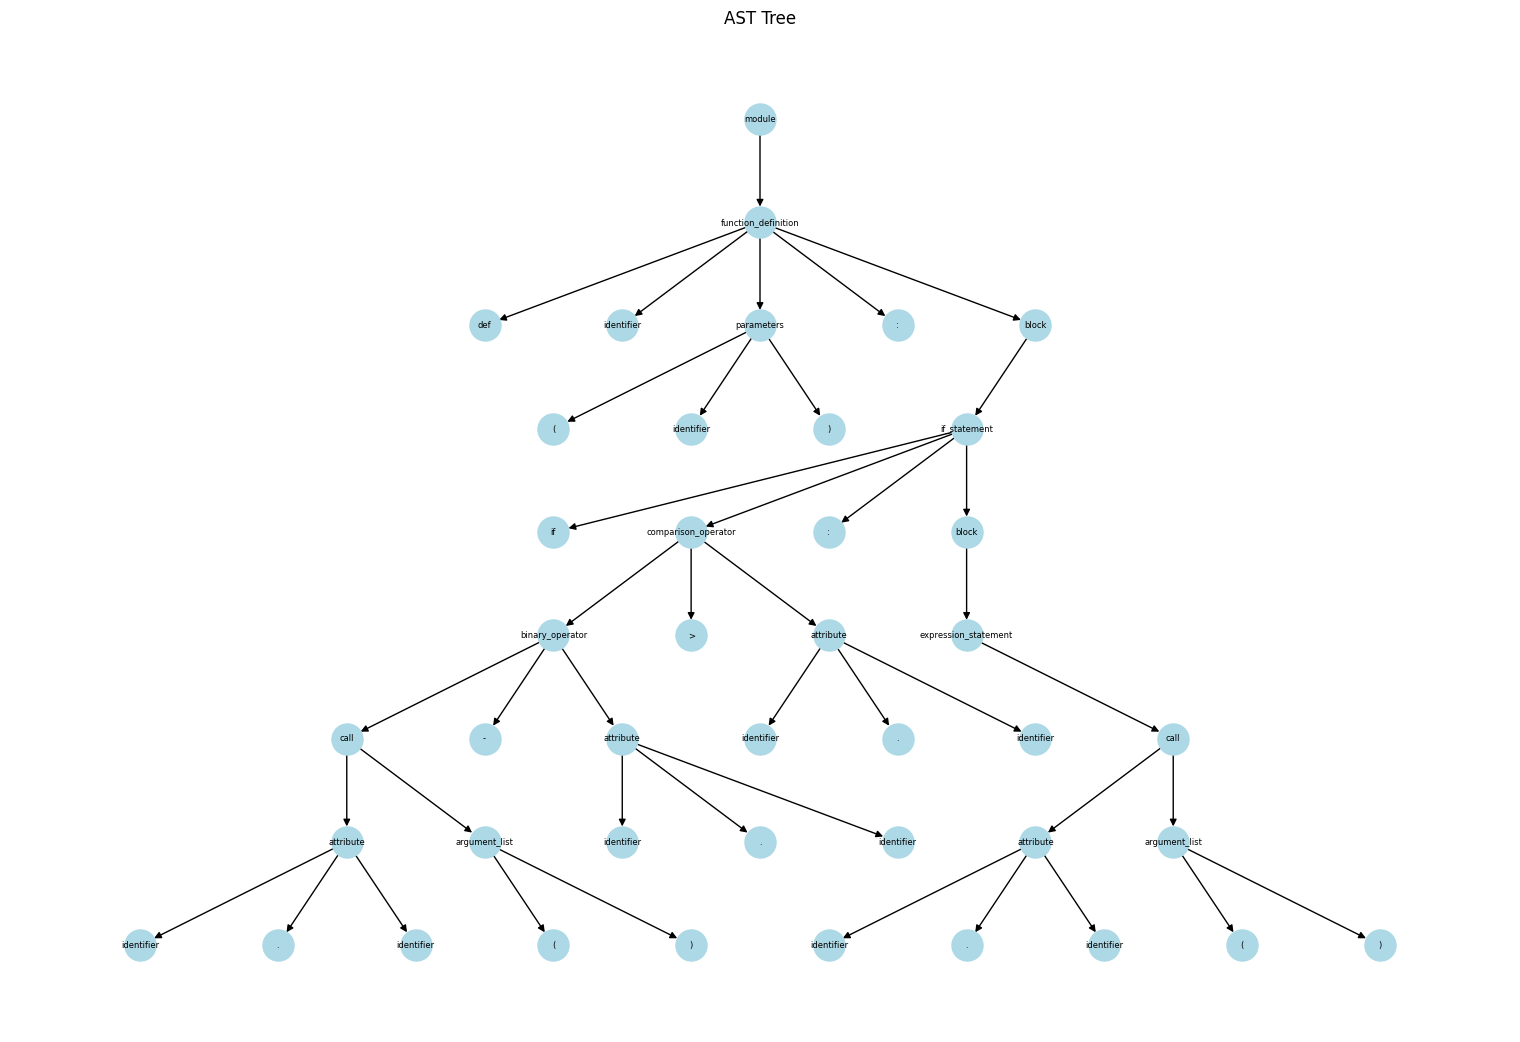

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, figsize=(15, 10), show_labels=True):
    # Convert to NetworkX graph
    G = to_networkx(data, to_undirected=False)
    
    plt.figure(figsize=figsize)
    
    # Create tree layout manually
    pos = {}
    
    # Find root (node with no incoming edges)
    root = 0
    for node in G.nodes():
        if G.in_degree(node) == 0:
            root = node
            break
    
    # Assign positions level by level
    levels = {}
    queue = [(root, 0)]
    
    while queue:
        node, level = queue.pop(0)
        levels[node] = level
        
        # Add children to next level
        for child in G.successors(node):
            queue.append((child, level + 1))
    
    # Group nodes by level
    level_groups = {}
    for node, level in levels.items():
        if level not in level_groups:
            level_groups[level] = []
        level_groups[level].append(node)
    
    # Position nodes
    for level, nodes in level_groups.items():
        for i, node in enumerate(nodes):
            x = i - len(nodes) / 2  # Center nodes horizontally
            y = -level  # Higher levels at top
            pos[node] = (x, y)
    
    # Create labels if requested
    labels = None
    if show_labels:
        # Create reverse mapping from index to type
        ind_to_type = {v: k for k, v in type_to_ind.items()}
        labels = {}
        for node in G.nodes():
            node_type_idx = data.x[node].item()
            node_type = ind_to_type.get(node_type_idx, f"idx_{node_type_idx}")
            labels[node] = node_type
    
    nx.draw(G, pos, with_labels=show_labels, labels=labels, 
            node_color='lightblue', node_size=500, arrows=True, 
            font_size=6 if show_labels else 8)
    
    plt.title("AST Tree")
    plt.show()

visualize_graph(train_graphs[1], show_labels=True)
